In [83]:
# Pre-processing
from google.colab import drive
drive.mount('/content/drive')
%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Figure size 1800x1200 with 0 Axes>

In [84]:
def obj_fun(x : tuple, *args):
  mu, E = x
  u, n, exp_num, d, rho, D = args

  test_damper = damper(d, D, mu, E, rho, n, exp = exp_num)

  # have to match sim to test so that least_squares has 1:1 data matchup
  test_damper.match_test(u)

  return test_damper.least_squares()

def optimize(*args): # u in mm/s
  import numpy as np
  from scipy.optimize import minimize
  x0 = (700, 100) # realistic starting point
  res = minimize(obj_fun, x0, method='nelder-mead', \
                args = (args), options={'disp': False})
  return res.x

In [85]:
# Experiment 2
%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"
import numpy as np

test_speeds = [0.1, 1, 5, 8] # mm/s

vals = np.zeros((len(test_speeds), 2)) # to contain mu and E values from optimization, not experimentally determined

for i in range(len(test_speeds)):
  n = 1
  exp_num = 2
  d = 1E-3 # m
  rho = 1300 # kg/m^3 (toothpaste)
  D = (20 + 23.5)/2 * 1E-3 # m
  u = test_speeds[i] # mm/s
  vals[i,:] = optimize(u, n, exp_num, d, rho, D)

/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:60: RuntimeWarning: invalid value encountered in double_scalars
  A_Cd = (19000*self.beta/self.ReD)**0.8
/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:67: RuntimeWarning: invalid value encountered in double_scalars
  + 0.000521*(10**6*self.beta/self.ReD)**0.7 \
/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:68: RuntimeWarning: invalid value encountered in double_scalars
  + (0.0188 + 0.0063*A_Cd)*self.beta**(3.5)*(10**6/self.ReD)**0.3 \


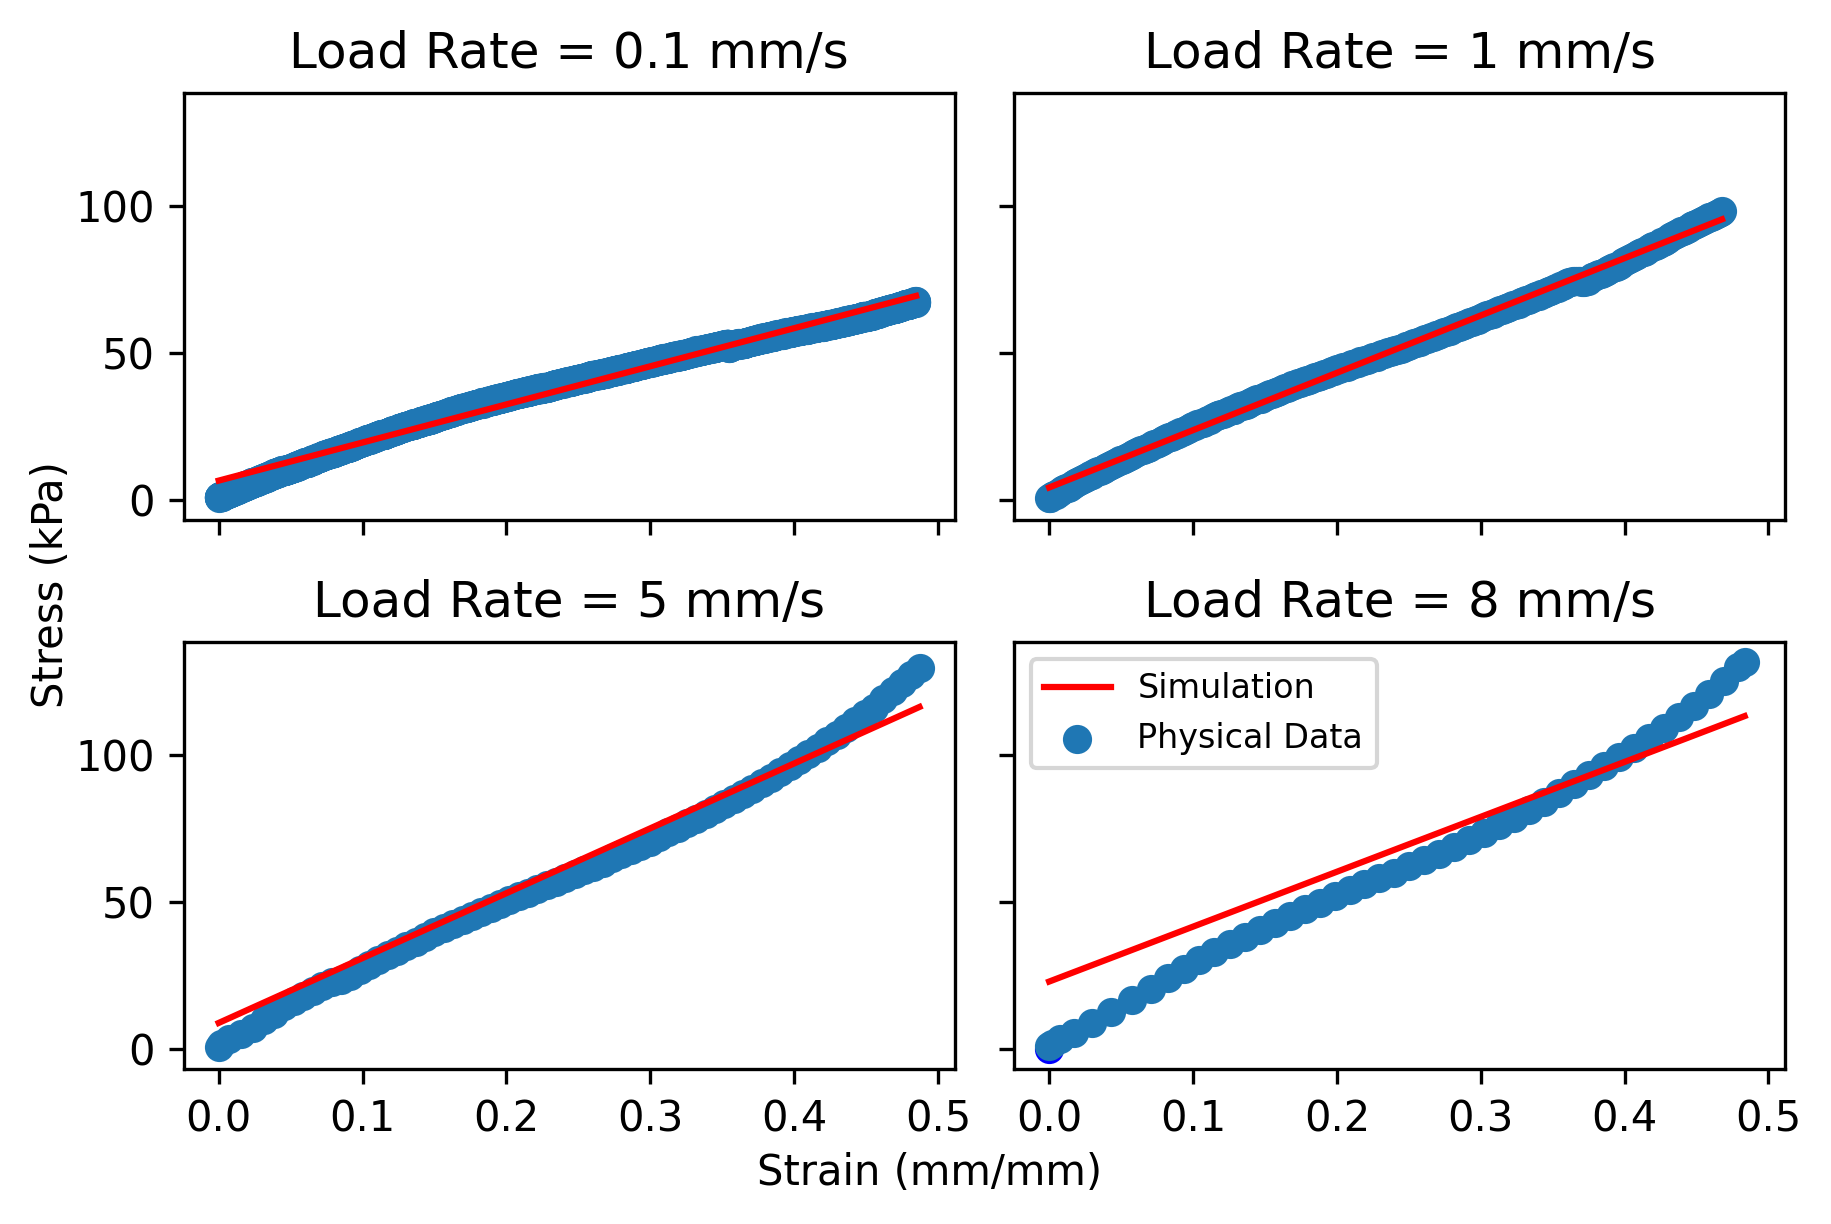

In [86]:
d = 1E-3 # m
D = (20 + 23.5)/2 * 1E-3 # m
rho = 1300 # kg/m^3 (toothpaste)
n = 1

dampers = []

td = []

fig, axs = plt.subplots(2, 2, sharex = True, sharey = True)

index = [[0,0], [0,1], [1,0], [1,1]]

custom_lines = [plt.plot([0],[0],'r'), plt.scatter([0],[0],c = 'b')]

for i in range(len(test_speeds)):
  mu, E = vals[i, 0], vals[i, 1]
  dampers.append(damper(d, D, mu, E, rho, n, exp = 2))

for i in reversed(range(len(test_speeds))):
  u = test_speeds[i] # m/s
  dampers[i].match_test(u)
  axs[index[i][0], index[i][1]].scatter(dampers[i].test_strain, dampers[i].test_stress, label = "Physical Data")
  axs[index[i][0], index[i][1]].plot(dampers[i].strain_history, dampers[i].stress_history, 'r', label = "Simulation")
  axs[index[i][0], index[i][1]].set_title('Load Rate = {} mm/s'.format(u))
  plt.legend(prop={'size': 8})
  td.append(np.array((test_speeds[i]*np.ones((dampers[i].test_strain.size)), dampers[i].test_strain, dampers[i].test_stress)))

fig.text(0.5, 0.0, 'Strain (mm/mm)', ha='center')
fig.text(0.0, 0.5, 'Stress (kPa)', va='center', rotation='vertical')
fig.tight_layout()

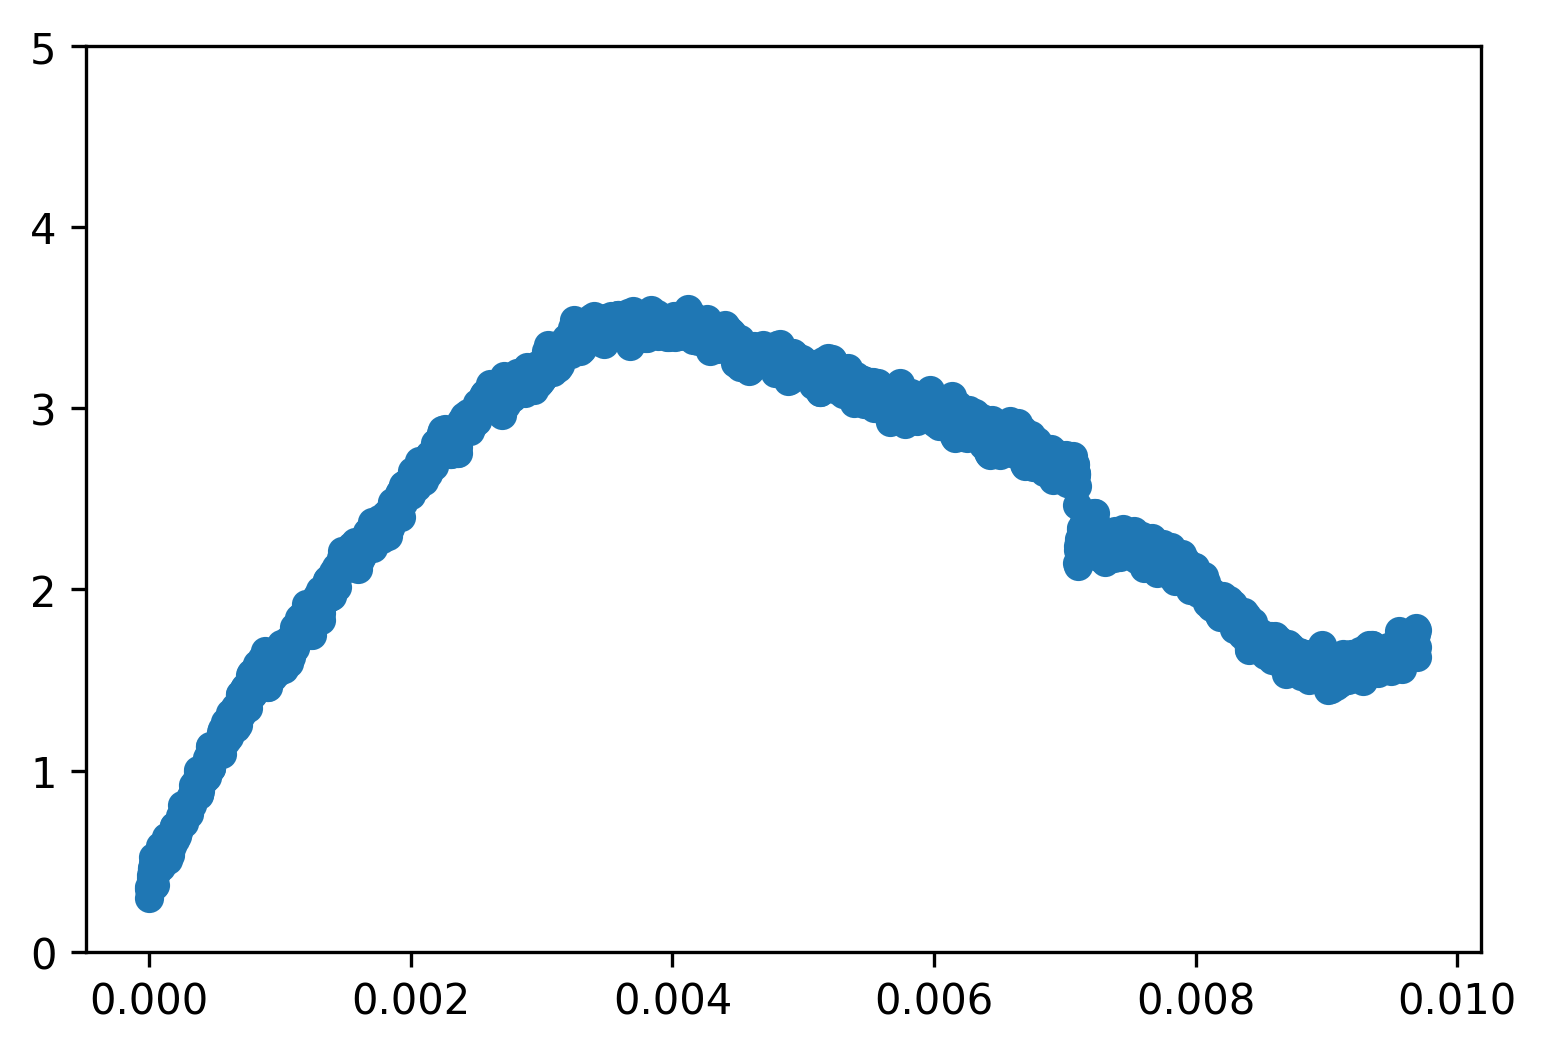

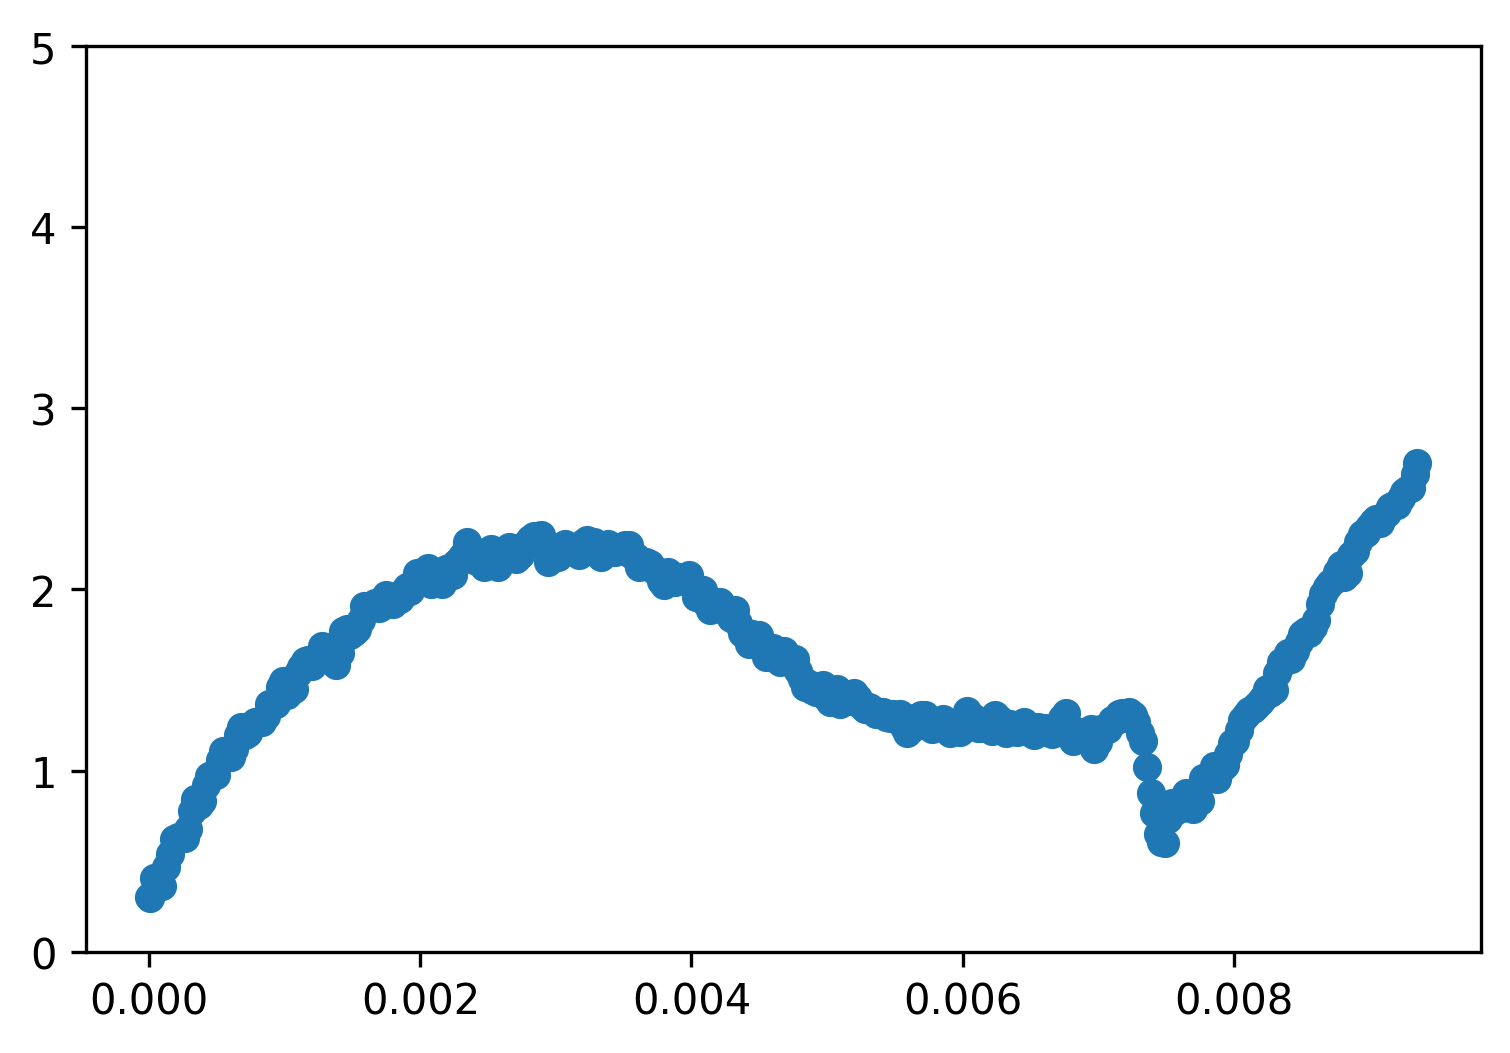

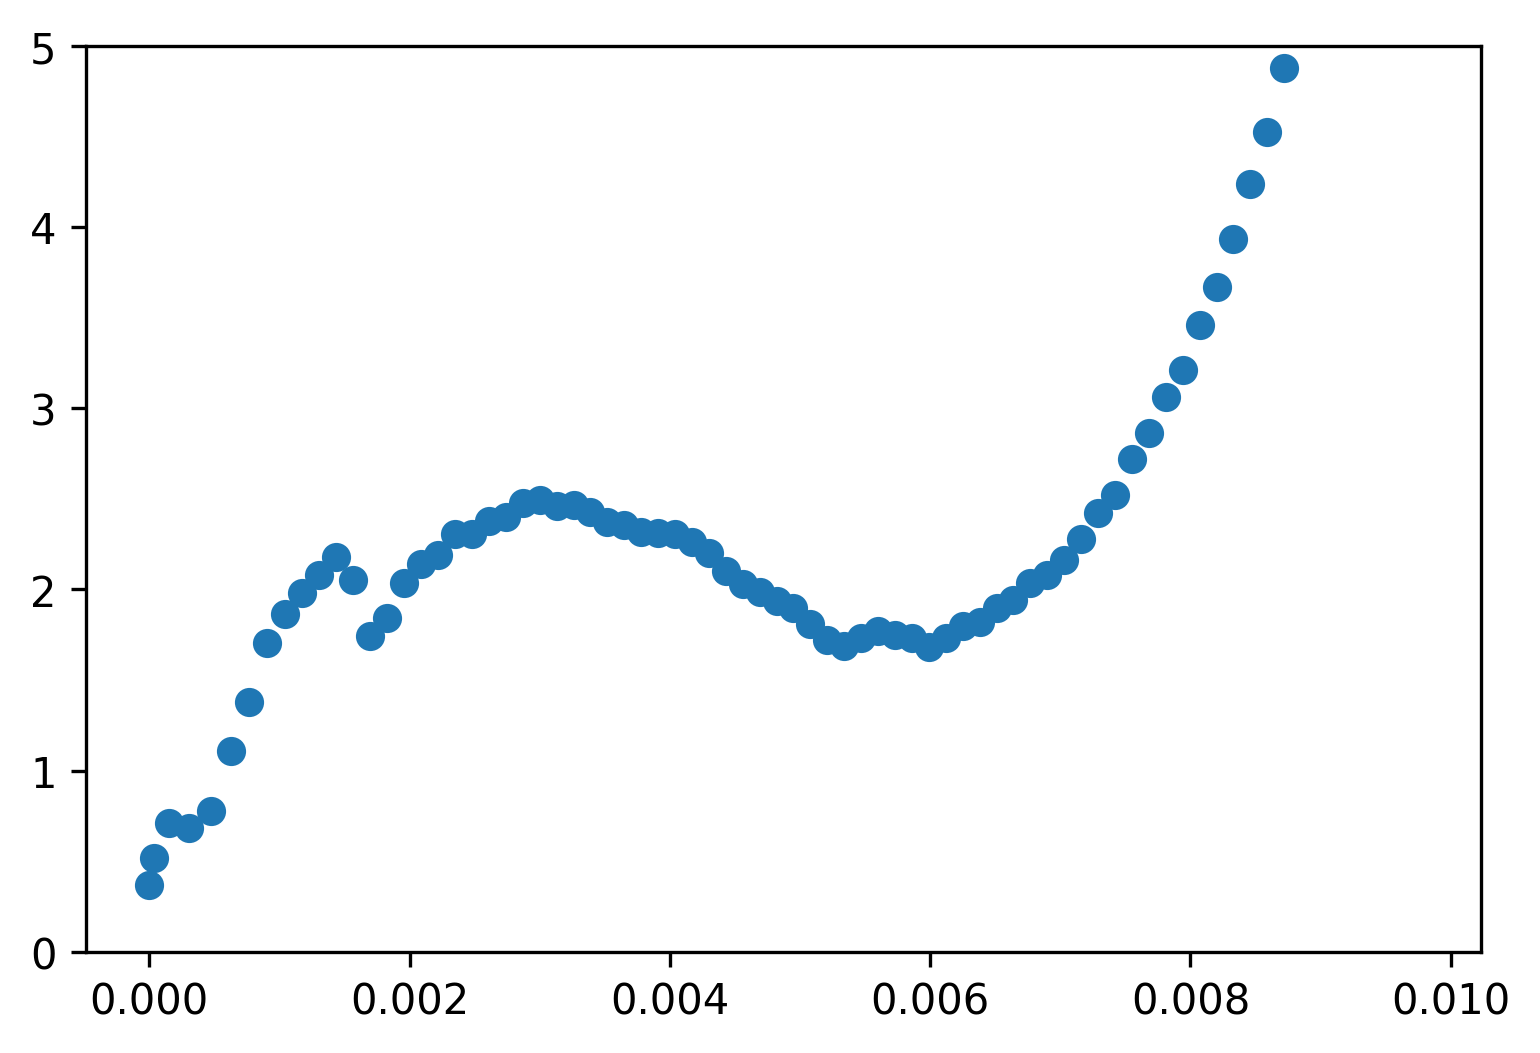

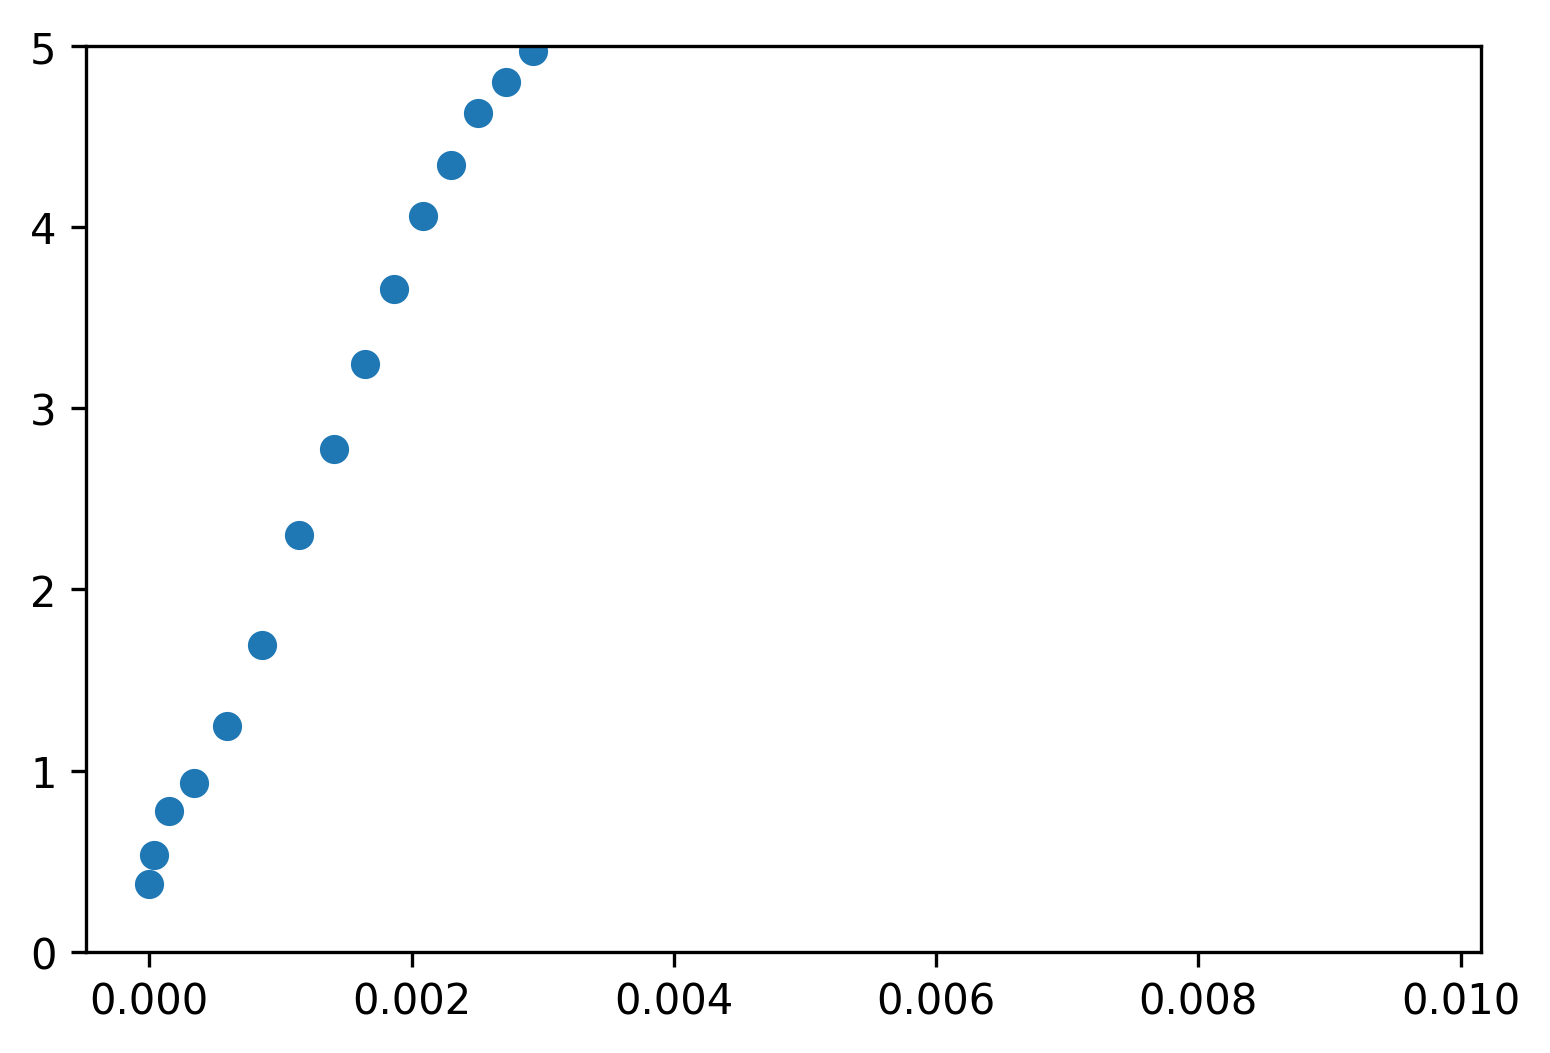

[691.2502954457175, 44.84237225965905, 14.867069679478762, 22.57749968242133]


In [87]:
# Exp 2 mus
test_mus = []
for i in range(len(test_speeds)):
  total_force = np.array(dampers[i].test_force)
  spring_force = np.array(dampers[i].test_disp)*dampers[i].k
  disp = np.array(dampers[i].test_disp)
  plt.scatter(disp, total_force - spring_force)
  plt.ylim([0,5])
  plt.show()
  viscous_force = (np.average(total_force - spring_force)) # N
  mu = viscous_force*np.pi*(dampers[i].d/2)**4/(8*dampers[i].t*dampers[i].Q*dampers[i].a) # kg/(m-s)
  test_mus.append(mu)

print(test_mus)

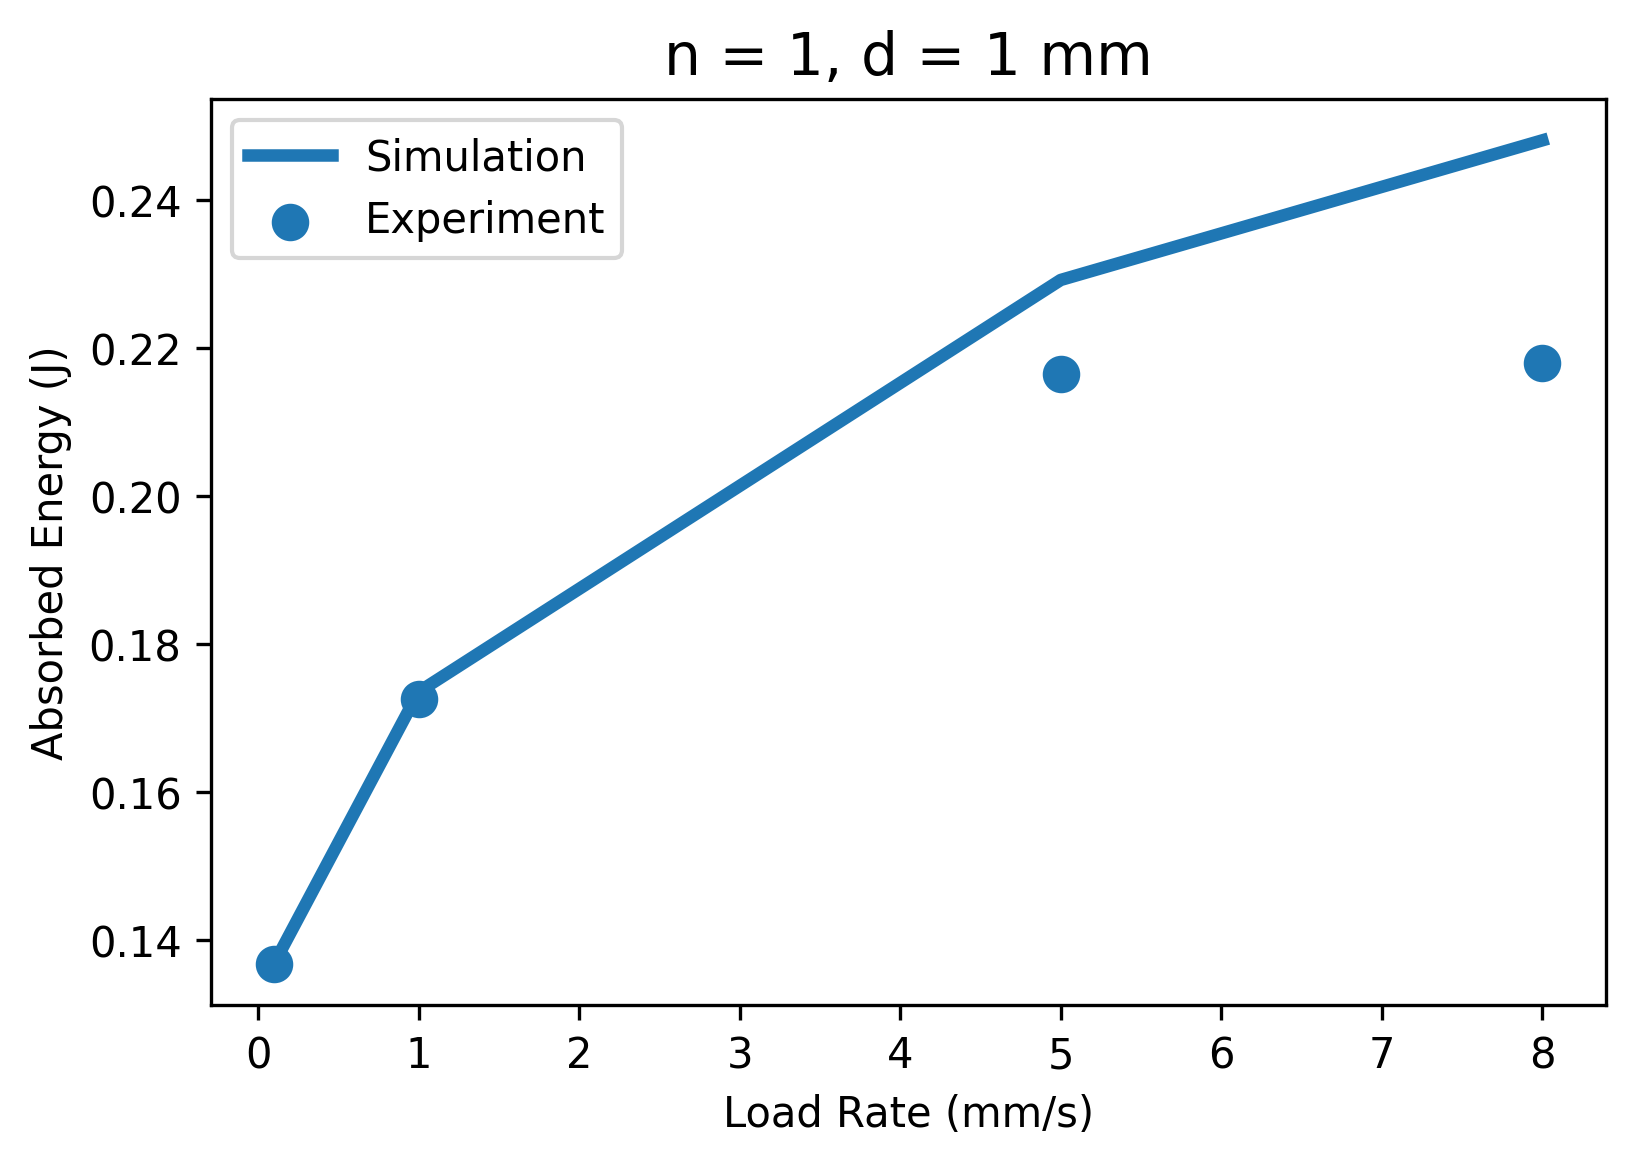

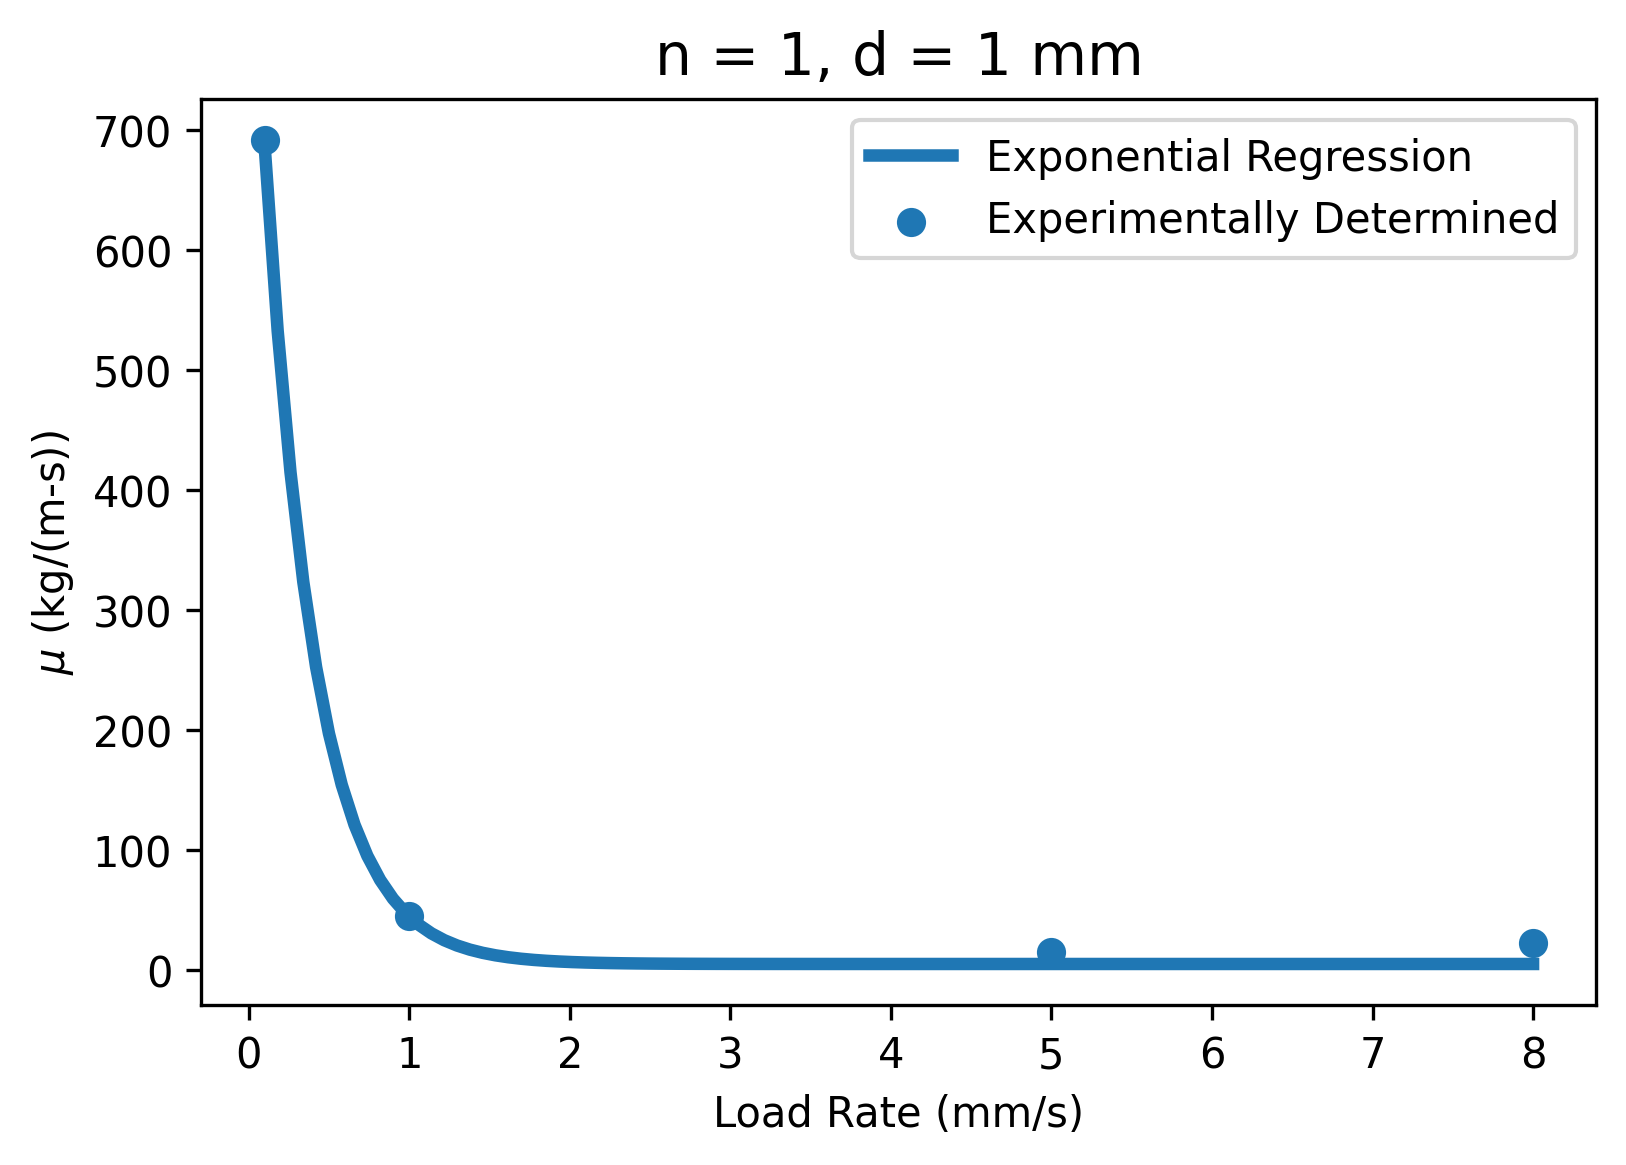

r-squared for mu: 0.998570726988955
mu at 8 m/s: 4.76585402017376 kg/(m-s)


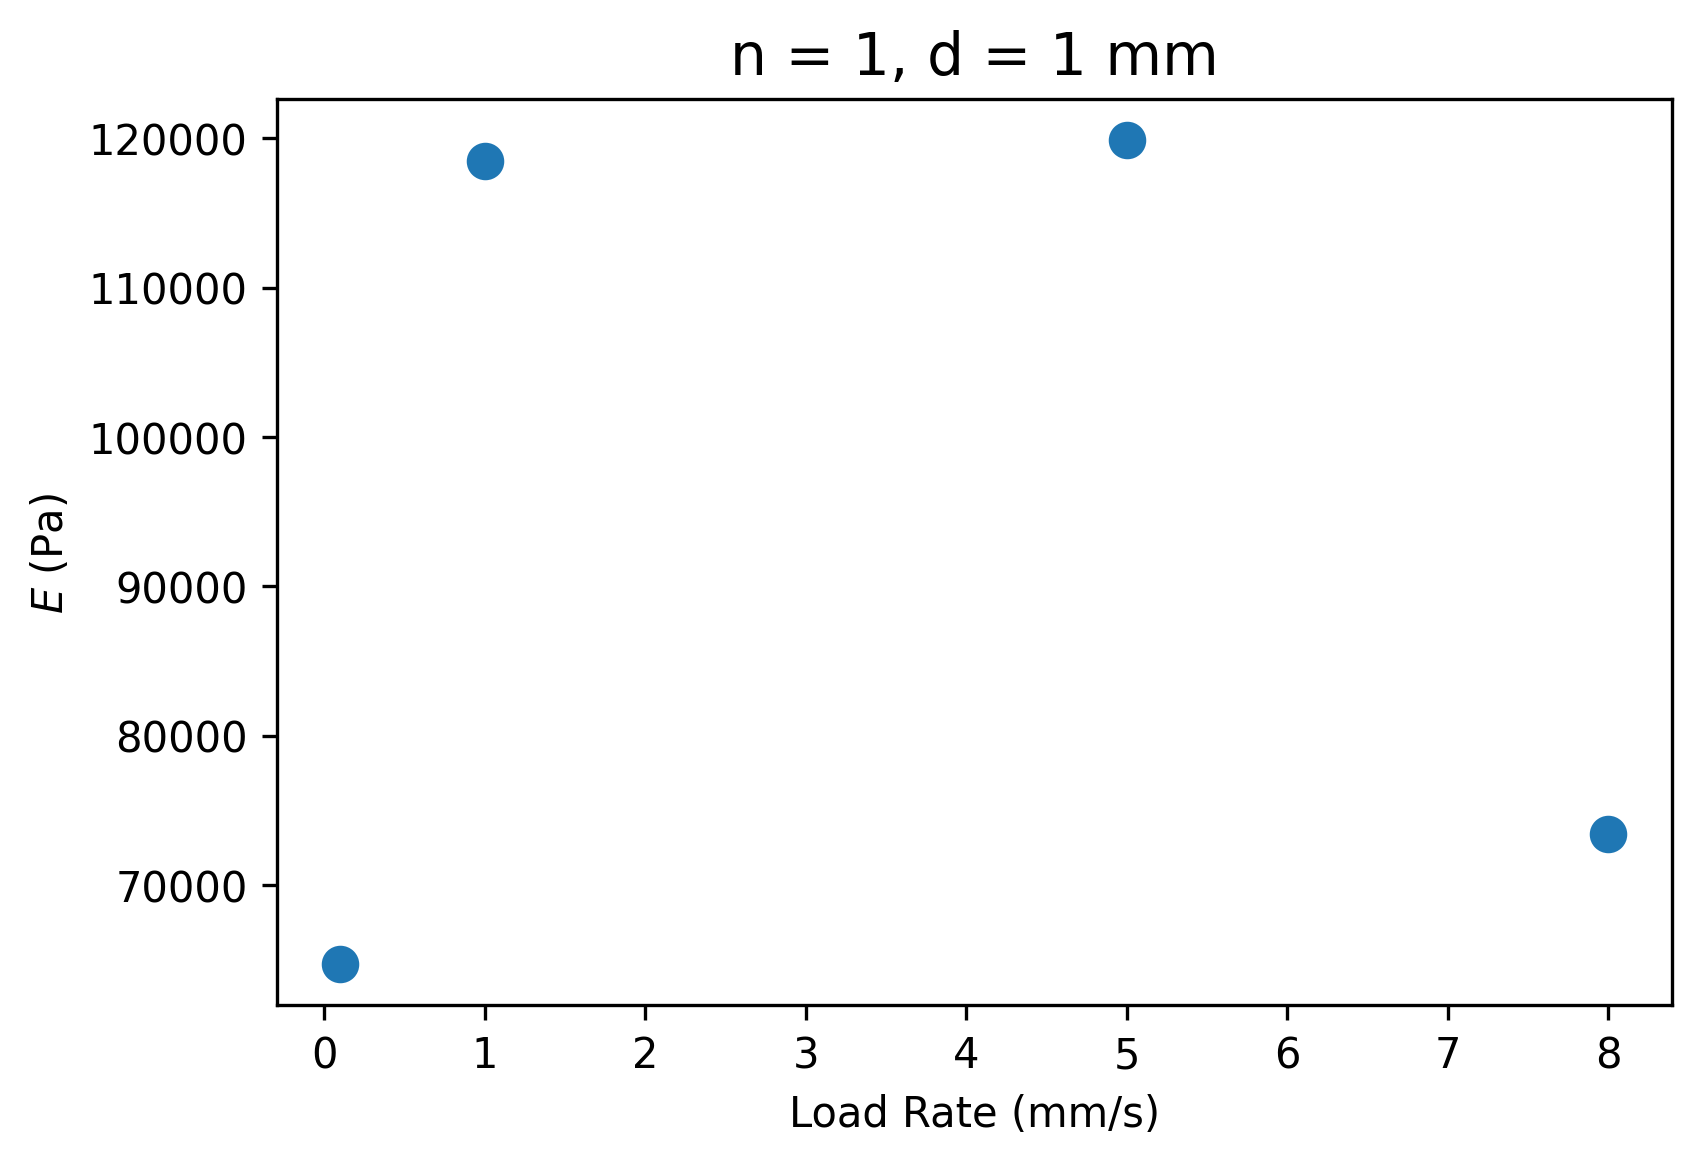

In [88]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"

# compare simulated and experimental energy

sim_energies = []
exp_energies = []
for damper in dampers:
  sim_energies.append(damper.energy)
  exp_energies.append(damper.left_point_integrate(\
                      damper.test_disp, damper.test_force))

plt.plot(test_speeds, sim_energies, linewidth = 3, label = "Simulation")
plt.scatter(test_speeds, exp_energies, linewidth = 3, label = "Experiment")
plt.title("n = 1, d = 1 mm", fontsize = 14)
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("Absorbed Energy (J)")
plt.legend()
plt.show()

# plot mu (experimental) vs speed
plt.scatter(test_speeds, test_mus, label = 'Experimentally Determined')
plt.title("n = 1, d = 1 mm", fontsize = 14)
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("$\mu$ (kg/(m-s))")

# exp decay fit to mu
def func(x, a, b, c):
    return a*np.exp(-b*x)+c 

params, _ = curve_fit(func, test_speeds, vals[:,0])
a, b, c = params[0], params[1], params[2]
x_sample = np.linspace(0.1, 8, 100)
yfit = lambda x: a*np.exp(-x*b)+c
plt.plot(x_sample, yfit(x_sample), linewidth = 3, label = 'Exponential Regression')
plt.legend()
plt.show()
print('r-squared for mu: {}'.format(r2_score(test_mus, a*np.exp(np.array(test_speeds)*-b)+c)))
print('mu at 8 m/s: {} kg/(m-s)'.format(yfit(8000)))
mu_8000 = yfit(8000)

# plot E vs speed
plt.scatter(test_speeds, vals[:,1], linewidth = 3)
plt.title("n = 1, d = 1 mm", fontsize = 14)
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("$E$ (Pa)")
plt.show()

sim_energies2 = sim_energies
exp_energies2 = exp_energies

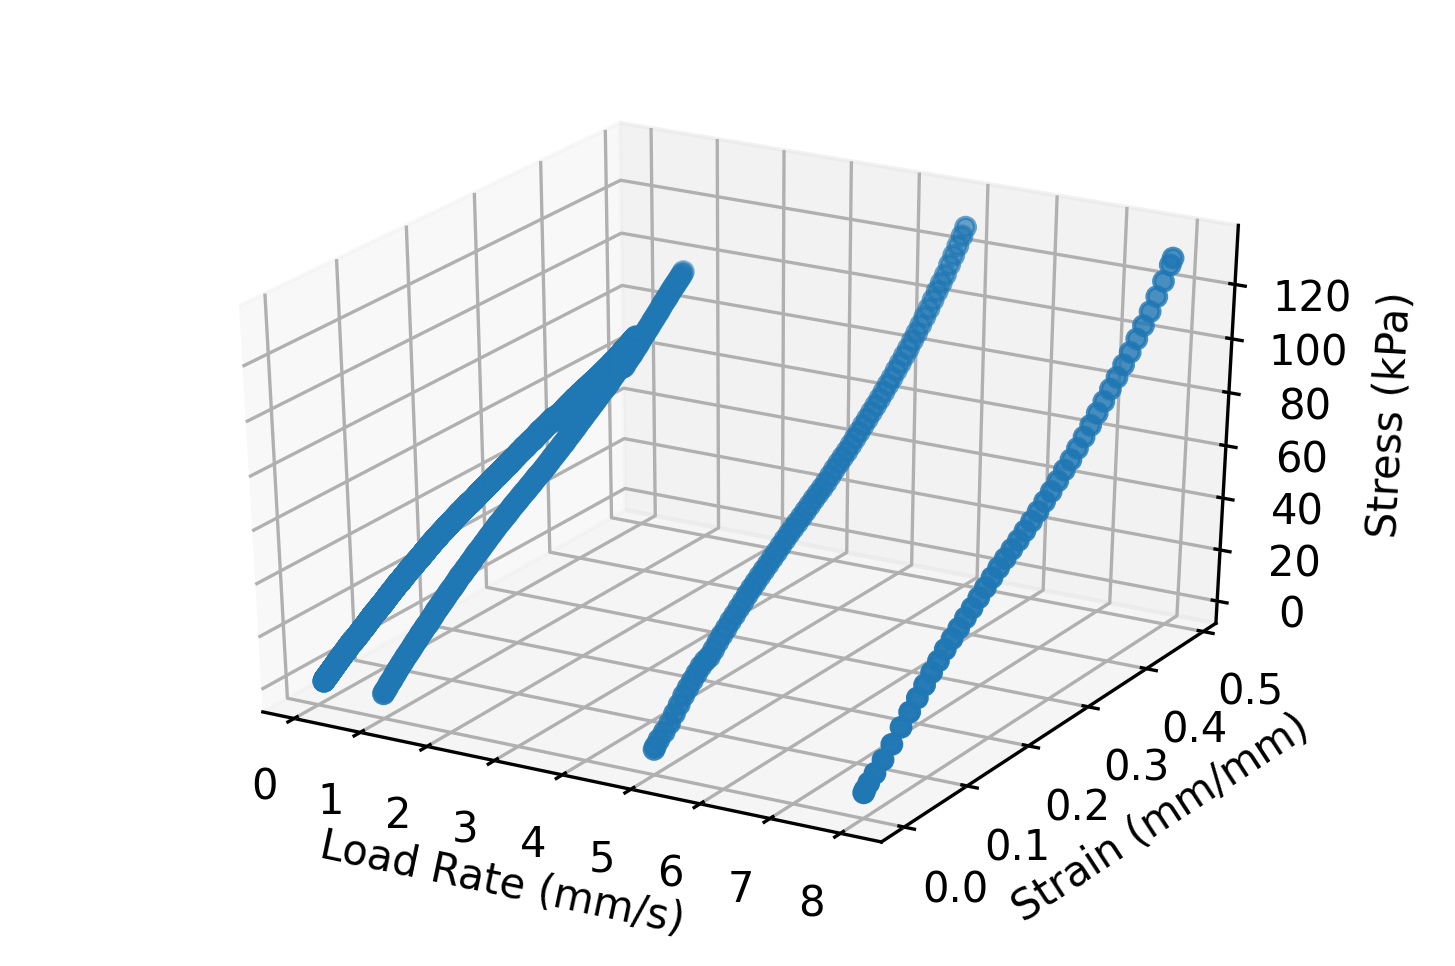

In [89]:
# extra plotting for exp 2 for poster
x = []
for i in range(4):
  for j in td[i][0,:]:
    x.append(j)

y = []
for i in range(4):
  for j in td[i][1,:]:
    y.append(j)

z = []
for i in range(4):
  for j in td[i][2,:]:
    z.append(j)

from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, 'gray')

ax.set_xlabel('Load Rate (mm/s)')
ax.set_ylabel('Strain (mm/mm)')
ax.set_zlabel('Stress (kPa)')

ax.dist = 11

/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:60: RuntimeWarning: invalid value encountered in double_scalars
  A_Cd = (19000*self.beta/self.ReD)**0.8
/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:67: RuntimeWarning: invalid value encountered in double_scalars
  + 0.000521*(10**6*self.beta/self.ReD)**0.7 \
/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:68: RuntimeWarning: invalid value encountered in double_scalars
  + (0.0188 + 0.0063*A_Cd)*self.beta**(3.5)*(10**6/self.ReD)**0.3 \


<Figure size 1800x1200 with 0 Axes>

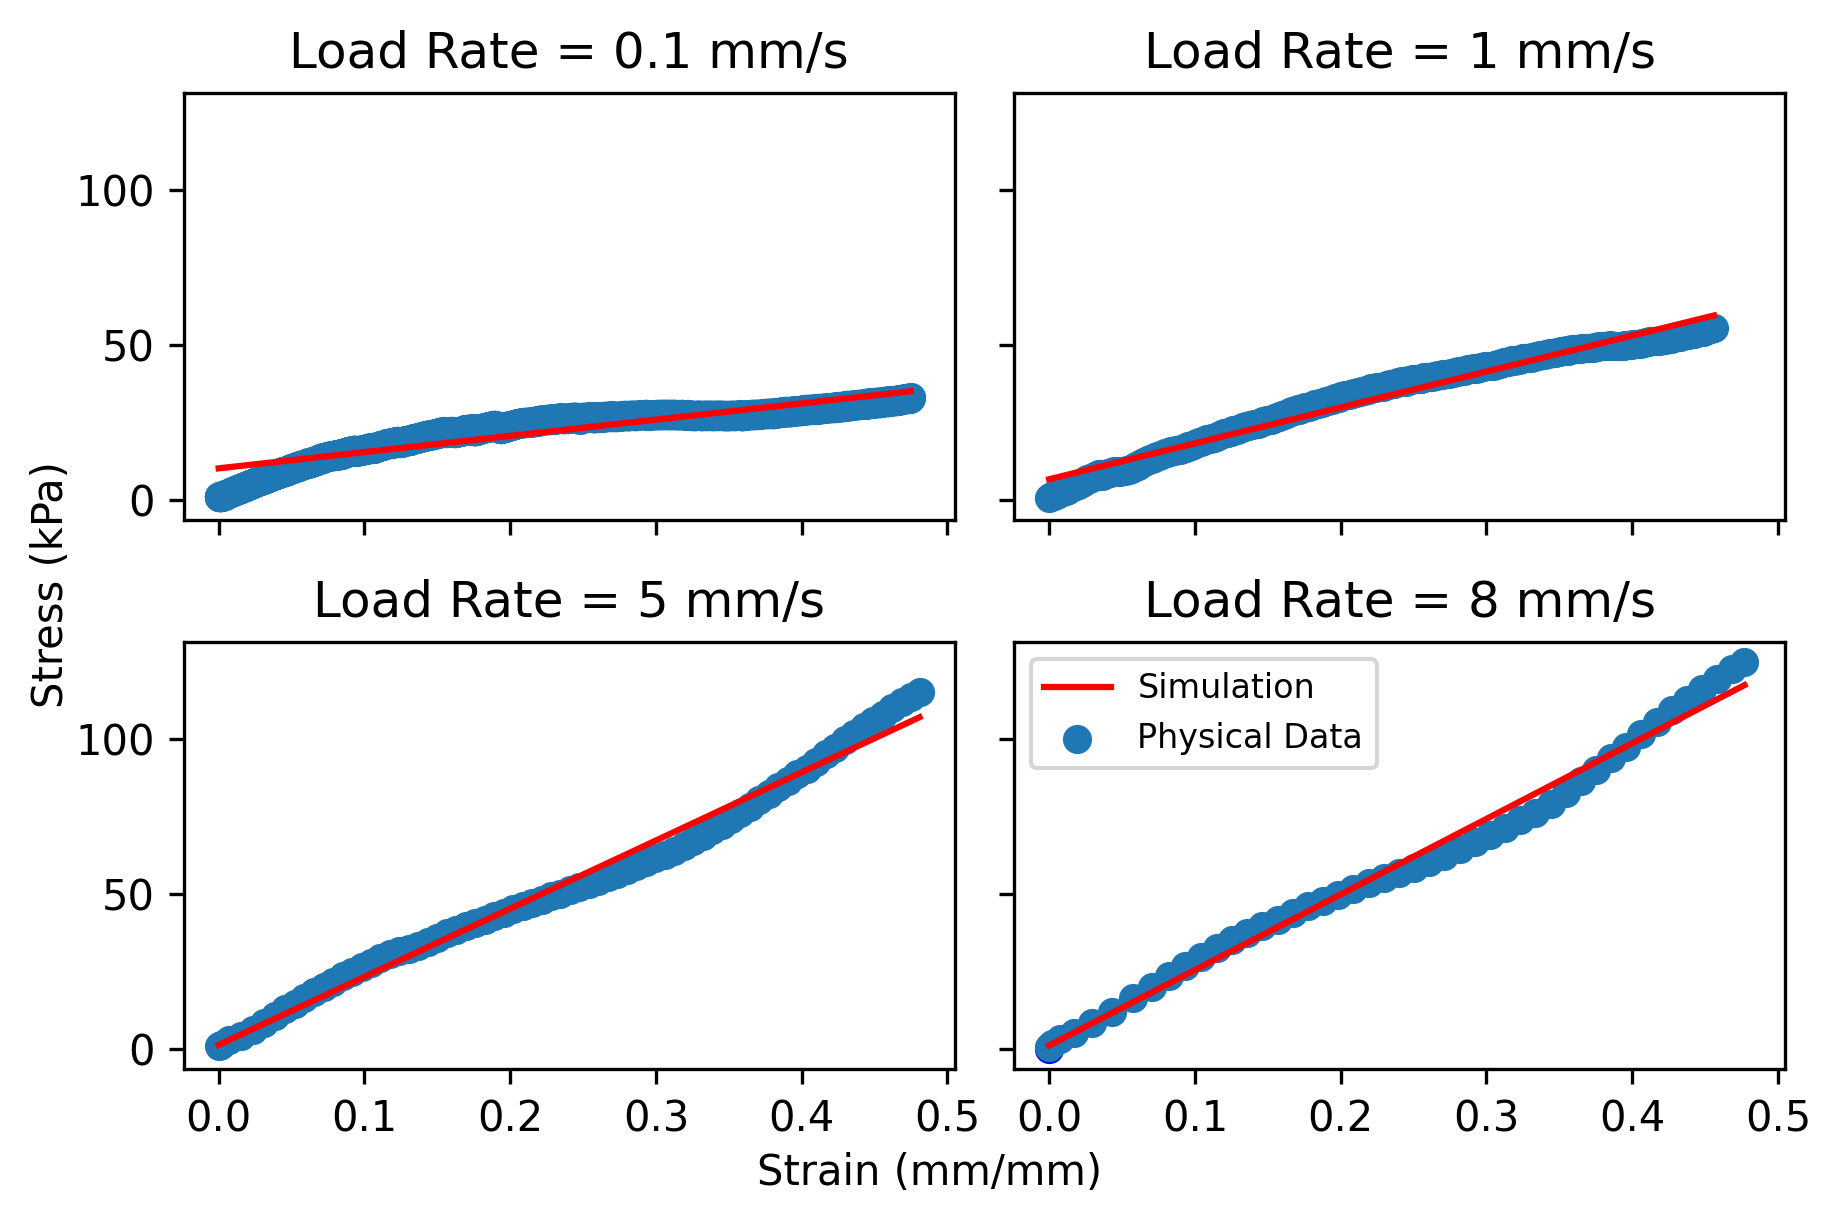

In [82]:
# Experiment 3
%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"
import numpy as np

test_speeds = [0.1, 1, 5, 8] # mm/s

vals = np.zeros((len(test_speeds), 2))

for i in range(len(test_speeds)):
  n = 1
  exp_num = 3
  d = 2E-3 # m
  rho = 1300 # kg/m^3 (toothpaste)
  D = (20 + 23.5)/2 * 1E-3 # m
  u = test_speeds[i] # mm/s
  vals[i,:] = optimize(u, n, exp_num, d, rho, D)

d = 2E-3 # m
D = (20 + 23.5)/2 * 1E-3 # m
rho = 1300 # kg/m^3 (toothpaste)
n = 1

dampers = []

fig, axs = plt.subplots(2, 2, sharex = True, sharey = True)

index = [[0,0], [0,1], [1,0], [1,1]]

custom_lines = [plt.plot([0],[0],'r'), plt.scatter([0],[0],c = 'b')]

for i in range(len(test_speeds)):
  mu, E = vals[i, 0], vals[i, 1]
  dampers.append(damper(d, D, mu, E, rho, n, exp = 3))

for i in reversed(range(len(test_speeds))):
  u = test_speeds[i] # m/s
  dampers[i].match_test(u)
  axs[index[i][0], index[i][1]].scatter(dampers[i].test_strain, dampers[i].test_stress, label = "Physical Data")
  axs[index[i][0], index[i][1]].plot(dampers[i].strain_history, dampers[i].stress_history, 'r', label = "Simulation")
  axs[index[i][0], index[i][1]].set_title('Load Rate = {} mm/s'.format(u))
  plt.legend(prop={'size': 8})
  td.append(np.array((test_speeds[i]*np.ones((dampers[i].test_strain.size)), dampers[i].test_strain, dampers[i].test_stress)))

fig.text(0.5, 0.0, 'Strain (mm/mm)', ha='center')
fig.text(0.0, 0.5, 'Stress (kPa)', va='center', rotation='vertical')
fig.tight_layout()

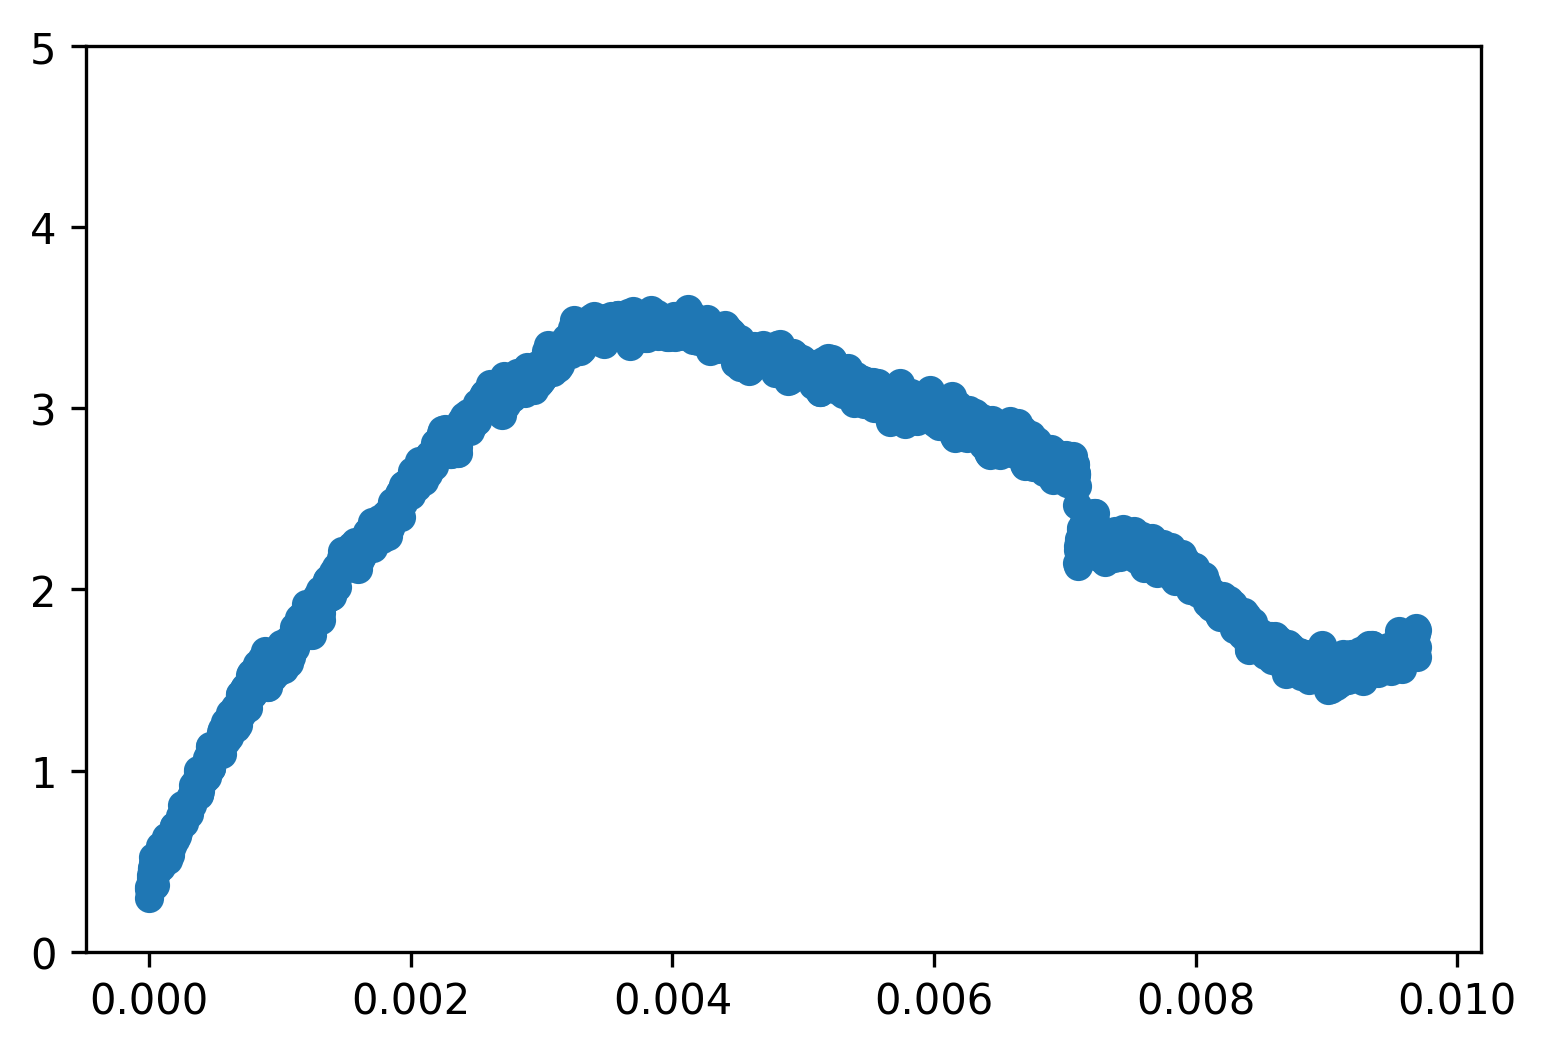

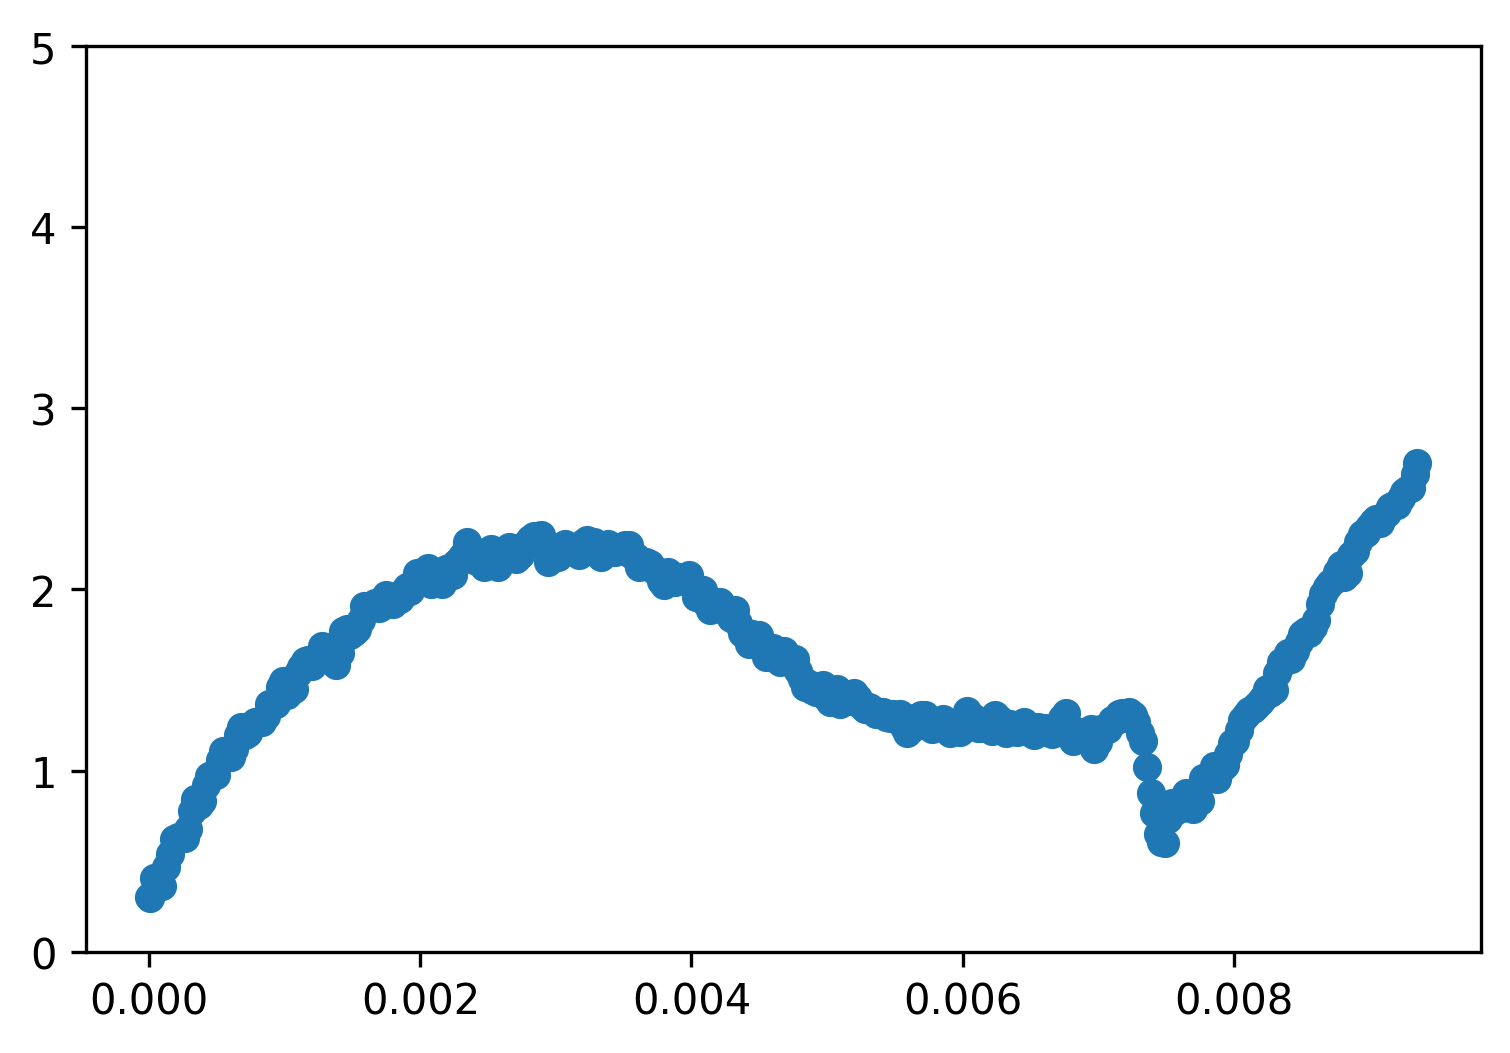

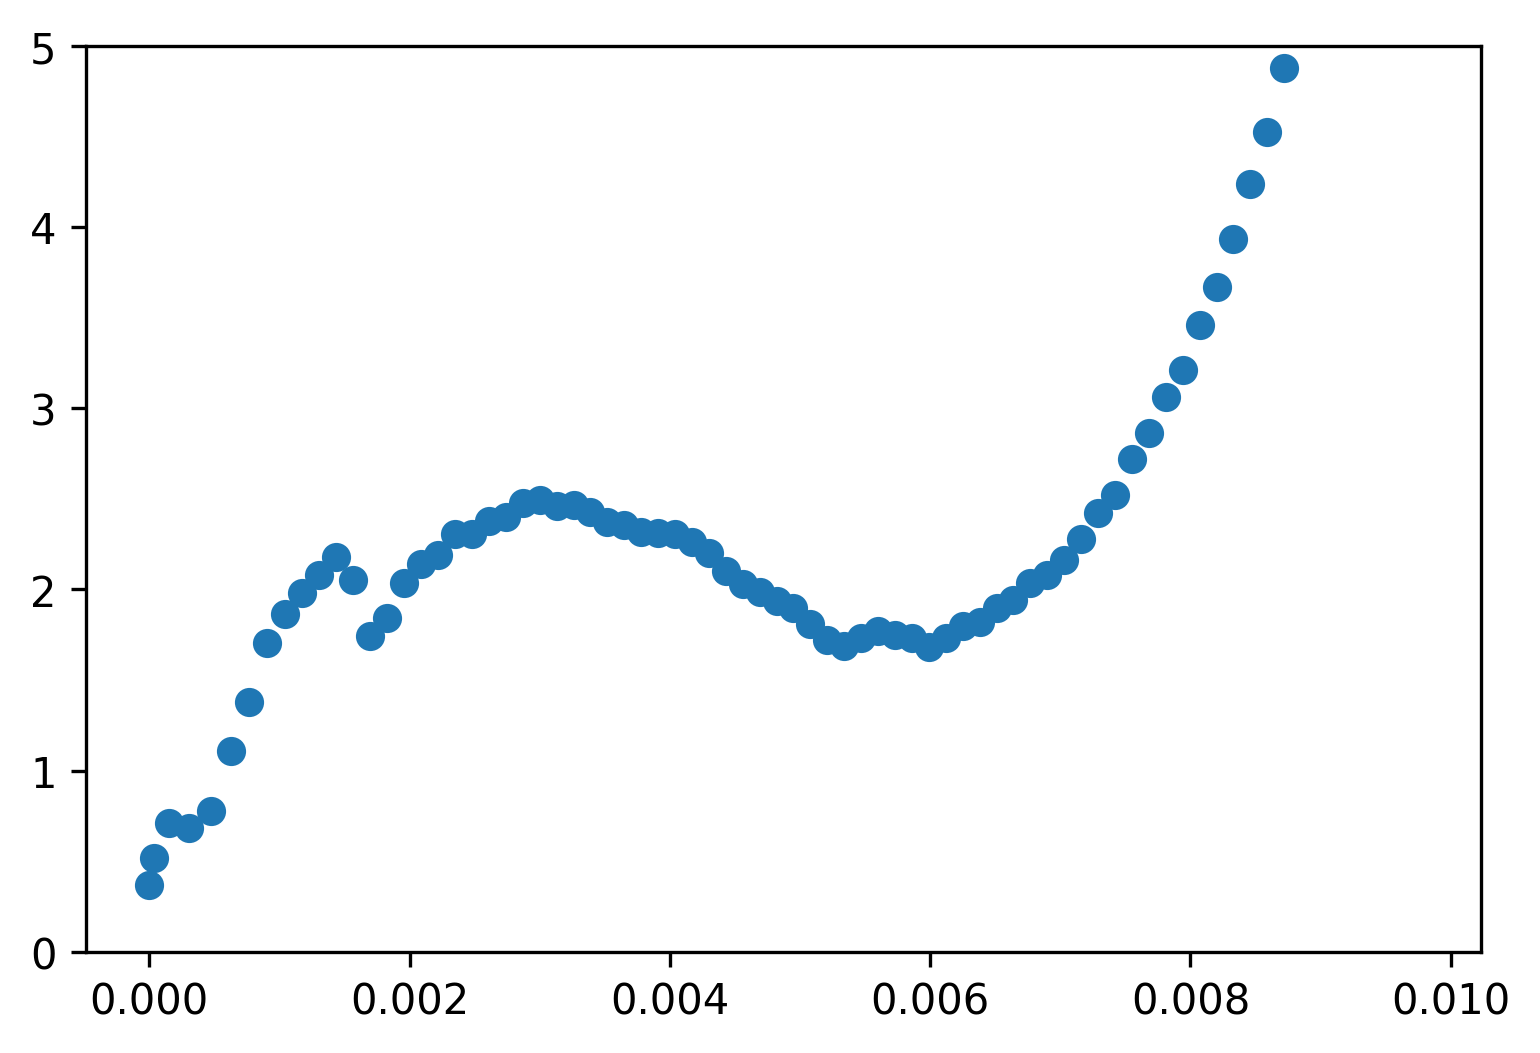

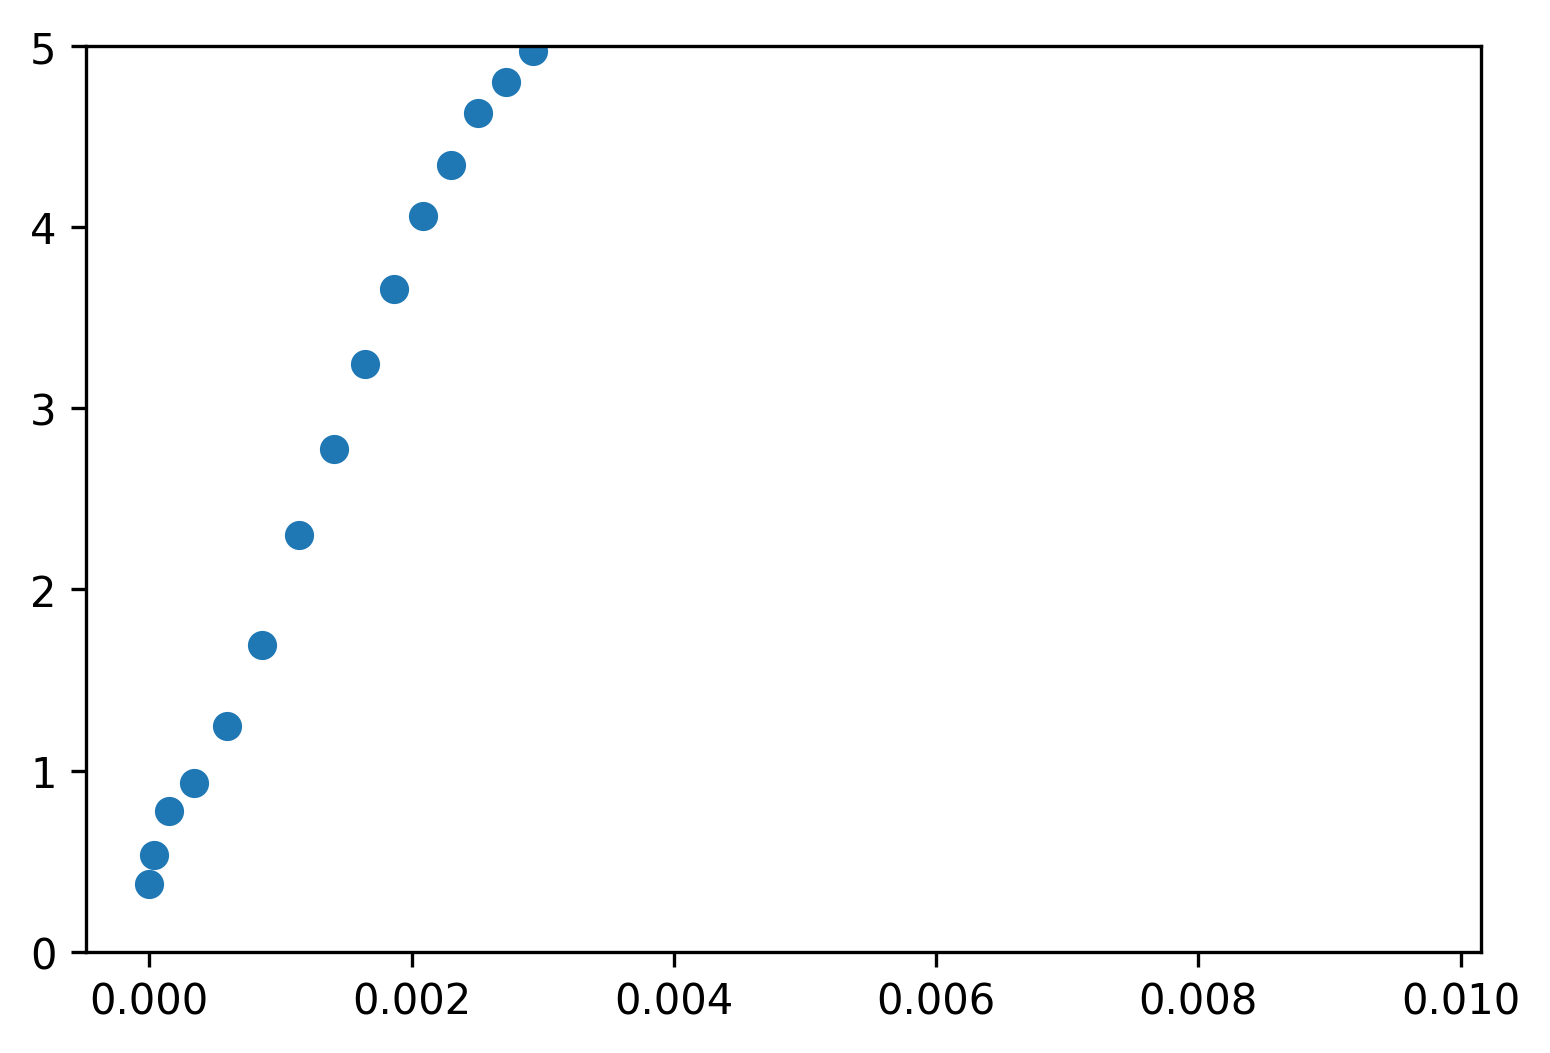

[691.2502954457175, 44.84237225965905, 14.867069679478762, 22.57749968242133]


In [90]:
# Exp 3 mus
test_mus = []
for i in range(len(test_speeds)):
  total_force = np.array(dampers[i].test_force)
  spring_force = np.array(dampers[i].test_disp)*dampers[i].k
  disp = np.array(dampers[i].test_disp)
  plt.scatter(disp, total_force - spring_force)
  plt.ylim([0,5])
  plt.show()
  viscous_force = (np.average(total_force - spring_force)) # N
  mu = viscous_force*np.pi*(dampers[i].d/2)**4/(8*dampers[i].t*dampers[i].Q*dampers[i].a) # kg/(m-s)
  test_mus.append(mu)

print(test_mus)

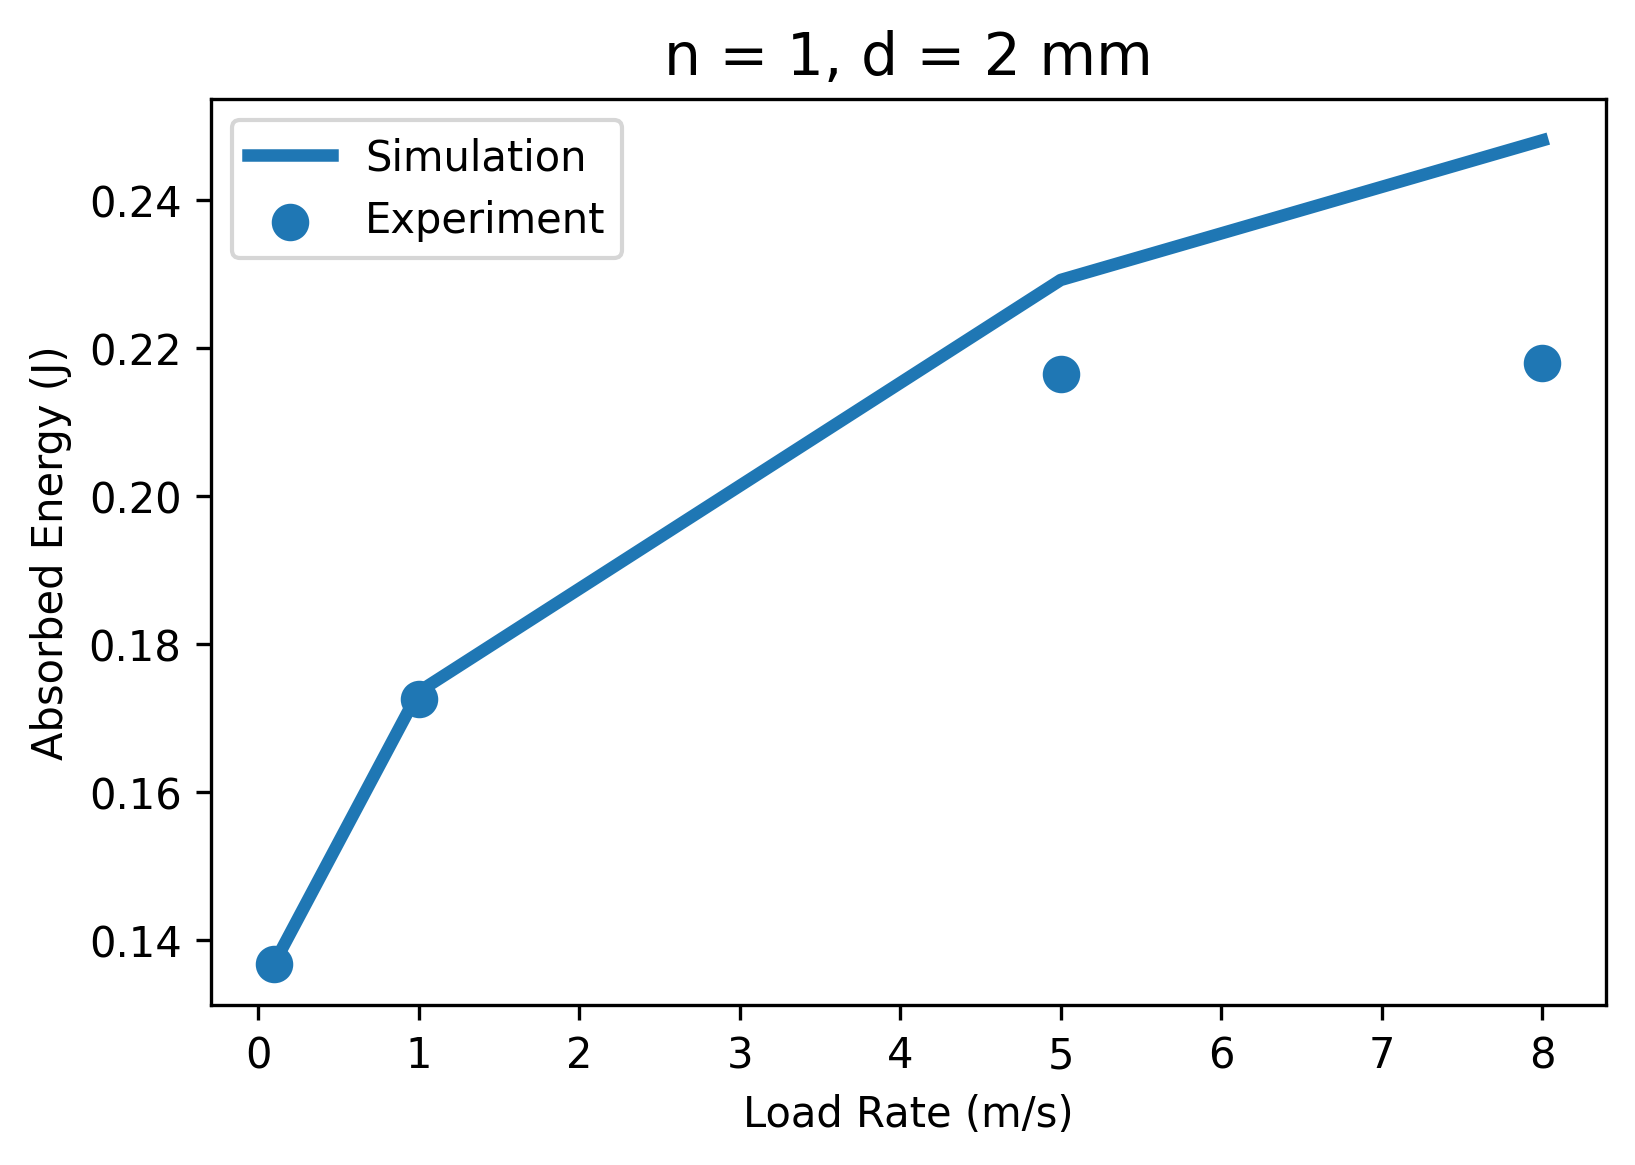

<ipython-input-91-0a0f694c5425>:31: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x)+c


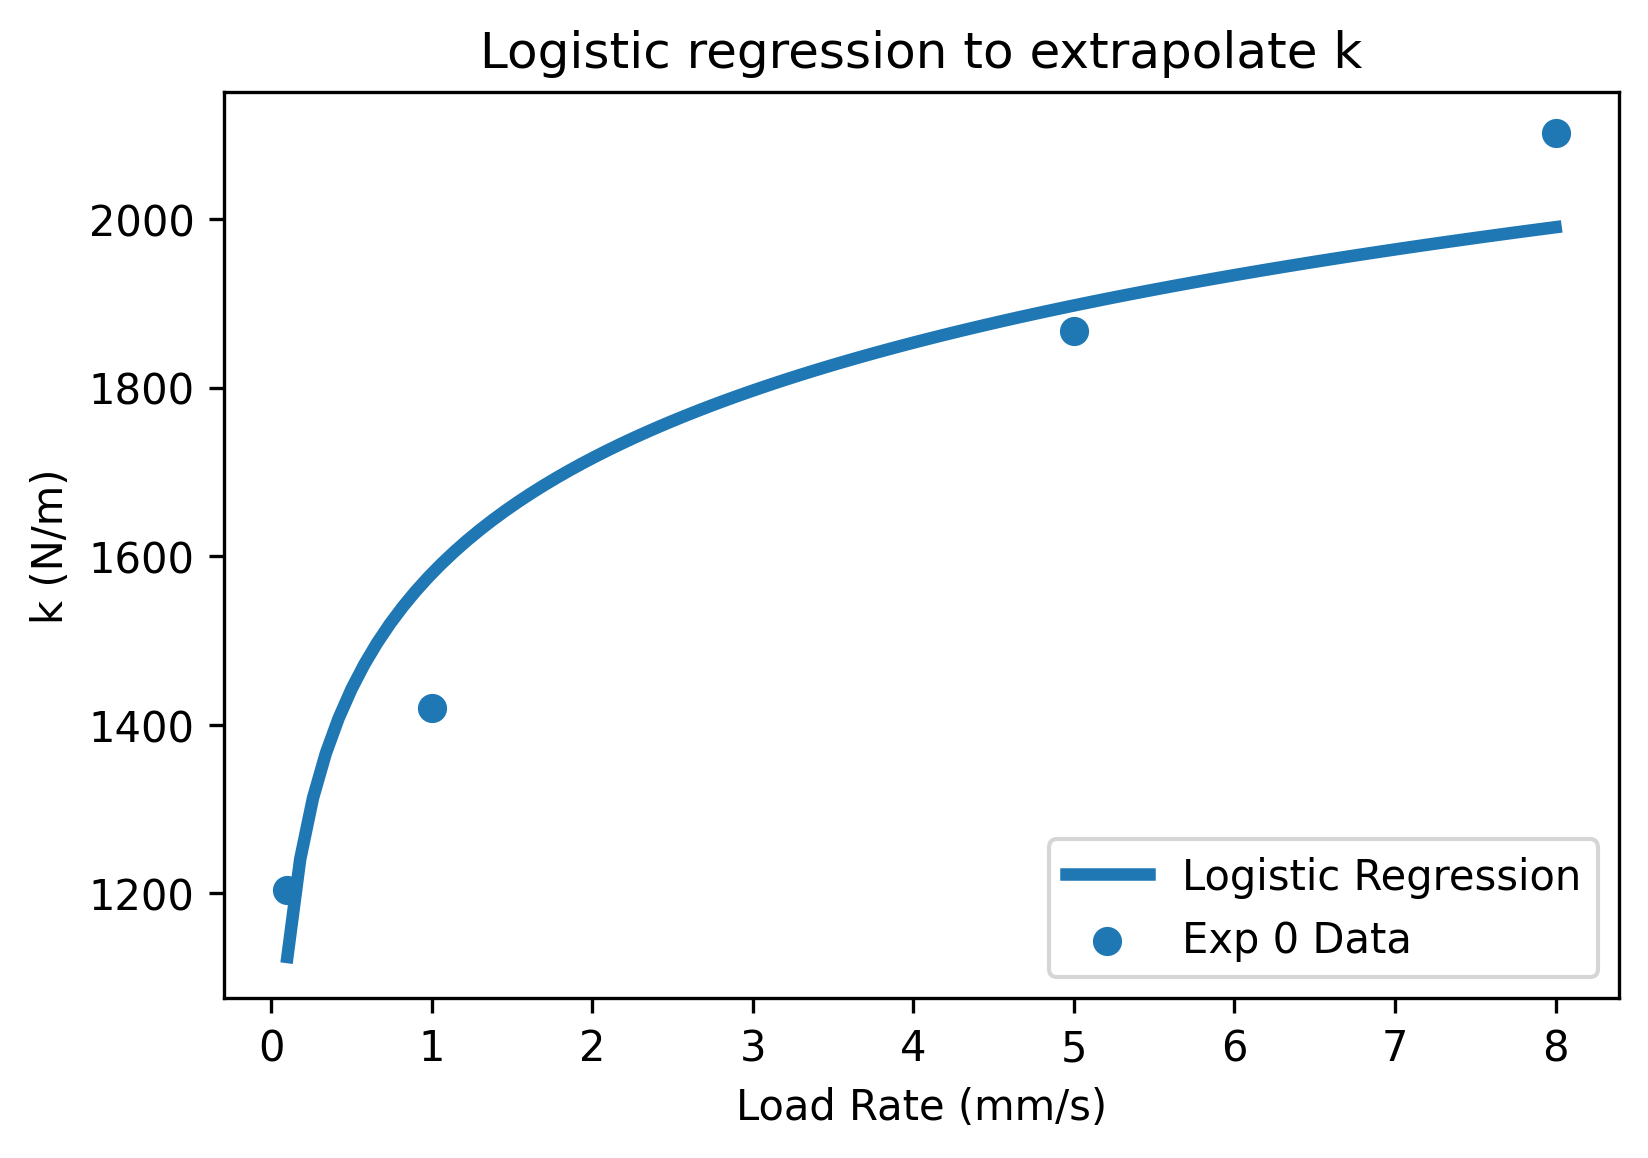

r-squared for k: 0.9101387858160587
k at 5.5 m/s: 3280.797103443766 N/m


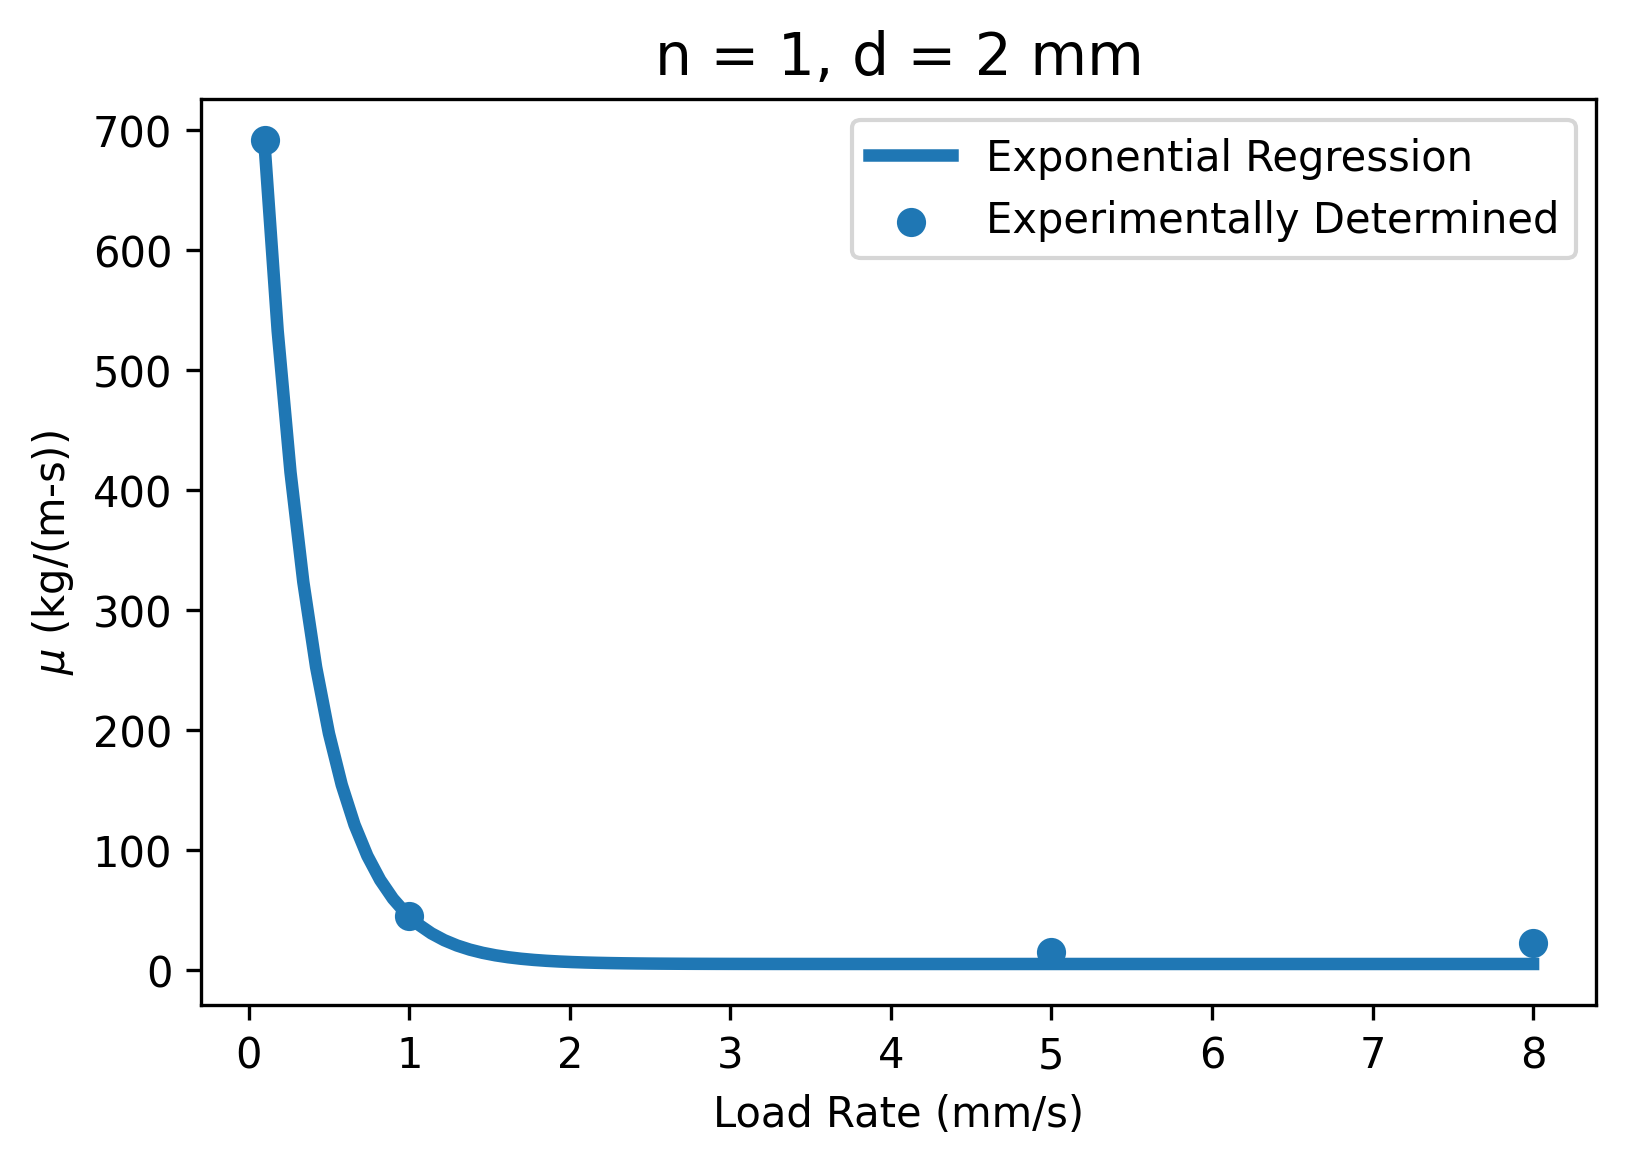

r-squared for mu: 0.998570726988955
mu at 5.5 m/s: 4.76585402017376 kg/(m-s)


<ipython-input-91-0a0f694c5425>:74: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x)+c


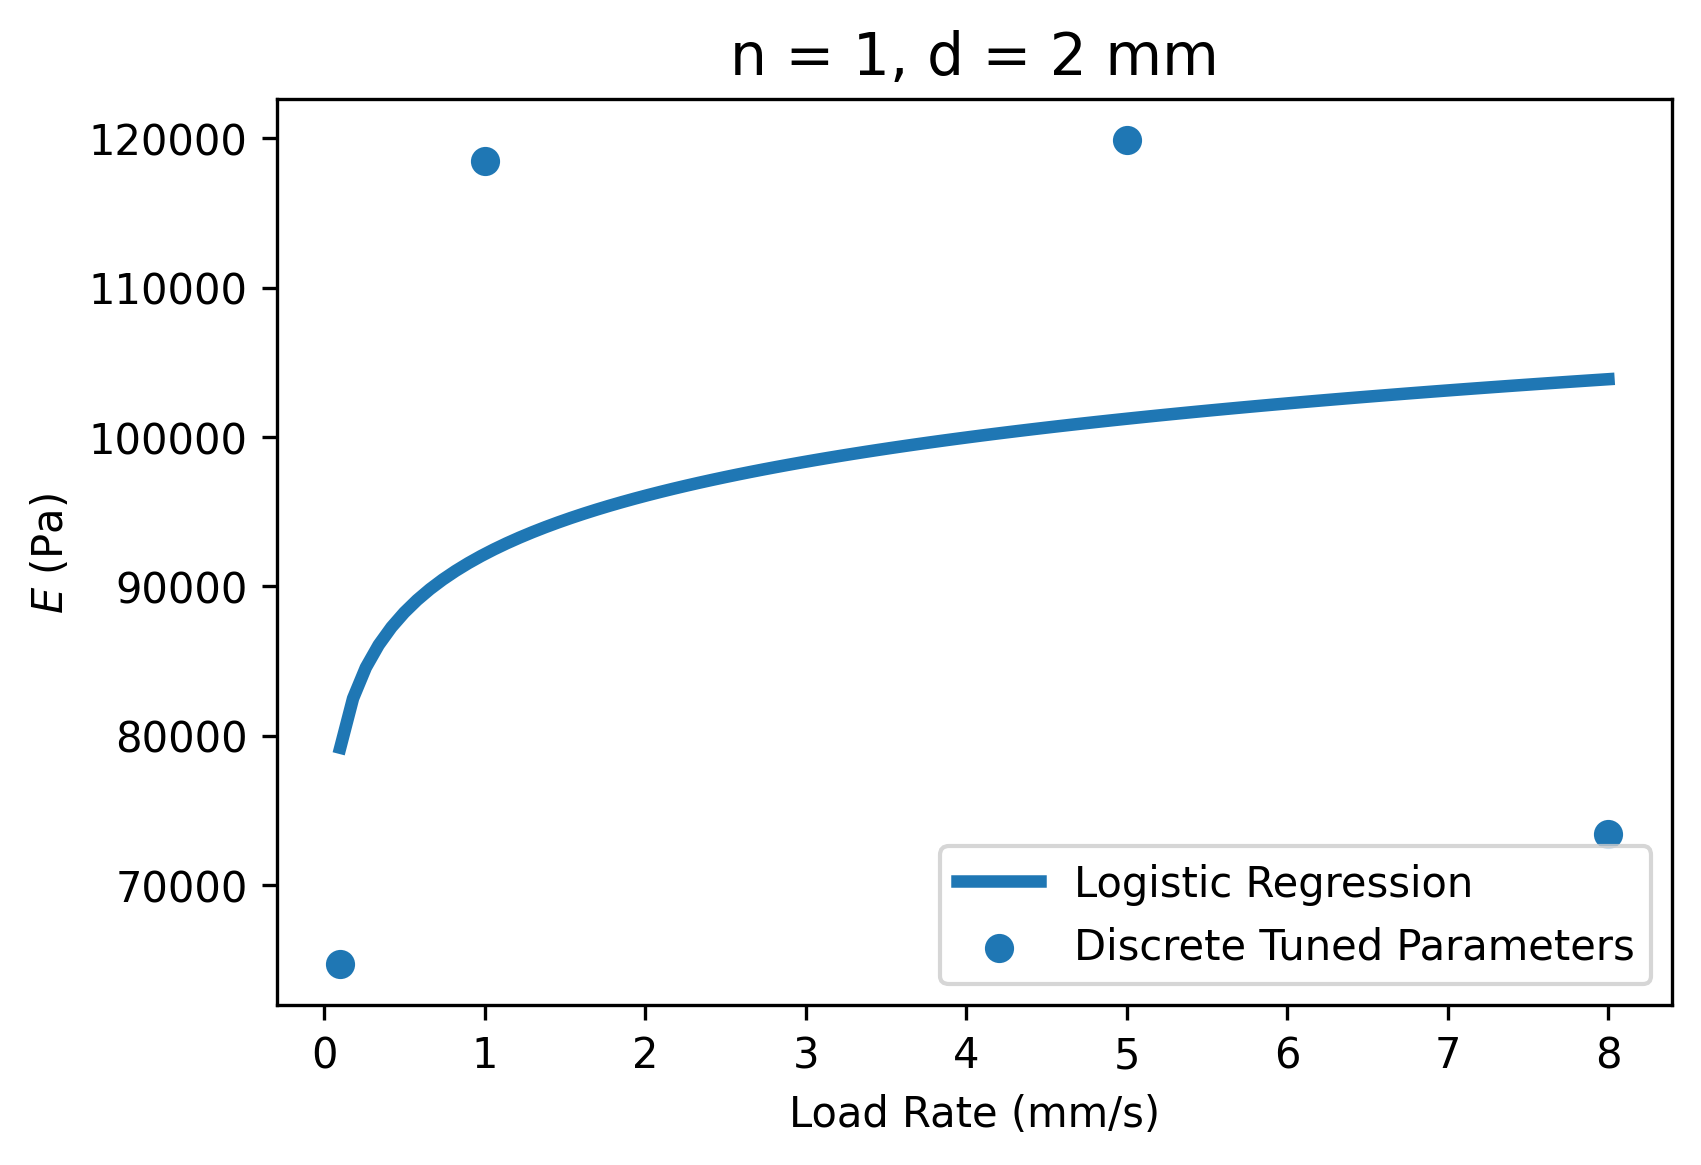

r-squared for E: 0.1460259983876384
E at 5.5 m/s: 140.65123595607693 kPa


In [91]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"

energies = []

sim_energies = []
exp_energies = []
for damper in dampers:
  sim_energies.append(damper.energy)
  exp_energies.append(damper.left_point_integrate(\
                      damper.test_disp, damper.test_force))

plt.plot(test_speeds, sim_energies, linewidth = 3, label = "Simulation")
plt.scatter(test_speeds, exp_energies, linewidth = 3, label = "Experiment")
plt.title("n = 1, d = 2 mm", fontsize = 14)
plt.xlabel("Load Rate (m/s)")
plt.ylabel("Absorbed Energy (J)")
plt.legend()
plt.show()

# plot k vs speed (k only needs to be worked with for this prototype for market comparison)
k_dict = {0.1E-3:1.20372919E3, 1E-3:1.41932069E3, 5E-3:1.86683541E3, 8E-3:2.10151015E3} # N/m
plt.scatter(np.array([*k_dict.keys()])*1E3, k_dict.values(), label = 'Exp 0 Data')
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("k (N/m)")

# logistic growth fit to k
def func(x, a, b, c):
    return a*np.log(b*x)+c

params, _ = curve_fit(func, np.array([*k_dict.keys()])*1E3, np.array([*k_dict.values()]))
a, b, c = params[0], params[1], params[2]
x_sample = np.linspace(0.1, 8, 100)
yfit = lambda x: a*np.log(x*b)+c
plt.plot(x_sample, yfit(x_sample), linewidth = 3, label = 'Logistic Regression')
plt.legend(loc = 4)
plt.title('Logistic regression to extrapolate k')
plt.show()
print('r-squared for k: {}'.format(r2_score(np.array([*k_dict.values()]), yfit(np.array([*k_dict.keys()])*1E3))))
print('k at 5.5 m/s: {} N/m'.format(yfit(5500)))
k_5500 = yfit(5500)

# plot mu (experimental) vs speed
plt.scatter(test_speeds, test_mus, label = 'Experimentally Determined')
plt.title("n = 1, d = 2 mm", fontsize = 14)
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("$\mu$ (kg/(m-s))")

# exp decay fit to mu
def func(x, a, b, c):
    return a*np.exp(-b*x)+c 

params, _ = curve_fit(func, test_speeds, vals[:,0])
a, b, c = params[0], params[1], params[2]
x_sample = np.linspace(0.1, 8, 100)
yfit = lambda x: a*np.exp(-x*b)+c
plt.plot(x_sample, yfit(x_sample), linewidth = 3, label = 'Exponential Regression')
plt.legend()
plt.show()
print('r-squared for mu: {}'.format(r2_score(test_mus, a*np.exp(np.array(test_speeds)*-b)+c)))
print('mu at 5.5 m/s: {} kg/(m-s)'.format(yfit(5500)))
mu_5500 = yfit(5500)

# plot E vs speed
plt.scatter(test_speeds, vals[:,1], label = 'Discrete Tuned Parameters')
plt.title("n = 1, d = 2 mm", fontsize = 14)
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("$E$ (Pa)")

# logistic growth fit to E
def func(x, a, b, c):
    return a*np.log(b*x)+c

params, _ = curve_fit(func, test_speeds, vals[:,1])
a, b, c = params[0], params[1], params[2]
x_sample = np.linspace(0.1, 8, 100)
yfit = lambda x: a*np.log(x*b)+c
plt.plot(x_sample, yfit(x_sample), linewidth = 3, label = 'Logistic Regression')
plt.legend(loc = 4)
plt.show()
print('r-squared for E: {}'.format(r2_score(vals[:,1], a*np.log(np.array(test_speeds)*b)+c)))
print('E at 5.5 m/s: {} kPa'.format(yfit(5500)*1E-3))
E_5500 = yfit(5500)*1E-3

sim_energies3 = sim_energies
exp_energies3 = exp_energies

Absorbed energy at 5500 mm/s: 2.934624547987645 kJ


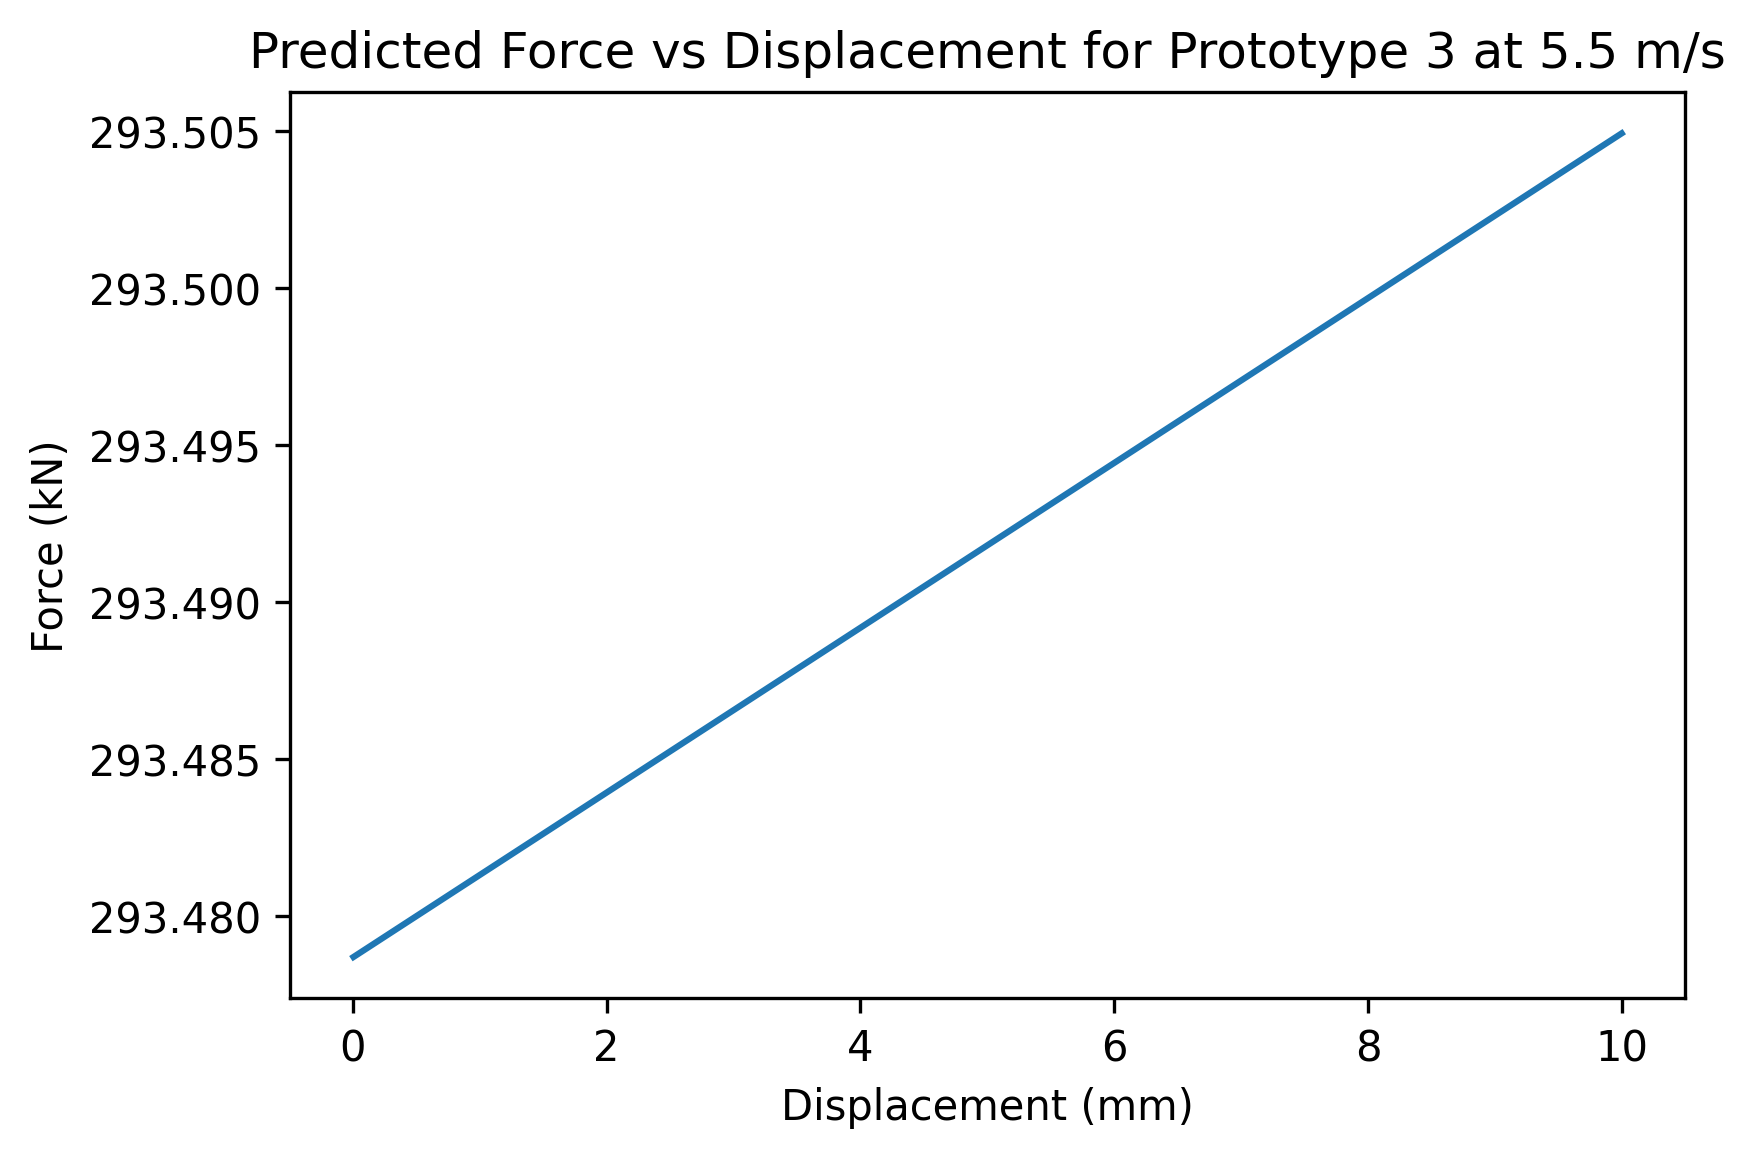

In [92]:
# Using resulting k, mu, and E at 8 m/s to find stress-strain and energy absorbed at 8 m/s load rate
%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"
import numpy as np

n = 1
d = 2E-3 # m
rho = 1300 # kg/m^3 (toothpaste)
D = (20 + 23.5)/2 * 1E-3 # m
u = 5.5 # m/s
test_damper = damper(d, D, mu_5500, E_5500, rho, n)

stroke_length = 10 # mm
dt = 1e-6 # s
t_total = stroke_length/(u*1e3) # s
n_iterations = int(t_total/dt)
for i in range(n_iterations):
  test_damper.step(u, dt)
plt.plot(np.array(test_damper.disp_history)*1e3, np.array(test_damper.force_history)*1e-3)
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain')
plt.title('Predicted Force vs Displacement for Prototype 3 at 5.5 m/s')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (kN)')
print('Absorbed energy at 5500 mm/s: {} kJ'.format(test_damper.energy*1E-3))

/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:60: RuntimeWarning: invalid value encountered in double_scalars
  A_Cd = (19000*self.beta/self.ReD)**0.8
/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:67: RuntimeWarning: invalid value encountered in double_scalars
  + 0.000521*(10**6*self.beta/self.ReD)**0.7 \
/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:68: RuntimeWarning: invalid value encountered in double_scalars
  + (0.0188 + 0.0063*A_Cd)*self.beta**(3.5)*(10**6/self.ReD)**0.3 \


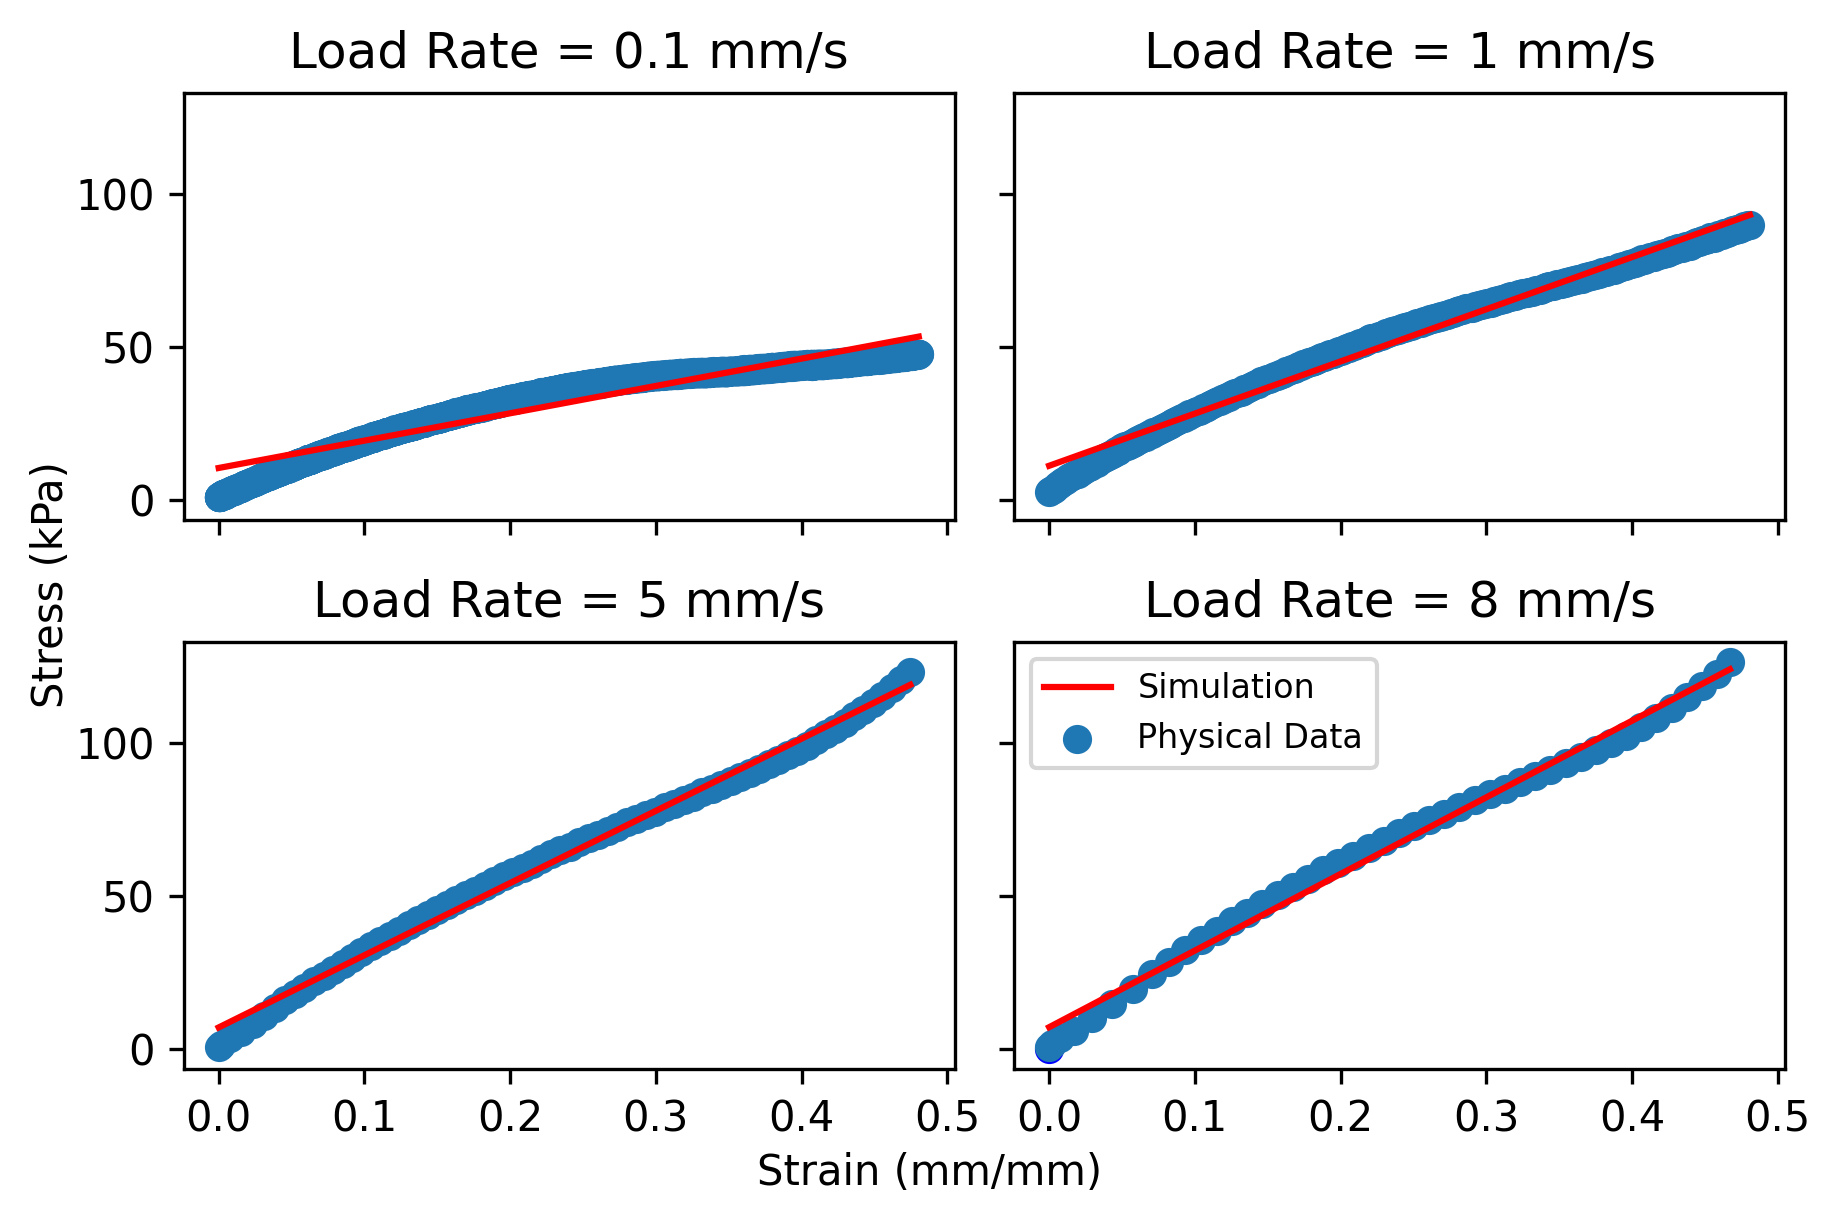

In [93]:
# Experiment 4
%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"
import numpy as np

test_speeds = [0.1, 1, 5, 8] # mm/s

dampers = []
vals = np.zeros((len(test_speeds), 2))

for i in range(len(test_speeds)):
  n = 3
  exp_num = 4
  d = 1E-3 # m
  rho = 1300 # kg/m^3 (toothpaste)
  D = (20 + 23.5)/2 * 1E-3 # m
  u = test_speeds[i] # mm/s
  vals[i,:] = optimize(u, n, exp_num, d, rho, D)

test_speeds = [0.1, 1, 5, 8] # mm/s

d = 1E-3 # m
D = (20 + 23.5)/2 * 1E-3 # m
rho = 1300 # kg/m^3 (toothpaste)
n = 3

dampers = []

fig, axs = plt.subplots(2, 2, sharex = True, sharey = True)

index = [[0,0], [0,1], [1,0], [1,1]]

custom_lines = [plt.plot([0],[0],'r'), plt.scatter([0],[0],c = 'b')]

for i in range(len(test_speeds)):
  mu, E = vals[i, 0], vals[i, 1]
  dampers.append(damper(d, D, mu, E, rho, n, exp = 4))

for i in reversed(range(len(test_speeds))):
  u = test_speeds[i] # m/s
  dampers[i].match_test(u)
  axs[index[i][0], index[i][1]].scatter(dampers[i].test_strain, dampers[i].test_stress, label = "Physical Data")
  axs[index[i][0], index[i][1]].plot(dampers[i].strain_history, dampers[i].stress_history, 'r', label = "Simulation")
  axs[index[i][0], index[i][1]].set_title('Load Rate = {} mm/s'.format(u))
  plt.legend(prop={'size': 8})
  td.append(np.array((test_speeds[i]*np.ones((dampers[i].test_strain.size)), dampers[i].test_strain, dampers[i].test_stress)))

fig.text(0.5, 0.0, 'Strain (mm/mm)', ha='center')
fig.text(0.0, 0.5, 'Stress (kPa)', va='center', rotation='vertical')
fig.tight_layout()

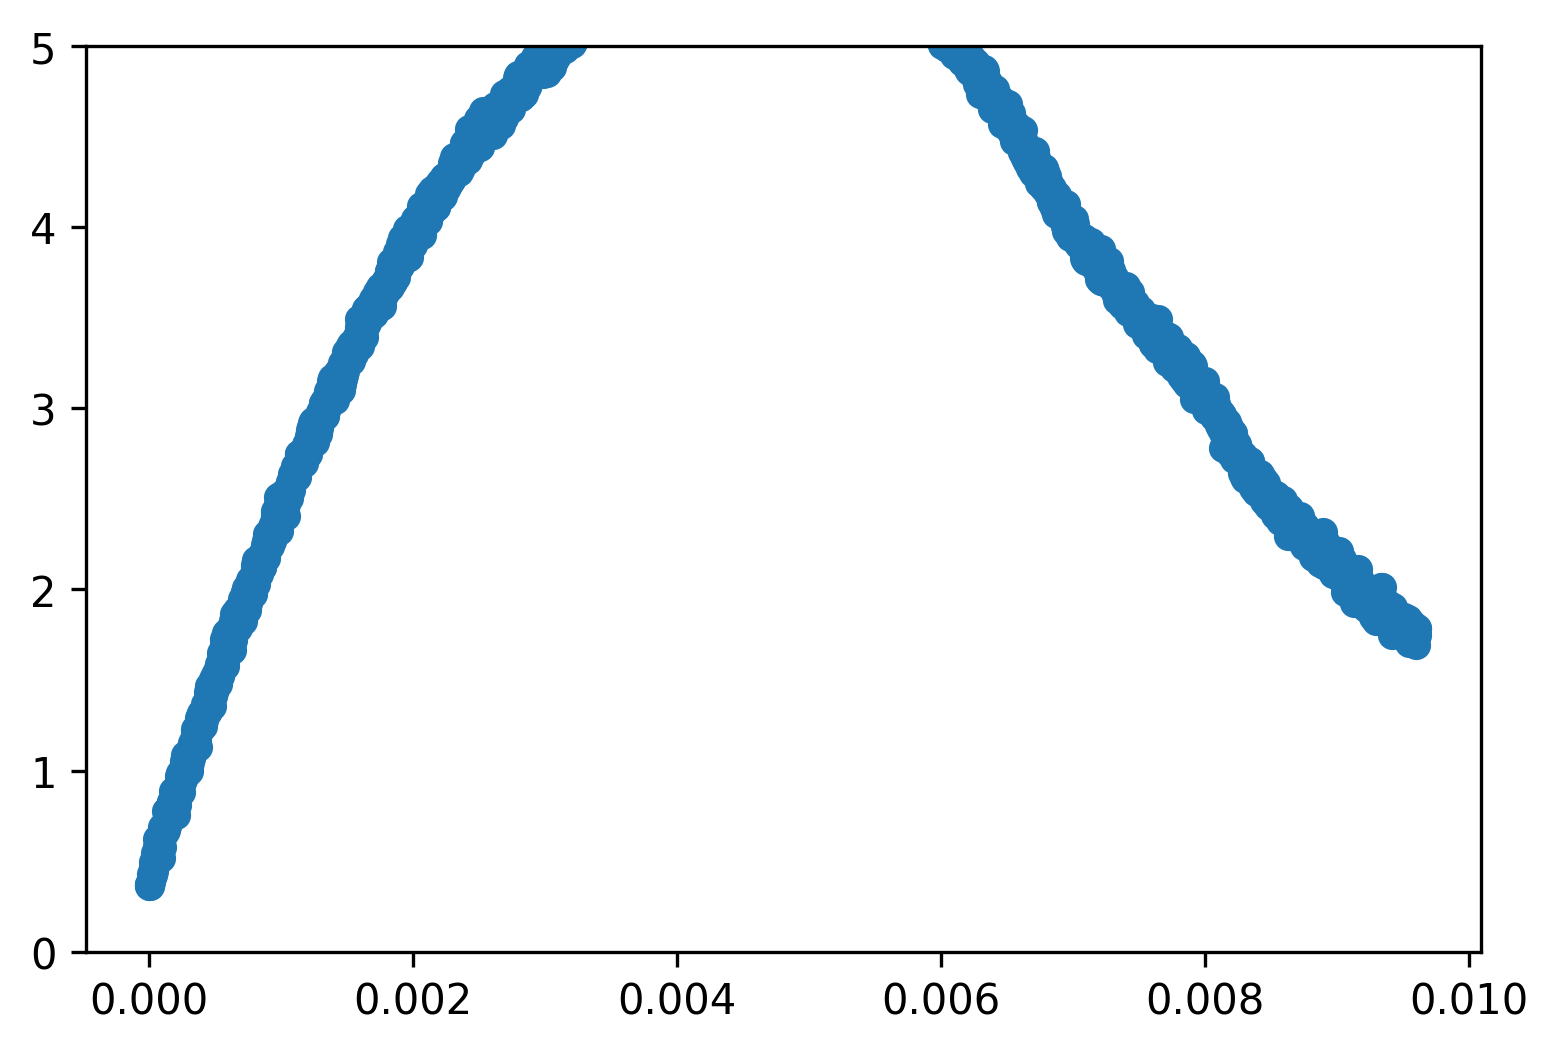

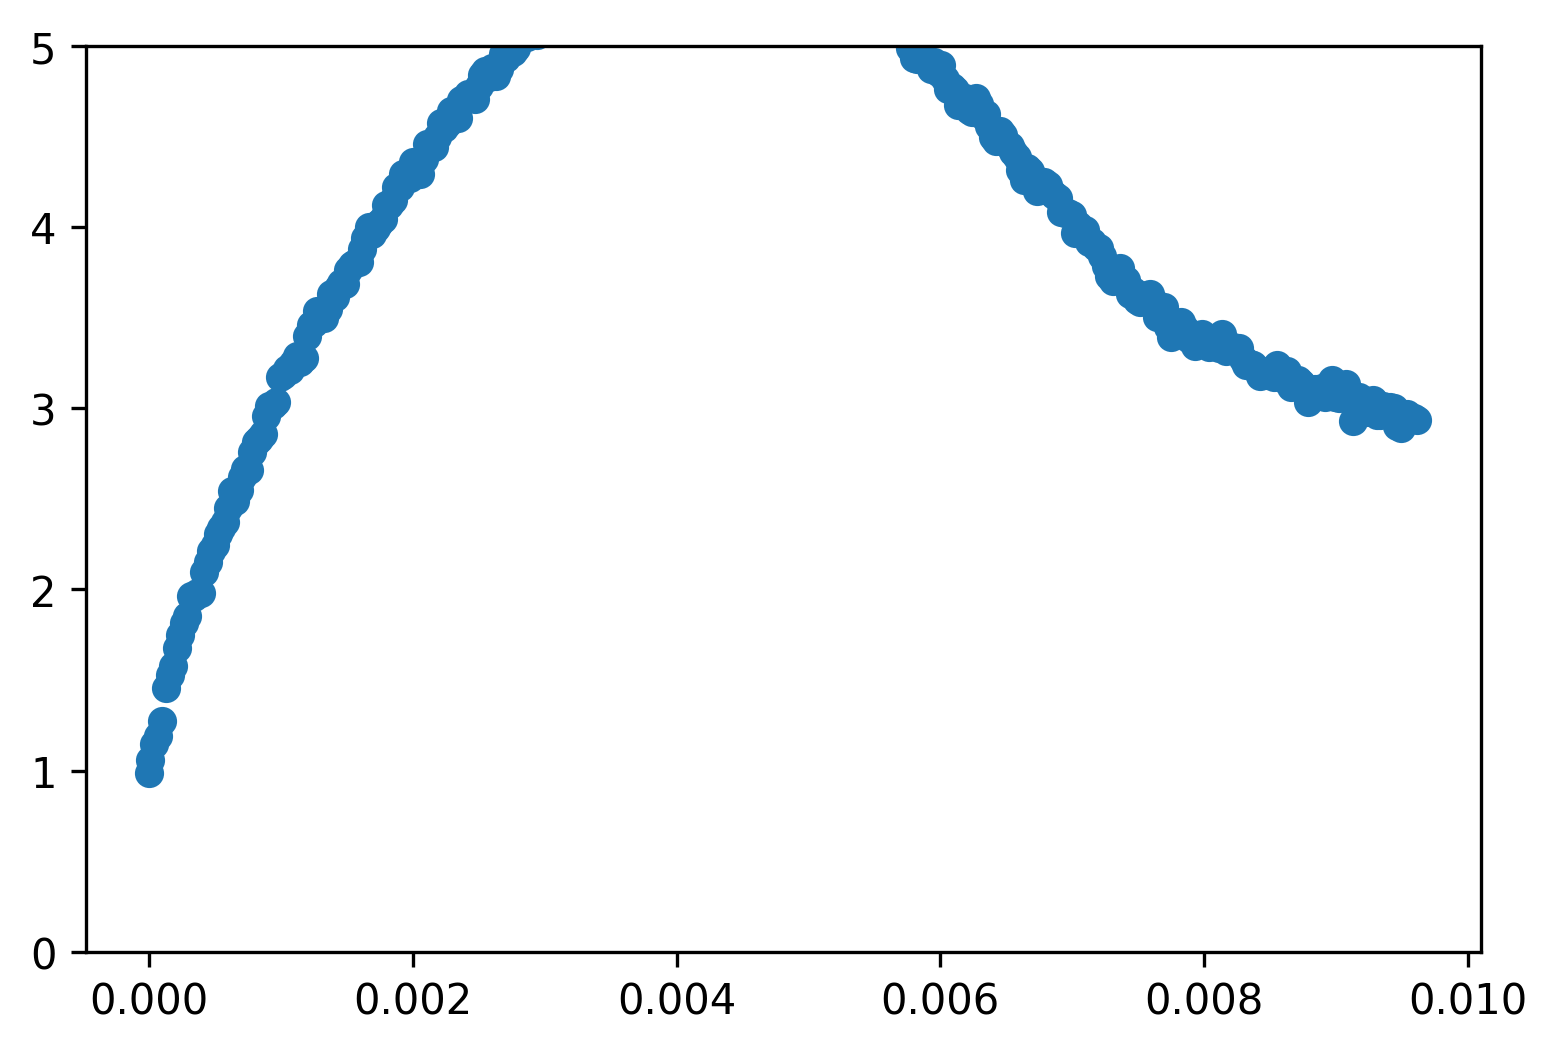

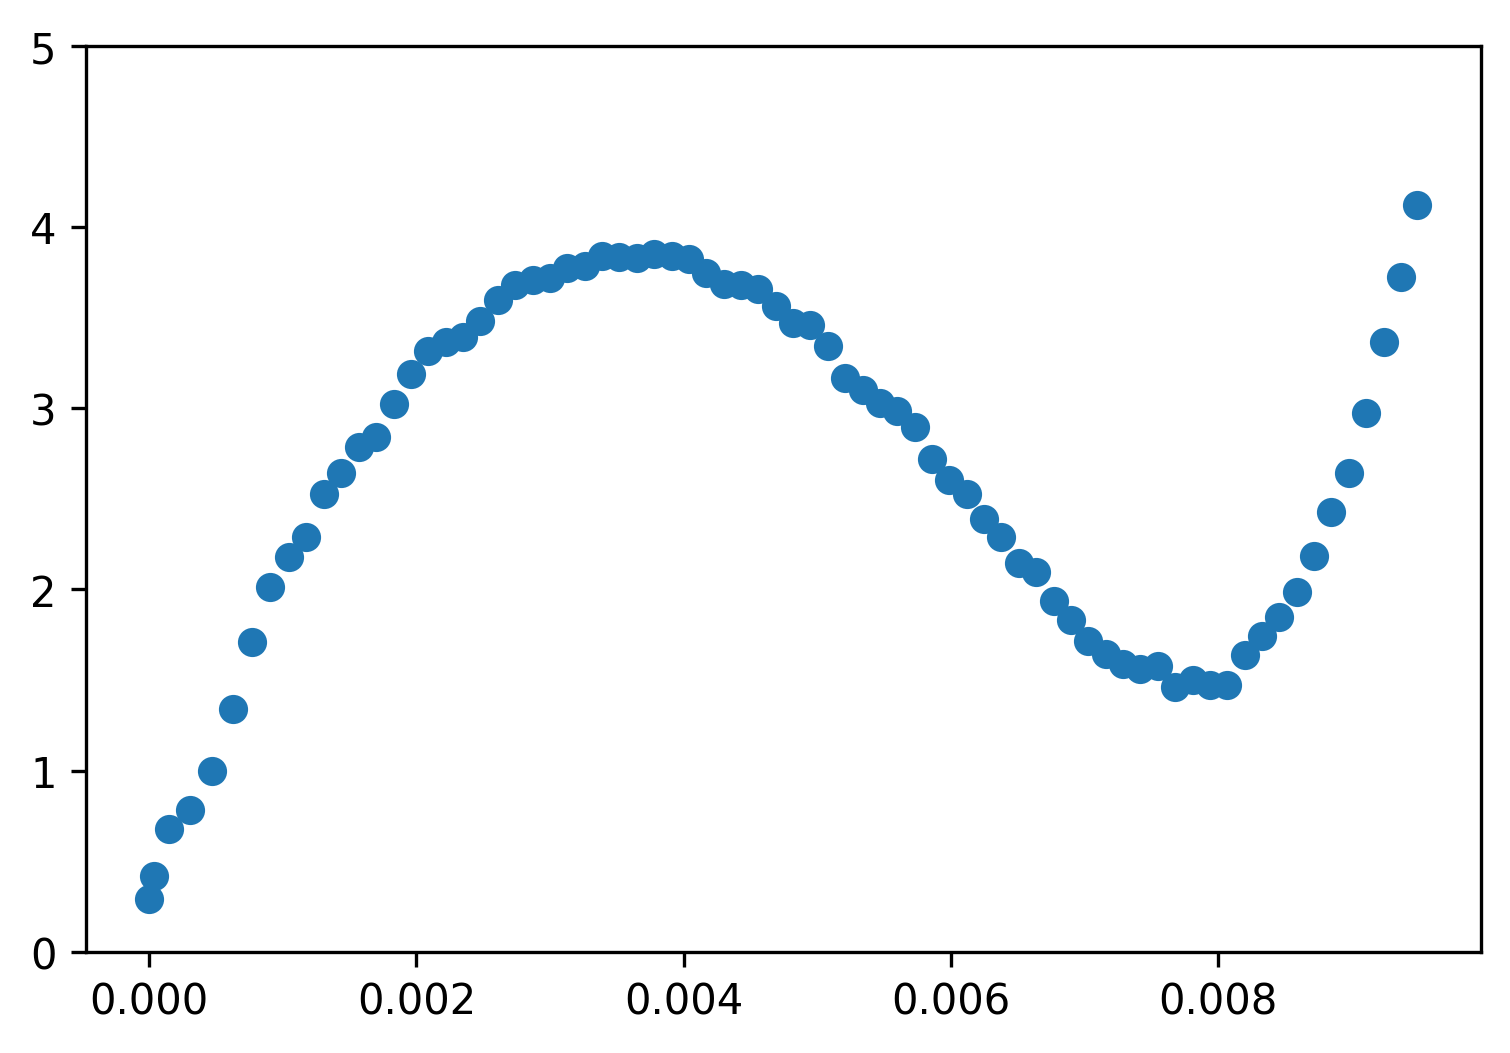

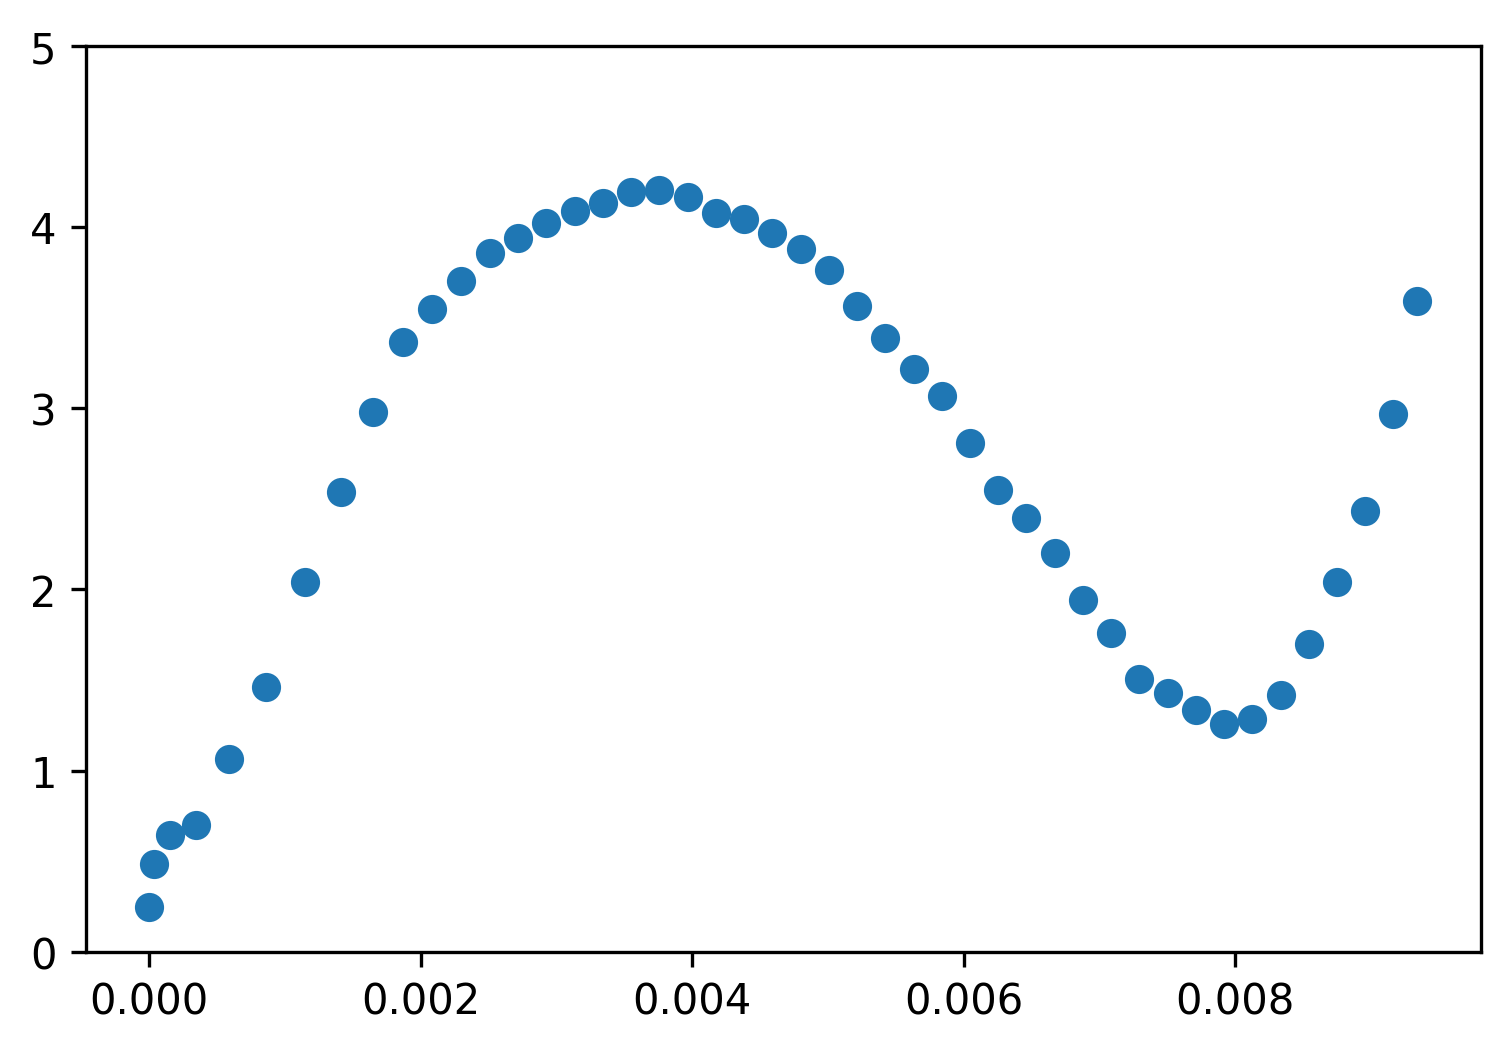

[362.0630439169533, 38.69344652330319, 4.9385189387708905, 3.122567957346854]


In [94]:
# Exp 4 mus
test_mus = []
for i in range(len(test_speeds)):
  total_force = np.array(dampers[i].test_force)
  spring_force = np.array(dampers[i].test_disp)*dampers[i].k
  disp = np.array(dampers[i].test_disp)
  plt.scatter(disp, total_force - spring_force)
  plt.ylim([0,5])
  plt.show()
  viscous_force = (np.average(total_force - spring_force)) # N
  mu = viscous_force*np.pi*(dampers[i].d/2)**4/(8*dampers[i].t*dampers[i].Q*dampers[i].a) # kg/(m-s)
  test_mus.append(mu)

print(test_mus)

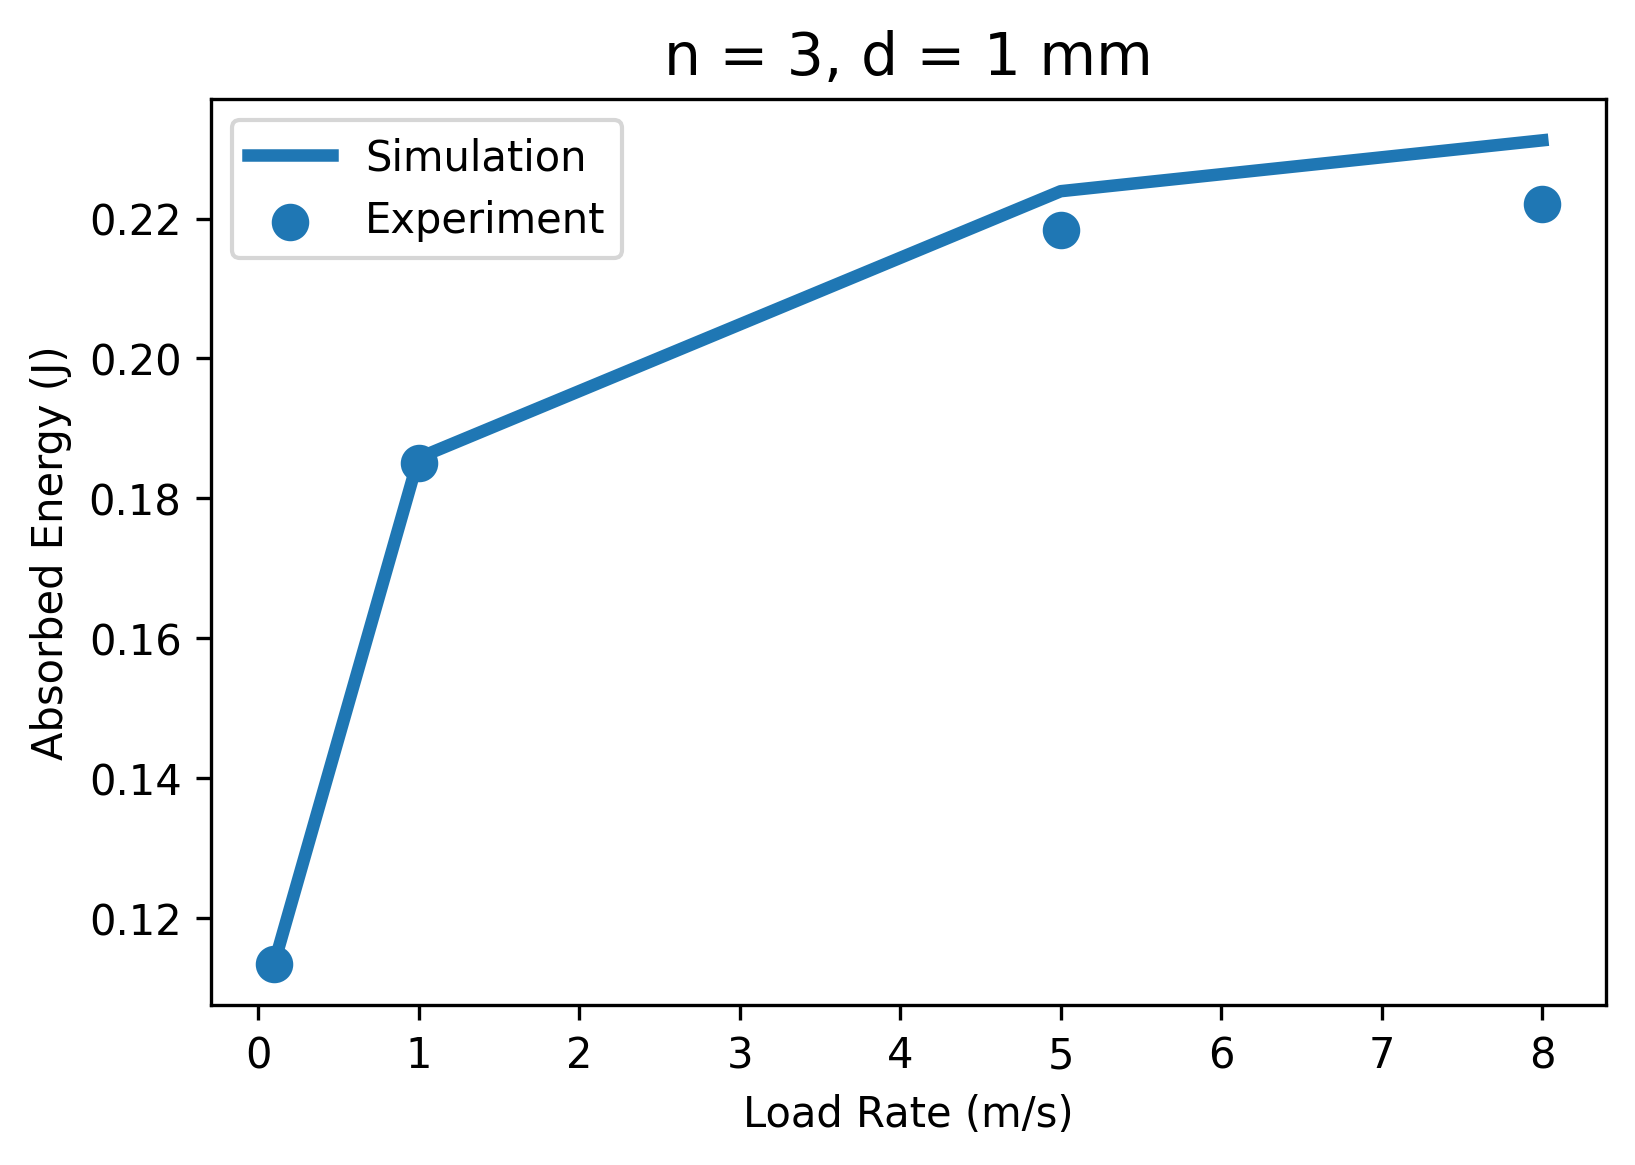

<ipython-input-95-d1118c140844>:28: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x)+c


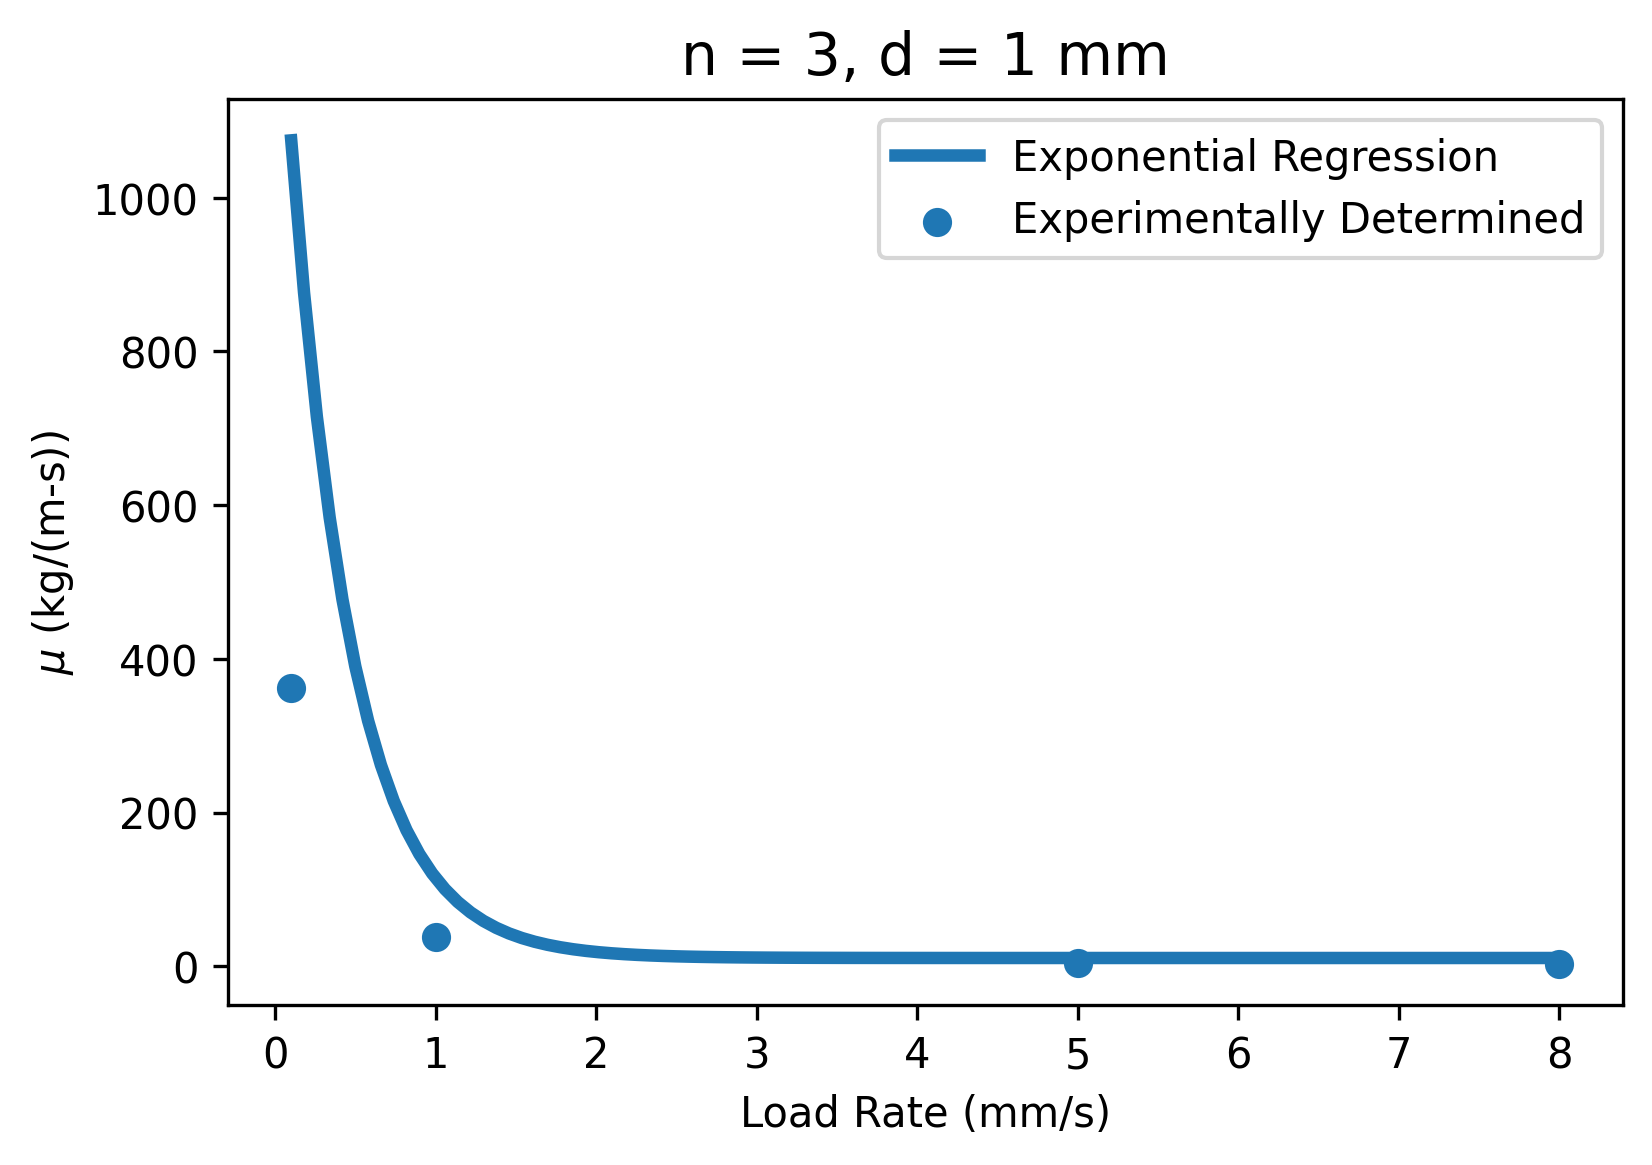

r-squared for mu: -4.6553731471586035
mu at 8 m/s: 10.910183161568124 kg/(m-s)


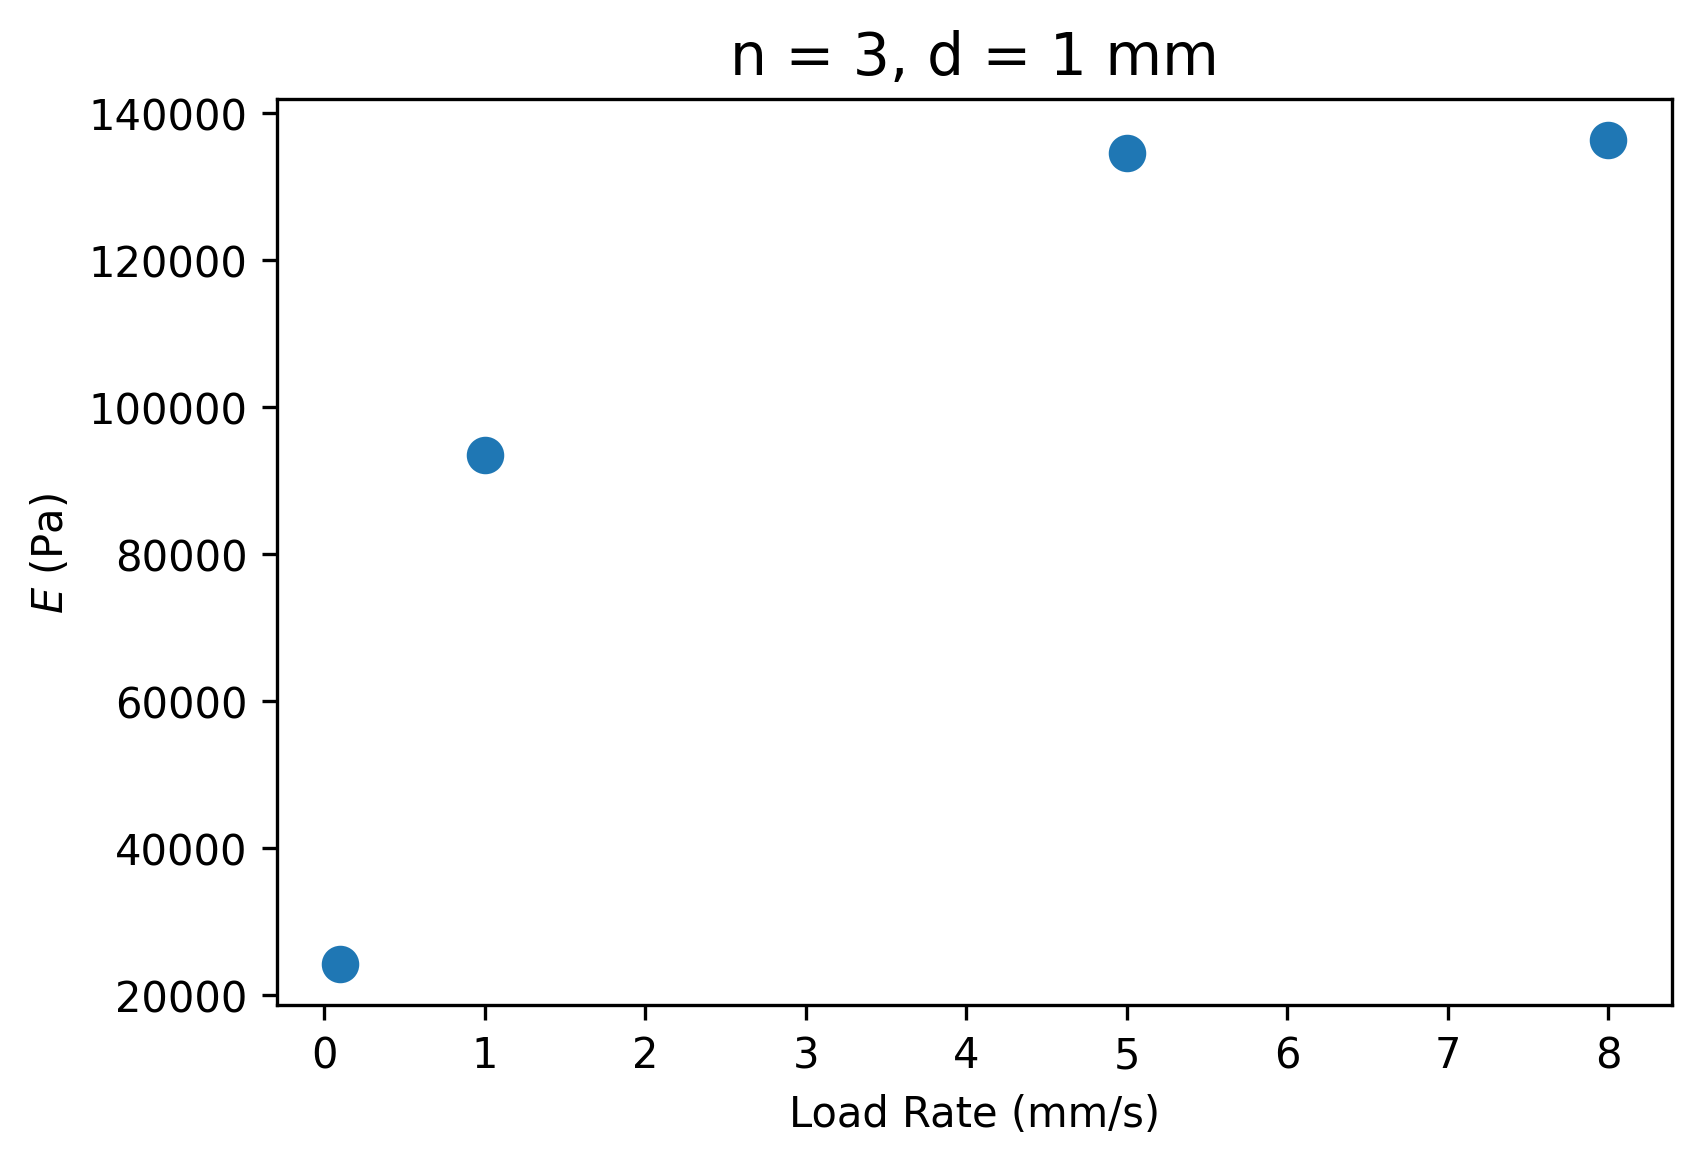

In [95]:
%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"

energies = []

sim_energies = []
exp_energies = []
for damper in dampers:
  sim_energies.append(damper.energy)
  exp_energies.append(damper.left_point_integrate(\
                      damper.test_disp, damper.test_force))

plt.plot(test_speeds, sim_energies, linewidth = 3, label = "Simulation")
plt.scatter(test_speeds, exp_energies, linewidth = 3, label = "Experiment")
plt.title("n = 3, d = 1 mm", fontsize = 14)
plt.xlabel("Load Rate (m/s)")
plt.ylabel("Absorbed Energy (J)")
plt.legend()
plt.show()

# plot mu vs speed
plt.scatter(test_speeds, test_mus, label = 'Experimentally Determined')
plt.title("n = 3, d = 1 mm", fontsize = 14)
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("$\mu$ (kg/(m-s))")

# exp decay fit to mu
def func(x, a, b, c):
    return a*np.exp(-b*x)+c 

params, _ = curve_fit(func, test_speeds, vals[:,0])
a, b, c = params[0], params[1], params[2]
x_sample = np.linspace(0.1, 8, 100)
yfit = lambda x: a*np.exp(-x*b)+c
plt.plot(x_sample, yfit(x_sample), linewidth = 3, label = 'Exponential Regression')
plt.legend()
plt.show()
print('r-squared for mu: {}'.format(r2_score(test_mus, a*np.exp(np.array(test_speeds)*-b)+c)))
print('mu at 8 m/s: {} kg/(m-s)'.format(yfit(8000)))
mu_8000 = yfit(8000)

# plot E vs speed
plt.scatter(test_speeds, vals[:,1], linewidth = 3)
plt.title("n = 3, d = 1 mm", fontsize = 14)
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("$E$ (Pa)")
plt.show()

sim_energies4 = sim_energies
exp_energies4 = exp_energies

/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:60: RuntimeWarning: invalid value encountered in double_scalars
  A_Cd = (19000*self.beta/self.ReD)**0.8
/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:67: RuntimeWarning: invalid value encountered in double_scalars
  + 0.000521*(10**6*self.beta/self.ReD)**0.7 \
/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:68: RuntimeWarning: invalid value encountered in double_scalars
  + (0.0188 + 0.0063*A_Cd)*self.beta**(3.5)*(10**6/self.ReD)**0.3 \


<Figure size 1800x1200 with 0 Axes>

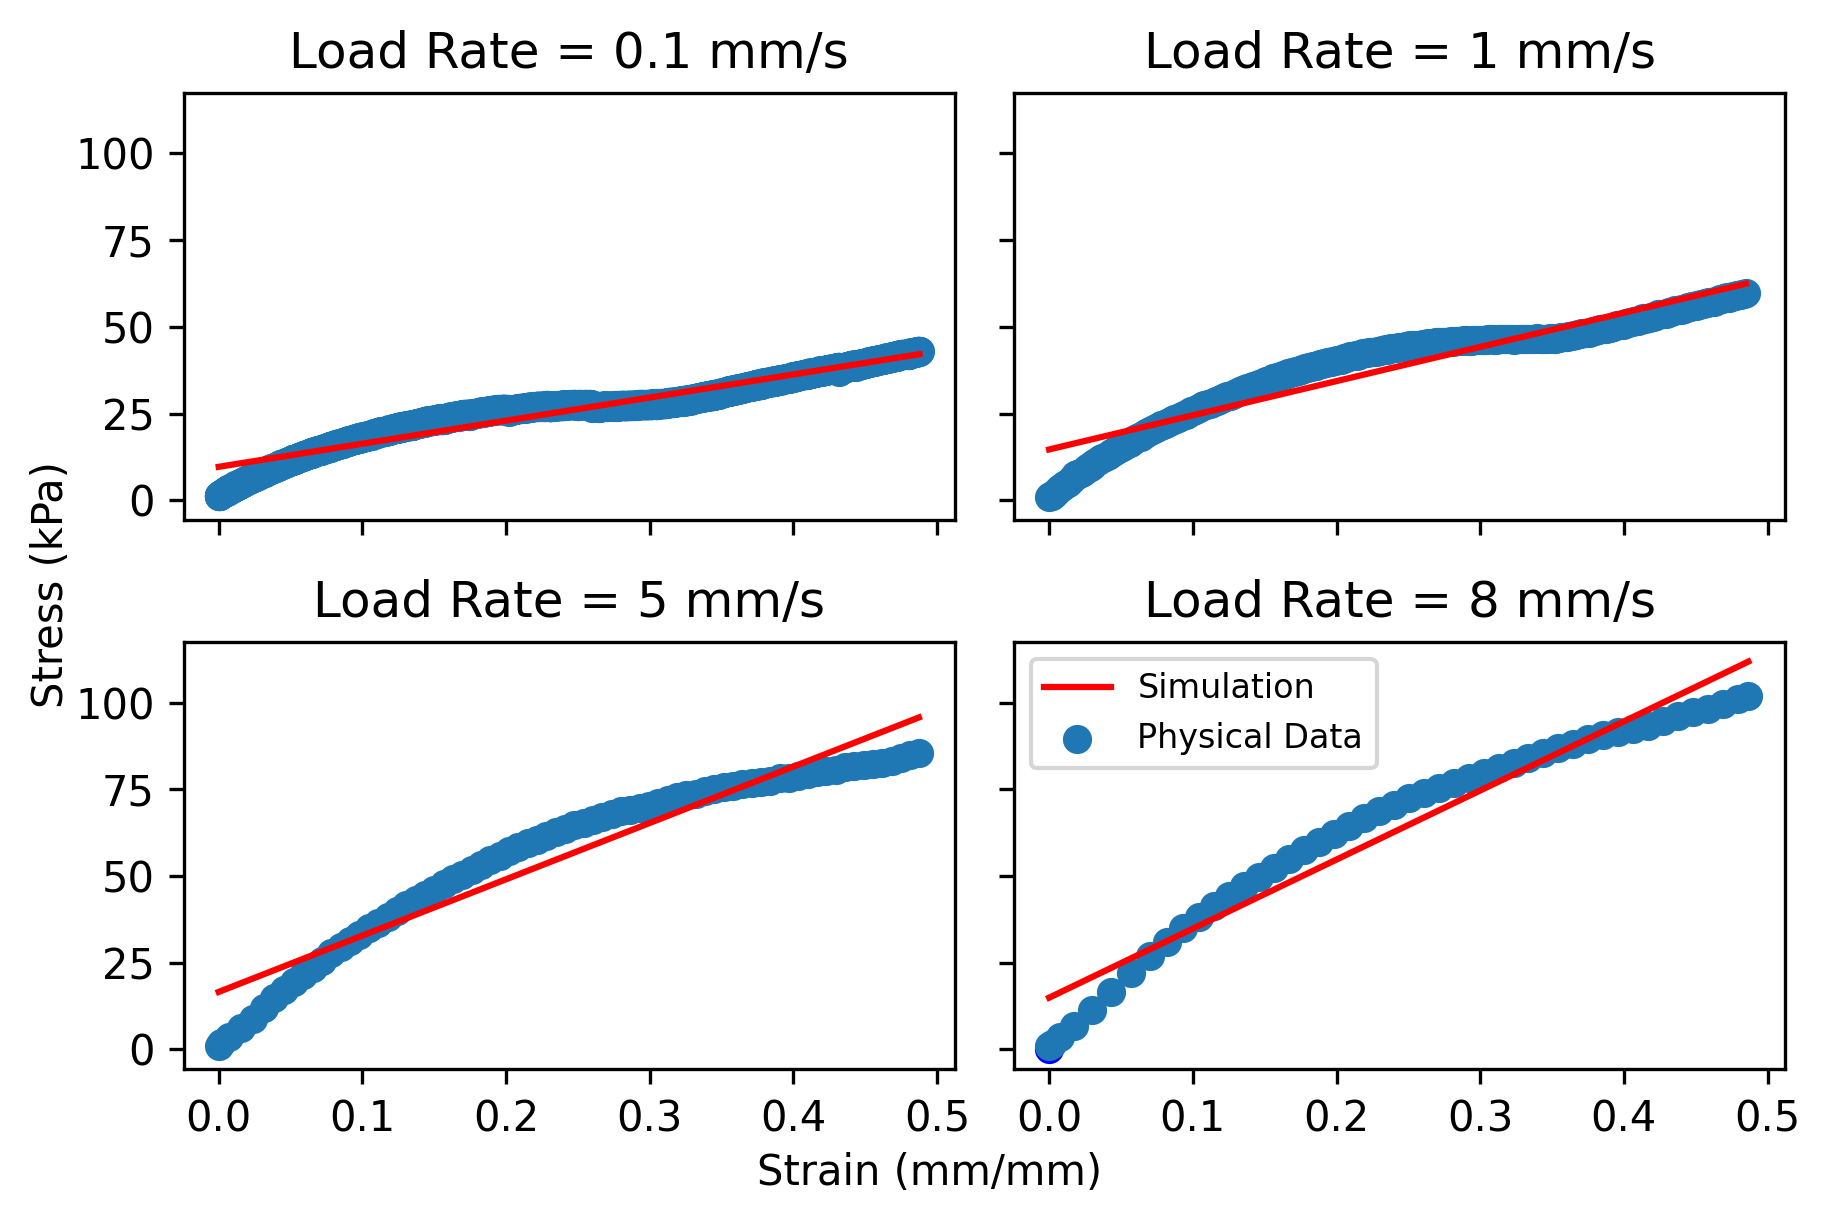

In [96]:
# Experiment 5
%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"
import numpy as np

test_speeds = [0.1, 1, 5, 8] # mm/s

dampers = []
vals = np.zeros((len(test_speeds), 2))

for i in range(len(test_speeds)):
  n = 3
  exp_num = 5
  d = 2E-3 # m
  rho = 1300 # kg/m^3 (toothpaste)
  D = (20 + 23.5)/2 * 1E-3 # m
  u = test_speeds[i] # mm/s
  vals[i,:] = optimize(u, n, exp_num, d, rho, D)

test_speeds = [0.1, 1, 5, 8] # mm/s

d = 2E-3 # m
D = (20 + 23.5)/2 * 1E-3 # m
rho = 1300 # kg/m^3 (toothpaste)
n = 3

dampers = []

td = []

fig, axs = plt.subplots(2, 2, sharex = True, sharey = True)

index = [[0,0], [0,1], [1,0], [1,1]]

custom_lines = [plt.plot([0],[0],'r'), plt.scatter([0],[0],c = 'b')]

for i in range(len(test_speeds)):
  mu, E = vals[i, 0], vals[i, 1]
  dampers.append(damper(d, D, mu, E, rho, n, exp = 5))

for i in reversed(range(len(test_speeds))):
  u = test_speeds[i] # m/s
  dampers[i].match_test(u)
  axs[index[i][0], index[i][1]].scatter(dampers[i].test_strain, dampers[i].test_stress, label = "Physical Data")
  axs[index[i][0], index[i][1]].plot(dampers[i].strain_history, dampers[i].stress_history, 'r', label = "Simulation")
  axs[index[i][0], index[i][1]].set_title('Load Rate = {} mm/s'.format(u))
  plt.legend(prop={'size': 8})
  td.append(np.array((test_speeds[i]*np.ones((dampers[i].test_strain.size)), dampers[i].test_strain, dampers[i].test_stress)))

fig.text(0.5, 0.0, 'Strain (mm/mm)', ha='center')
fig.text(0.0, 0.5, 'Stress (kPa)', va='center', rotation='vertical')
fig.tight_layout()

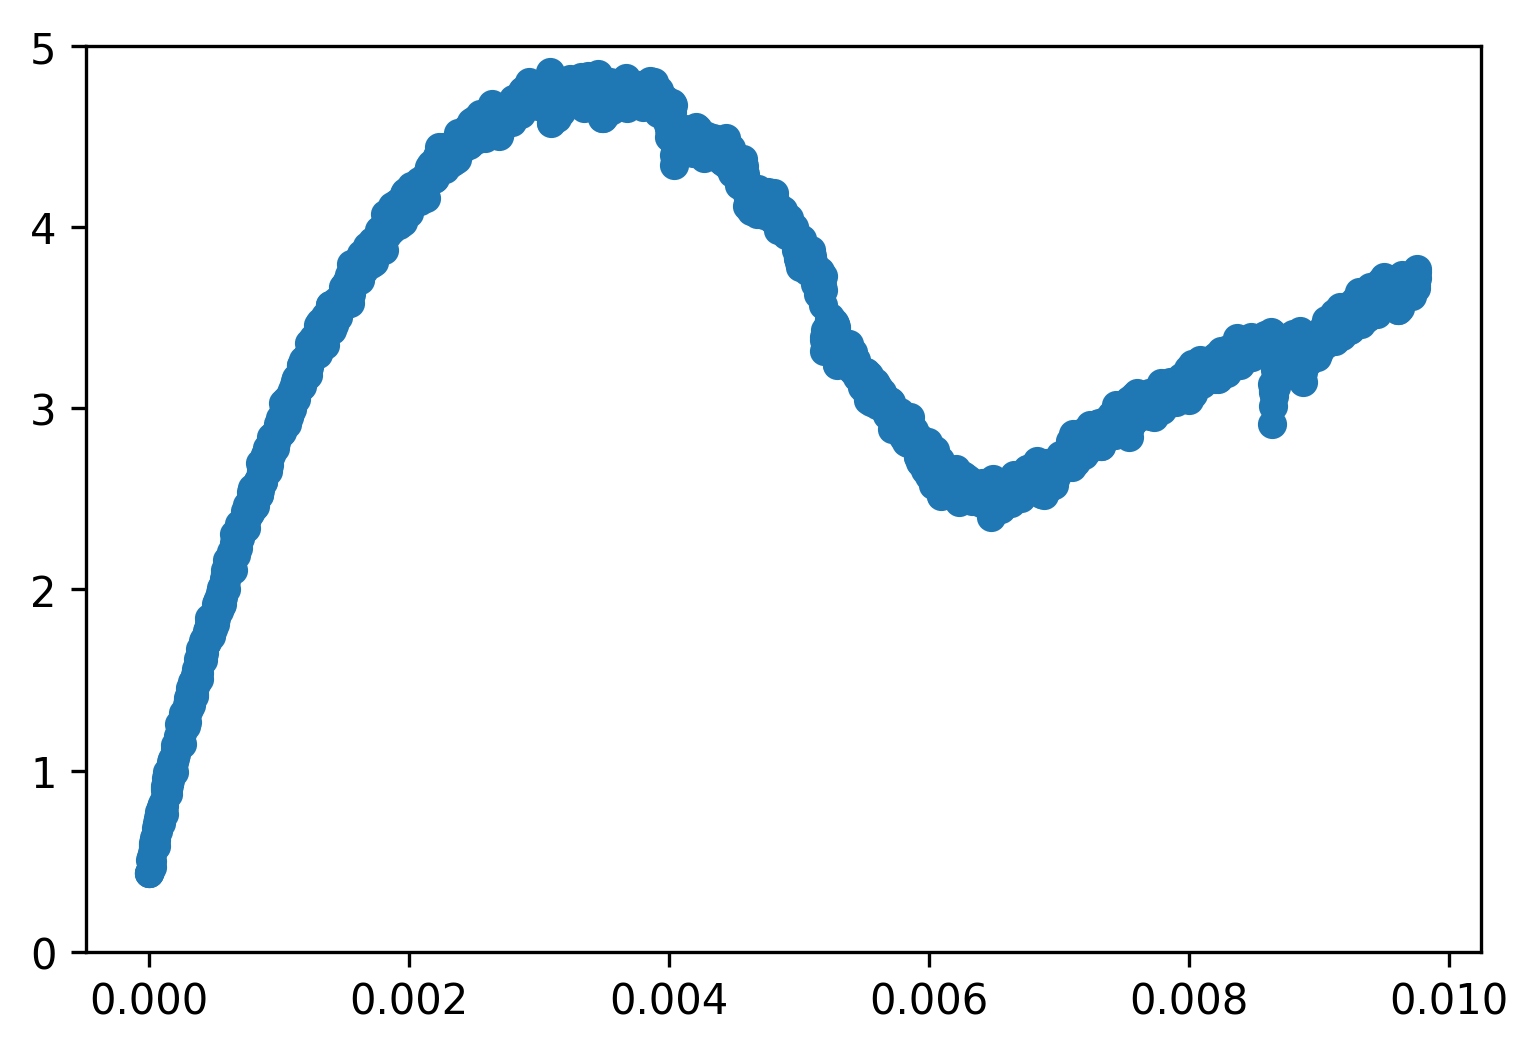

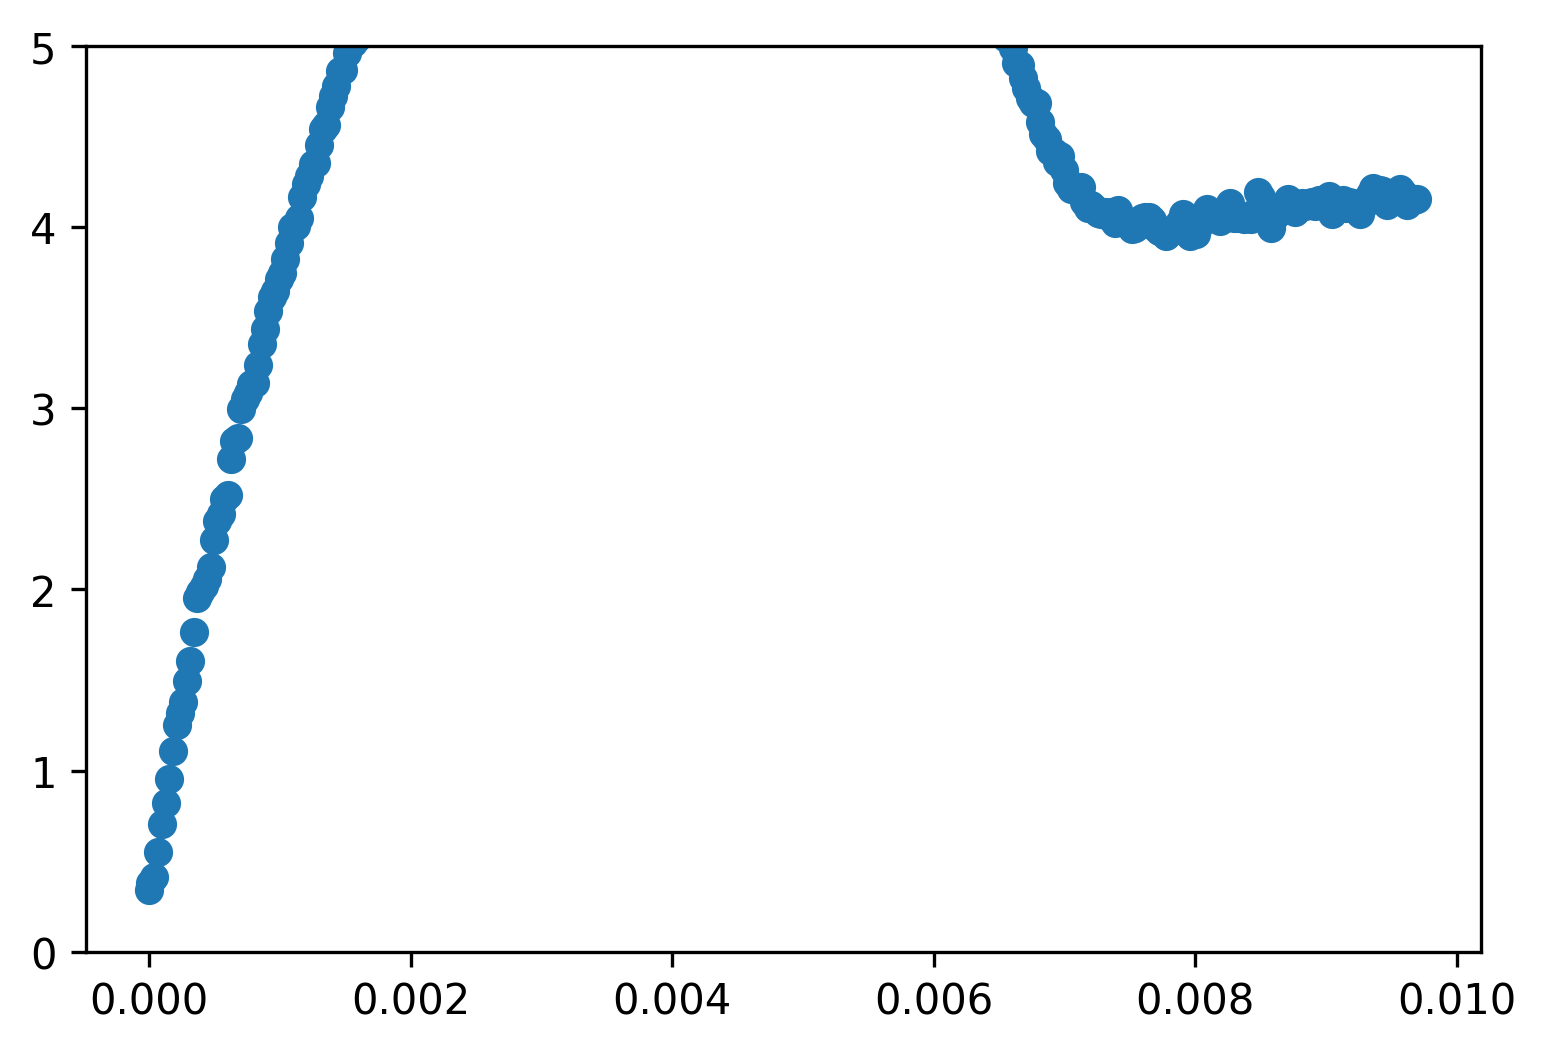

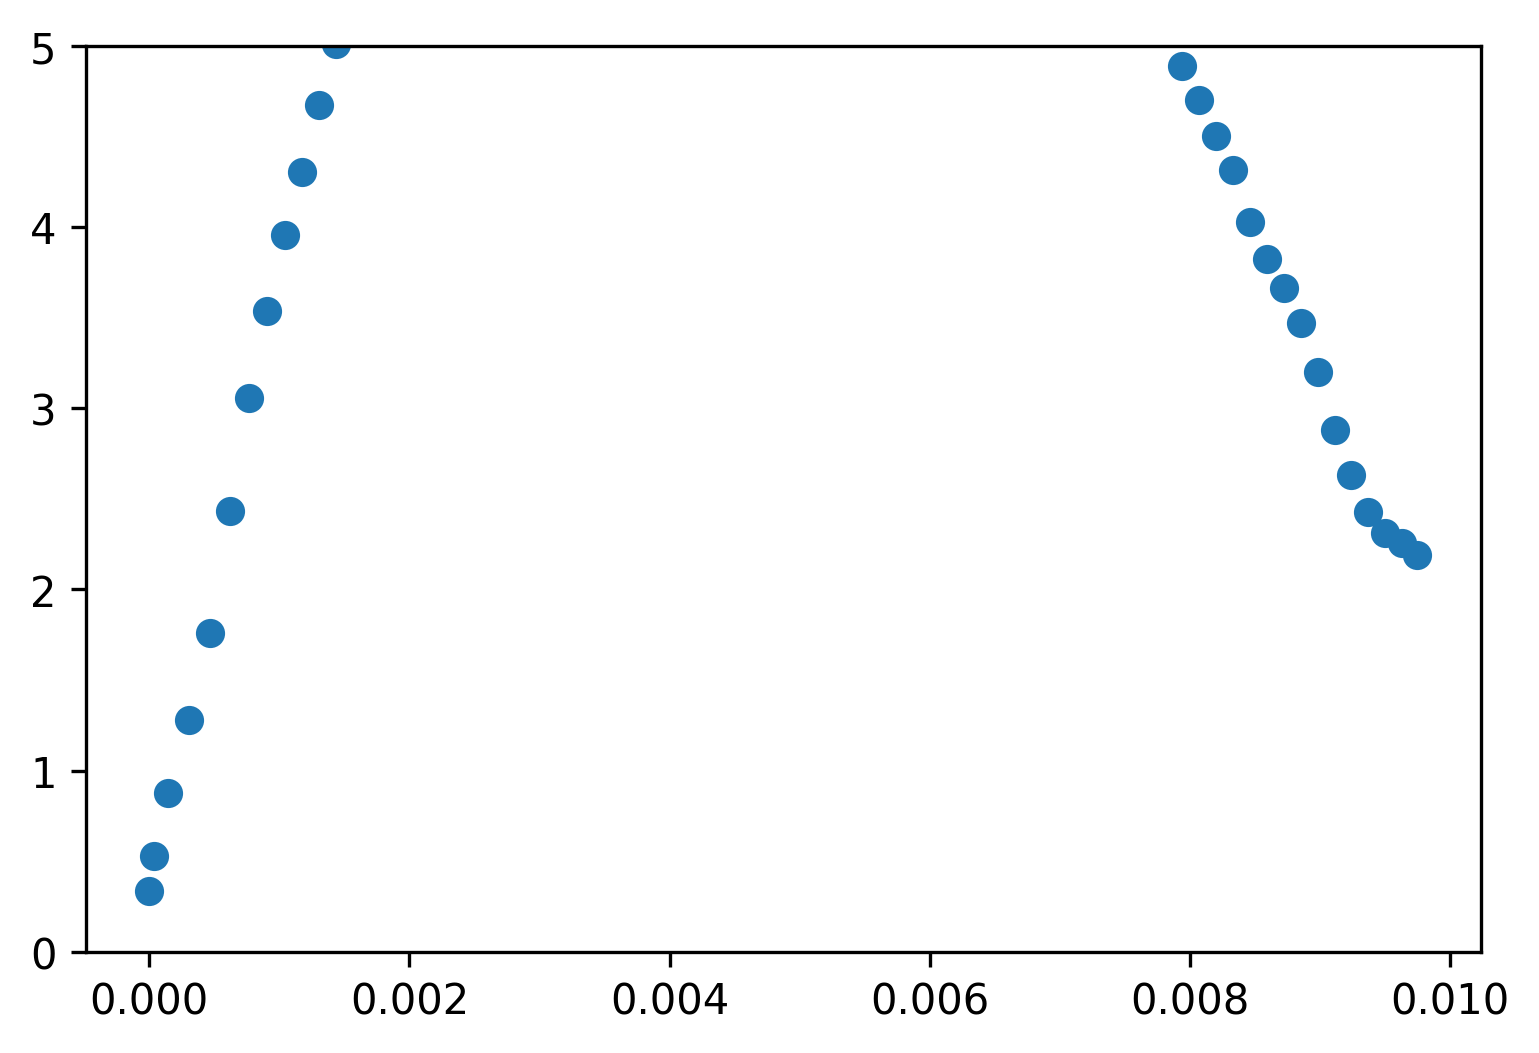

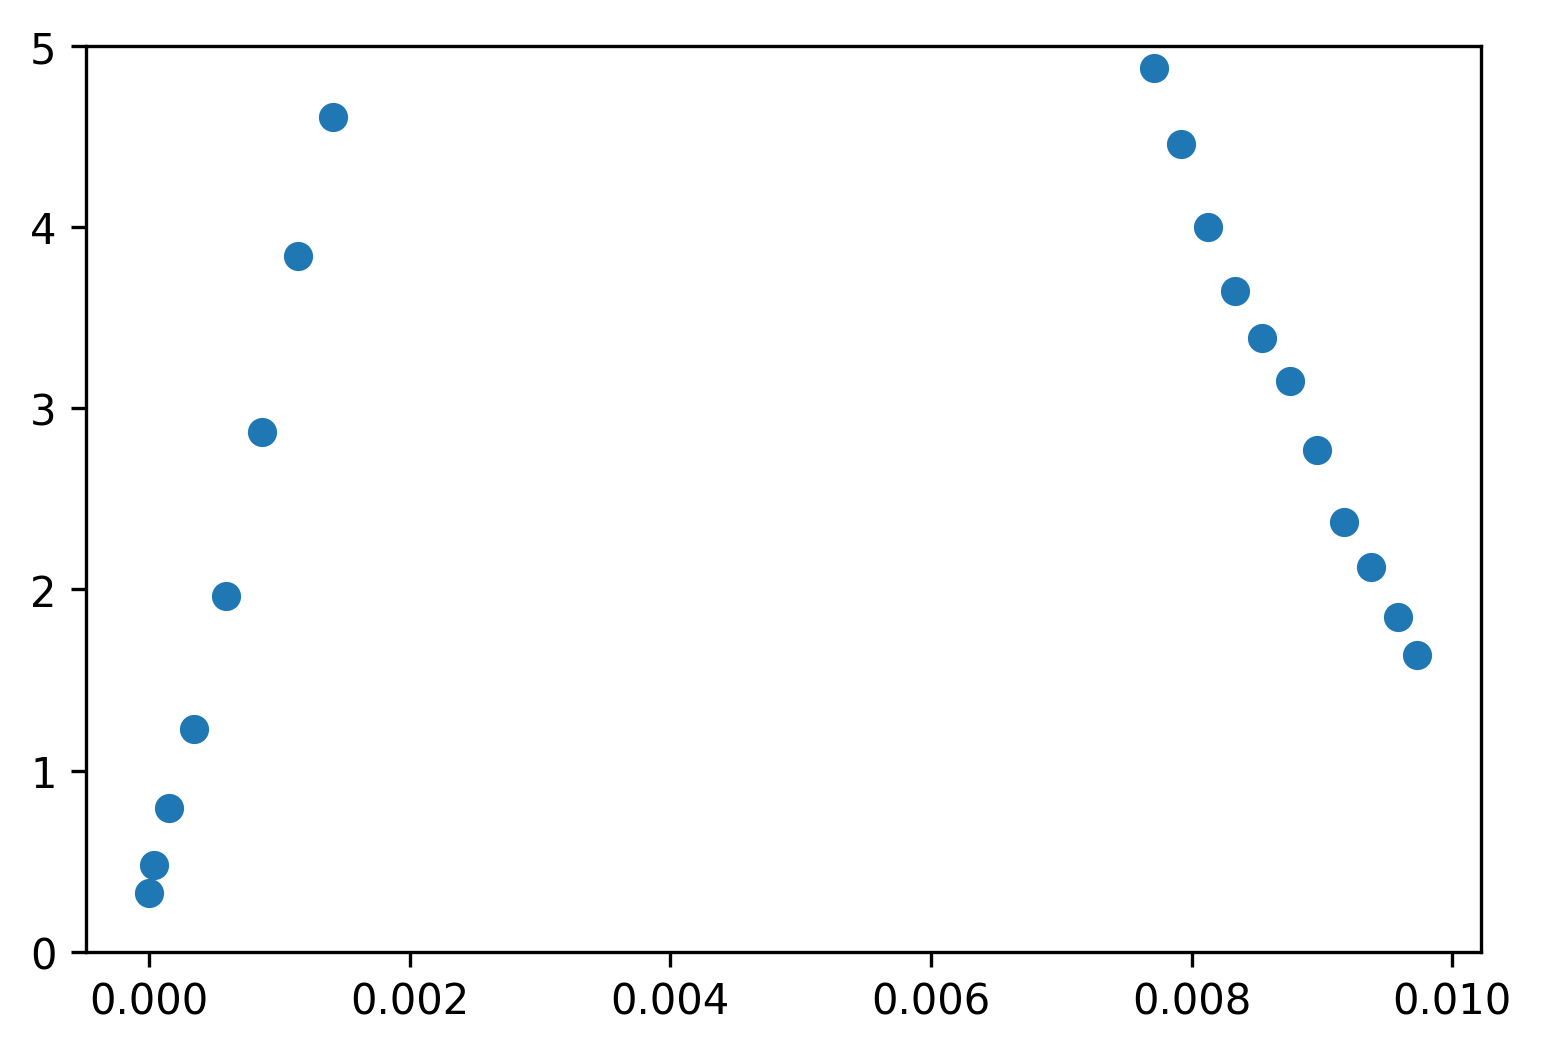

[1287.847134734781, 195.6350065200234, 44.318406139105655, 24.925250002209985]


In [97]:
# Exp 5 mus
test_mus = []
for i in range(len(test_speeds)):
  total_force = np.array(dampers[i].test_force)
  spring_force = np.array(dampers[i].test_disp)*dampers[i].k
  disp = np.array(dampers[i].test_disp)
  plt.scatter(disp, total_force - spring_force)
  plt.ylim([0,5])
  plt.show()
  viscous_force = (np.average(total_force - spring_force)) # N
  mu = viscous_force*np.pi*(dampers[i].d/2)**4/(8*dampers[i].t*dampers[i].Q*dampers[i].a) # kg/(m-s)
  test_mus.append(mu)

print(test_mus)

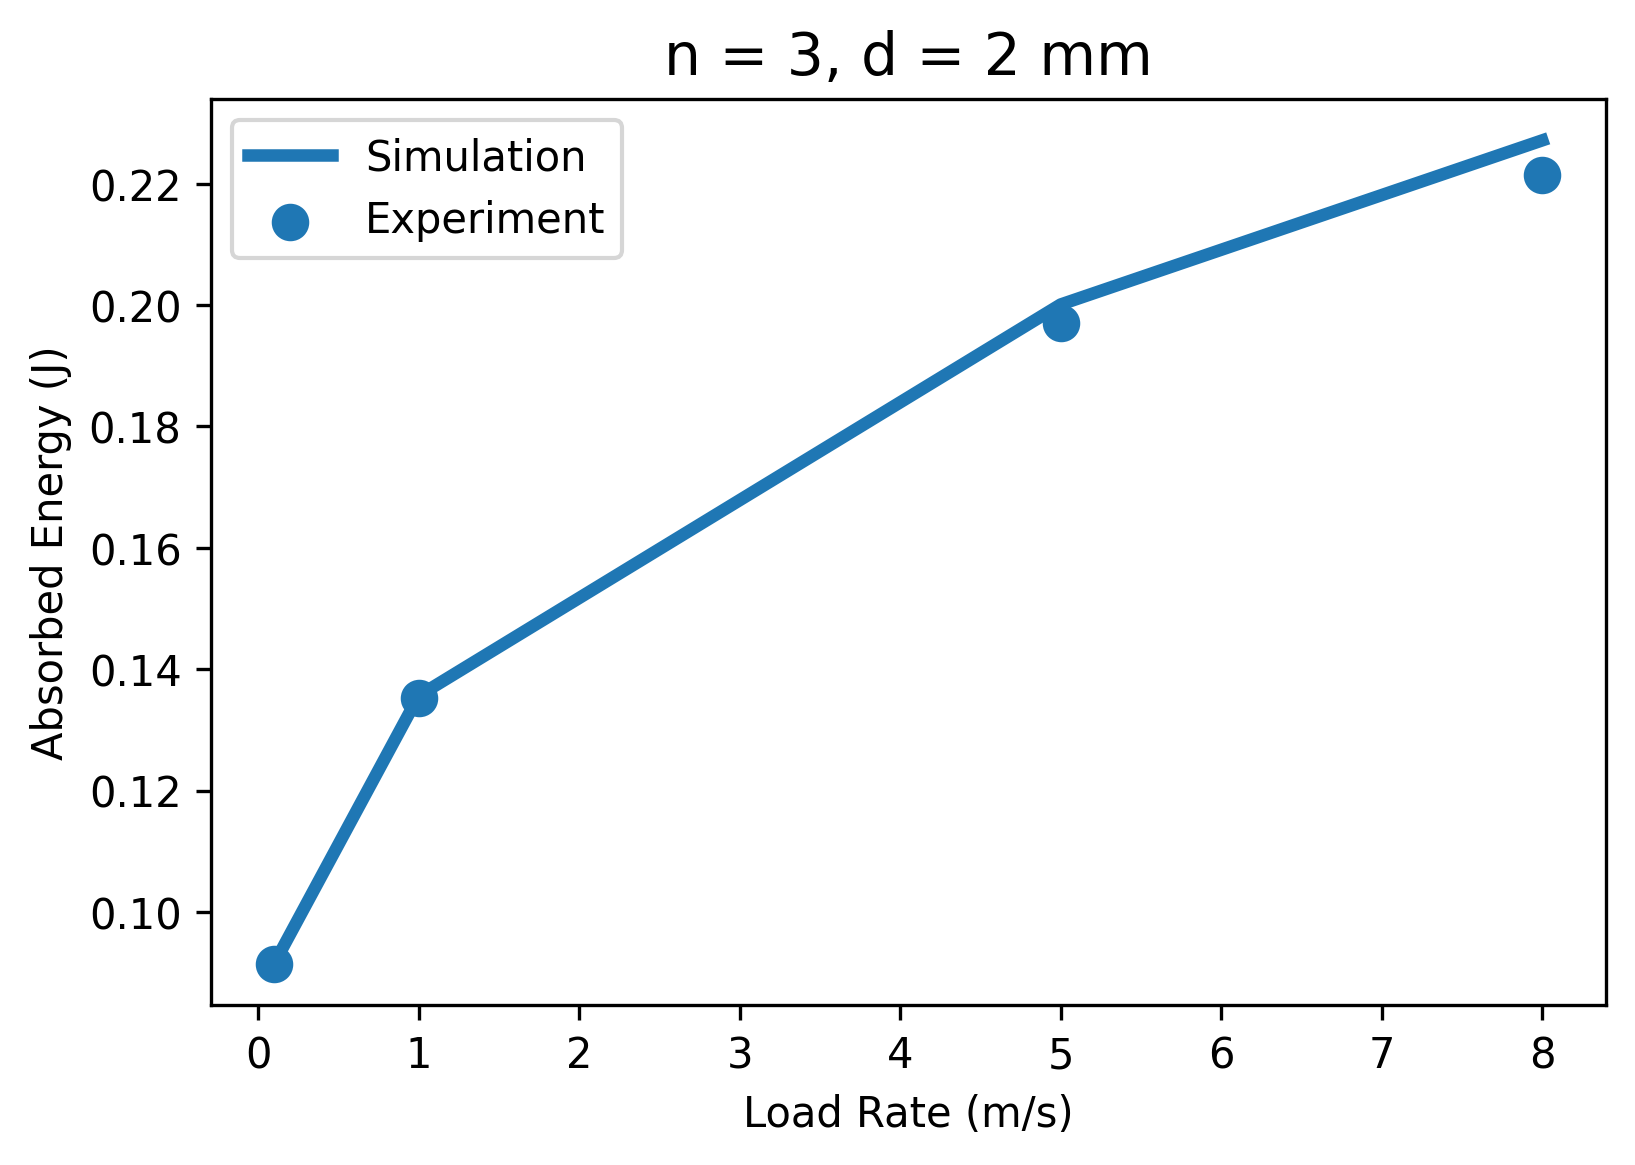

<ipython-input-98-a795bf61d629>:28: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x)+c


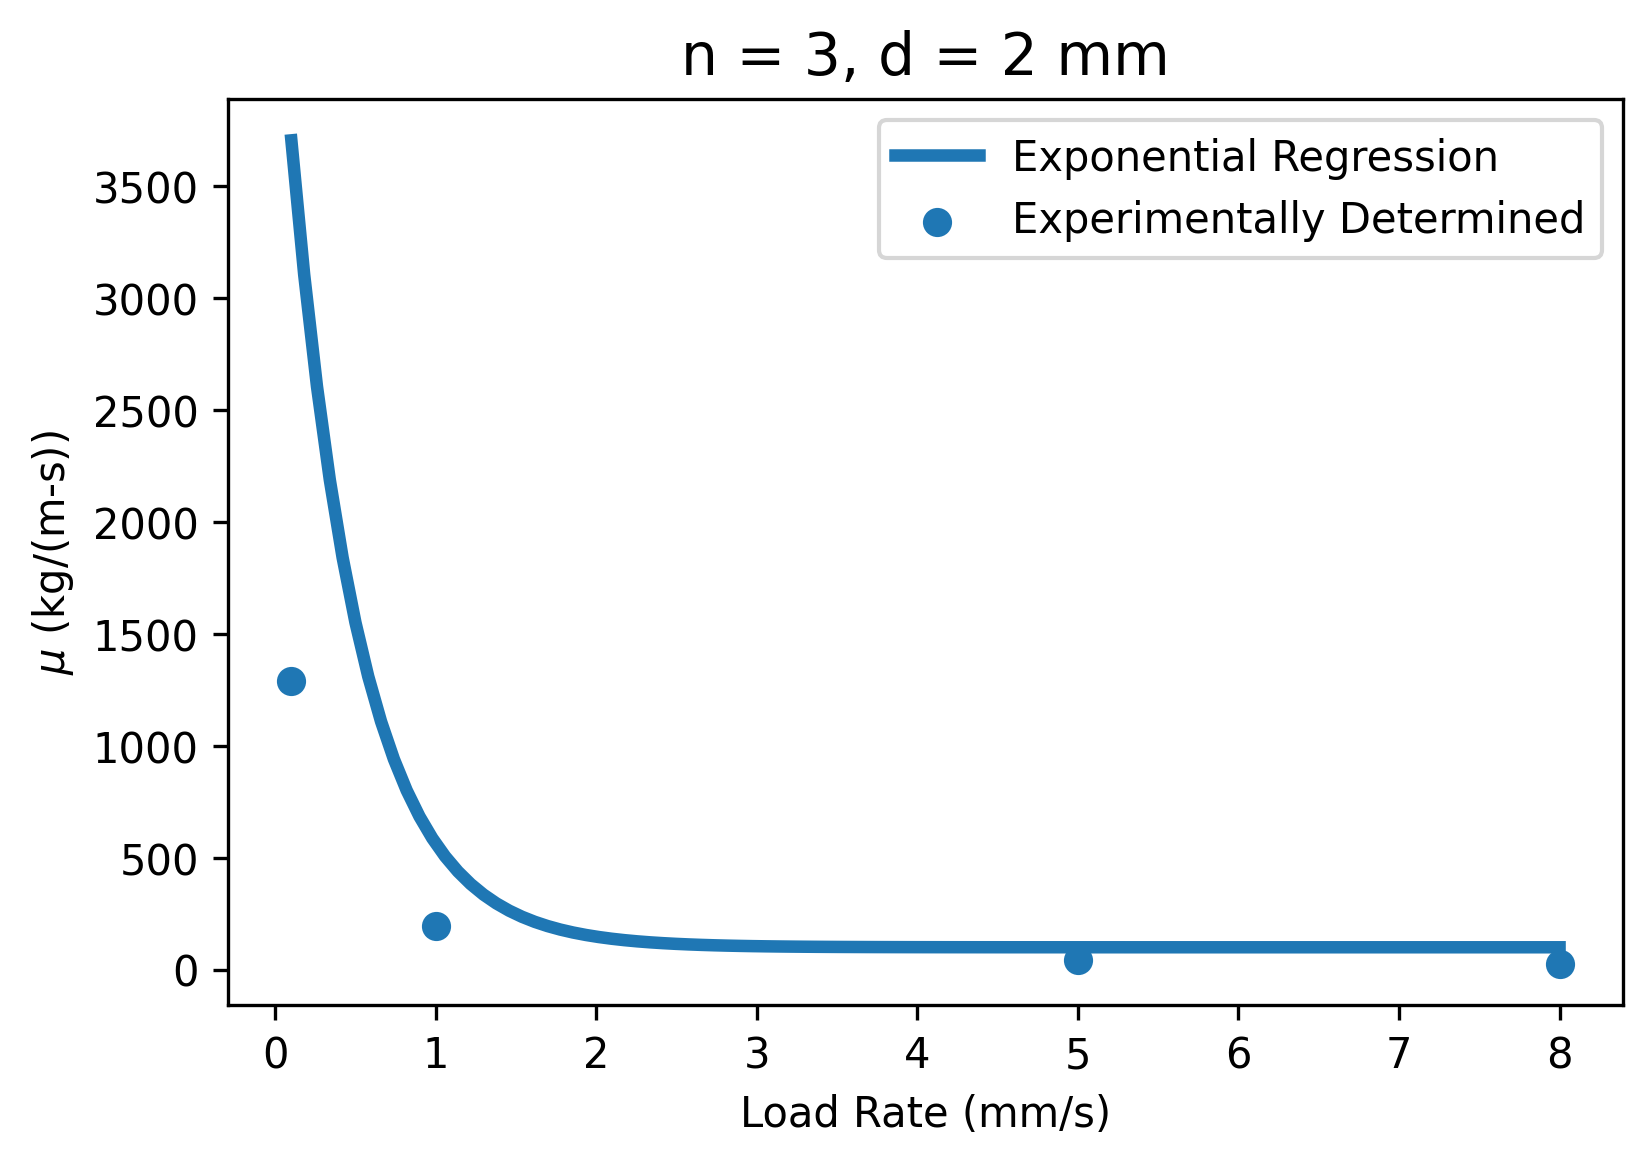

r-squared for mu: -4.461110320381908
mu at 8 m/s: 99.58310925545304 kg/(m-s)


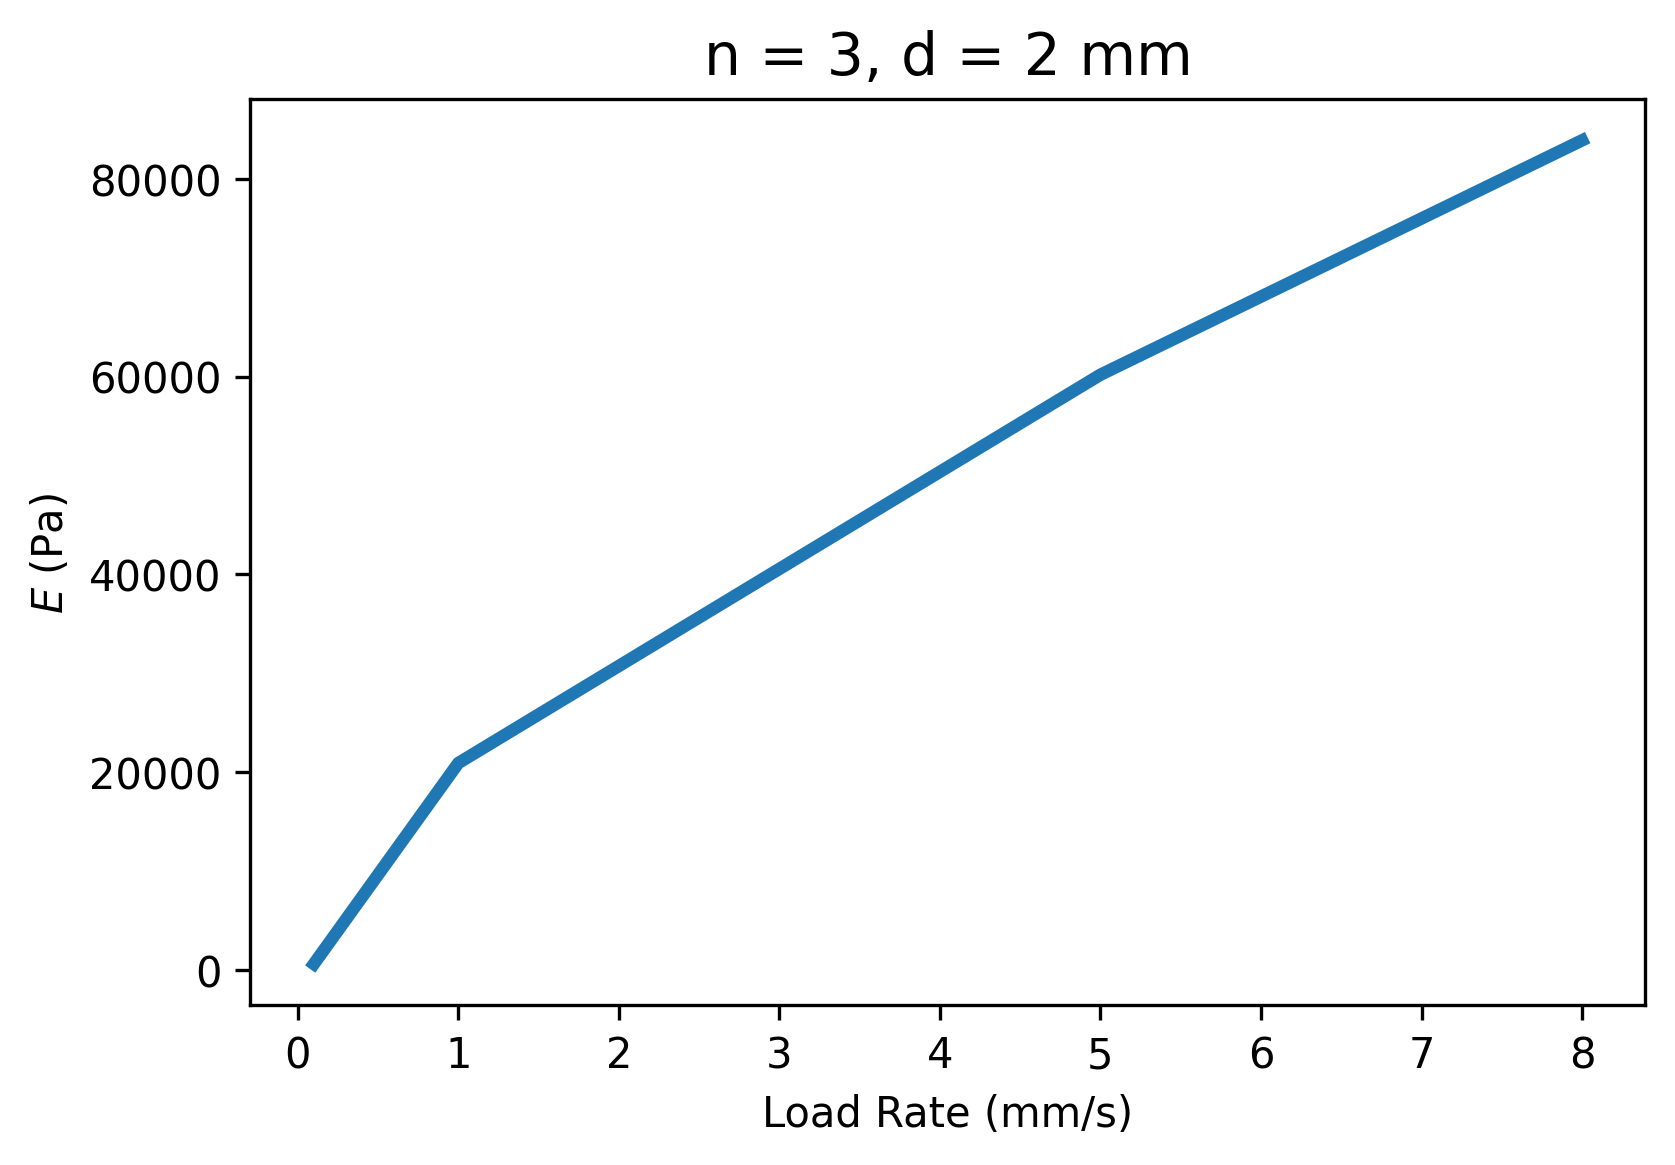

In [98]:
%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"

energies = []

sim_energies = []
exp_energies = []
for test in dampers:
  sim_energies.append(test.energy)
  exp_energies.append(test.left_point_integrate(\
                      test.test_disp, test.test_force))

plt.plot(test_speeds, sim_energies, linewidth = 3, label = "Simulation")
plt.scatter(test_speeds, exp_energies, linewidth = 3, label = "Experiment")
plt.title("n = 3, d = 2 mm", fontsize = 14)
plt.xlabel("Load Rate (m/s)")
plt.ylabel("Absorbed Energy (J)")
plt.legend()
plt.show()

# plot mu (experimental) vs speed
plt.scatter(test_speeds, test_mus, label = 'Experimentally Determined')
plt.title("n = 3, d = 2 mm", fontsize = 14)
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("$\mu$ (kg/(m-s))")

# exp decay fit to mu
def func(x, a, b, c):
    return a*np.exp(-b*x)+c 

params, _ = curve_fit(func, test_speeds, vals[:,0])
a, b, c = params[0], params[1], params[2]
x_sample = np.linspace(0.1, 8, 100)
yfit = lambda x: a*np.exp(-x*b)+c
plt.plot(x_sample, yfit(x_sample), linewidth = 3, label = 'Exponential Regression')
plt.legend()
plt.show()
print('r-squared for mu: {}'.format(r2_score(test_mus, a*np.exp(np.array(test_speeds)*-b)+c)))
print('mu at 8 m/s: {} kg/(m-s)'.format(yfit(8000)))
mu_8000 = yfit(8000)

# plot E vs speed
plt.plot(test_speeds, vals[:,1], linewidth = 3)
plt.title("n = 3, d = 2 mm", fontsize = 14)
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("$E$ (Pa)")
plt.show()

sim_energies5 = sim_energies
exp_energies5 = exp_energies

In [99]:
# Testing stuff
import numpy as np

test_speeds = [0.1, 1, 5, 8] # mm/s

dampers = []
vals = np.zeros((len(test_speeds), 2))

n = 3
exp_num = 5
d = 2E-3 # m
rho = 1300 # kg/m^3 (toothpaste)
D = (20 + 23.5)/2 * 1E-3 # m
u = test_speeds[0] # mm/s
vals[0,:] = optimize(u, n, exp_num, d, rho, D)

test_speeds = [0.1, 1, 5, 8] # mm/s

dampers = []

3705.6007011255133
634.4640646590078


3116.4595566475177

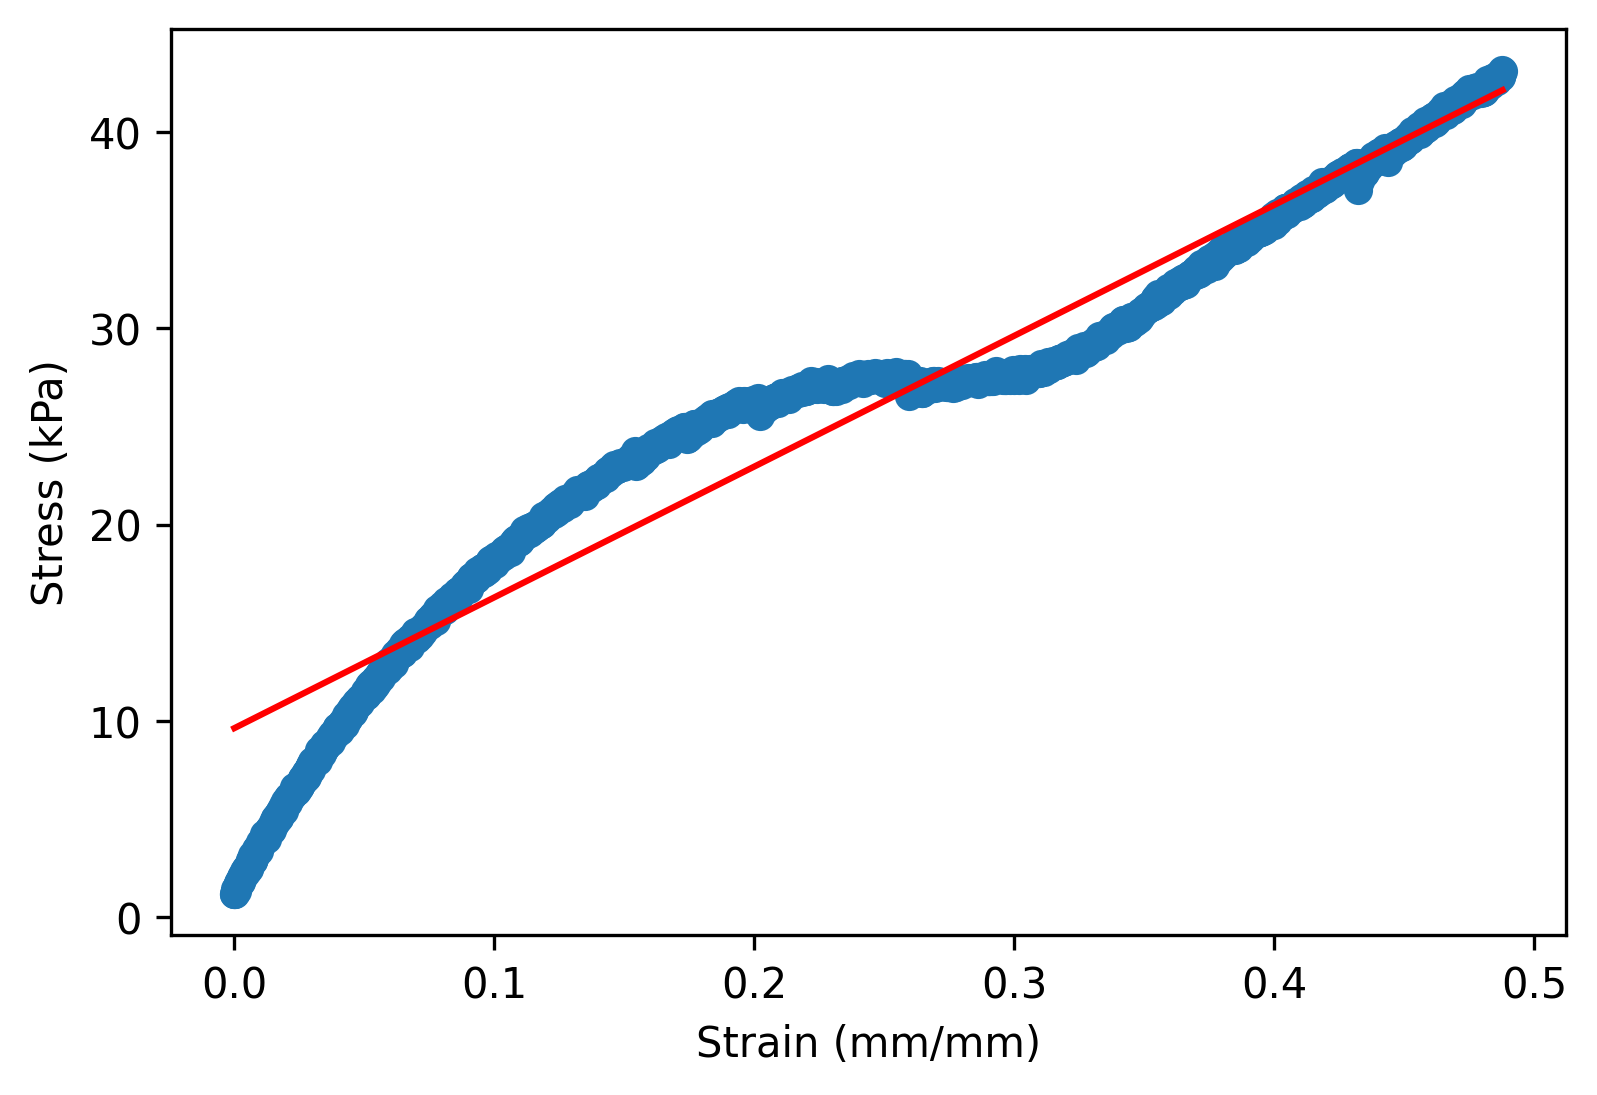

In [100]:
mu, E = vals[0, 0], vals[0, 1]
print(mu)
print(E)
n = 3
exp_num = 5
d = 2E-3 # m
rho = 1300 # kg/m^3 (toothpaste)
D = (20 + 23.5)/2 * 1E-3 # m

test = damper(d, D, mu, E, rho, n, exp = 5)
u = test_speeds[0] # m/s
test.match_test(0.1)
test.plotSS()
test.least_squares()

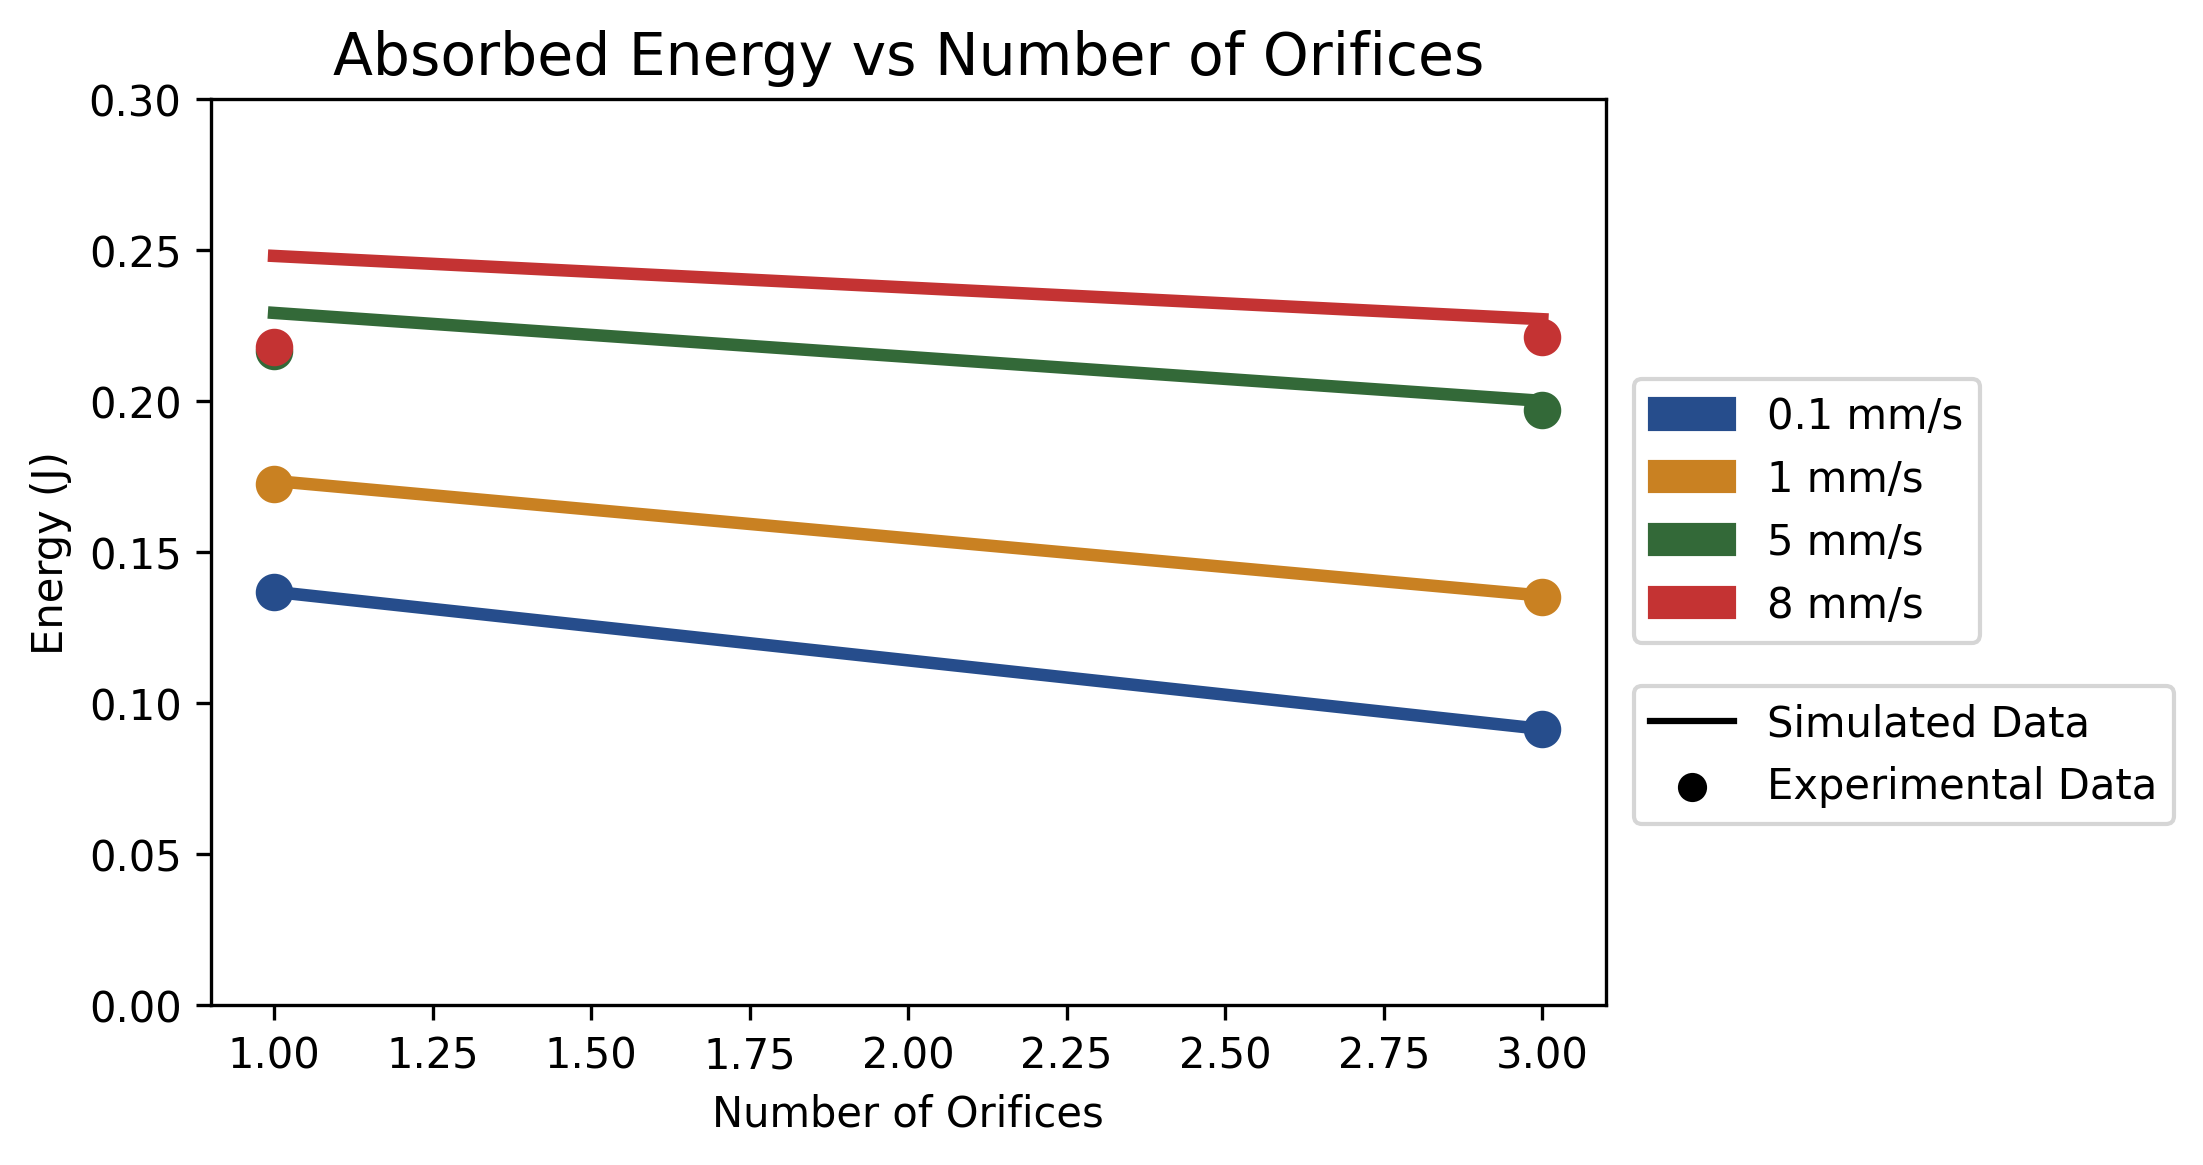

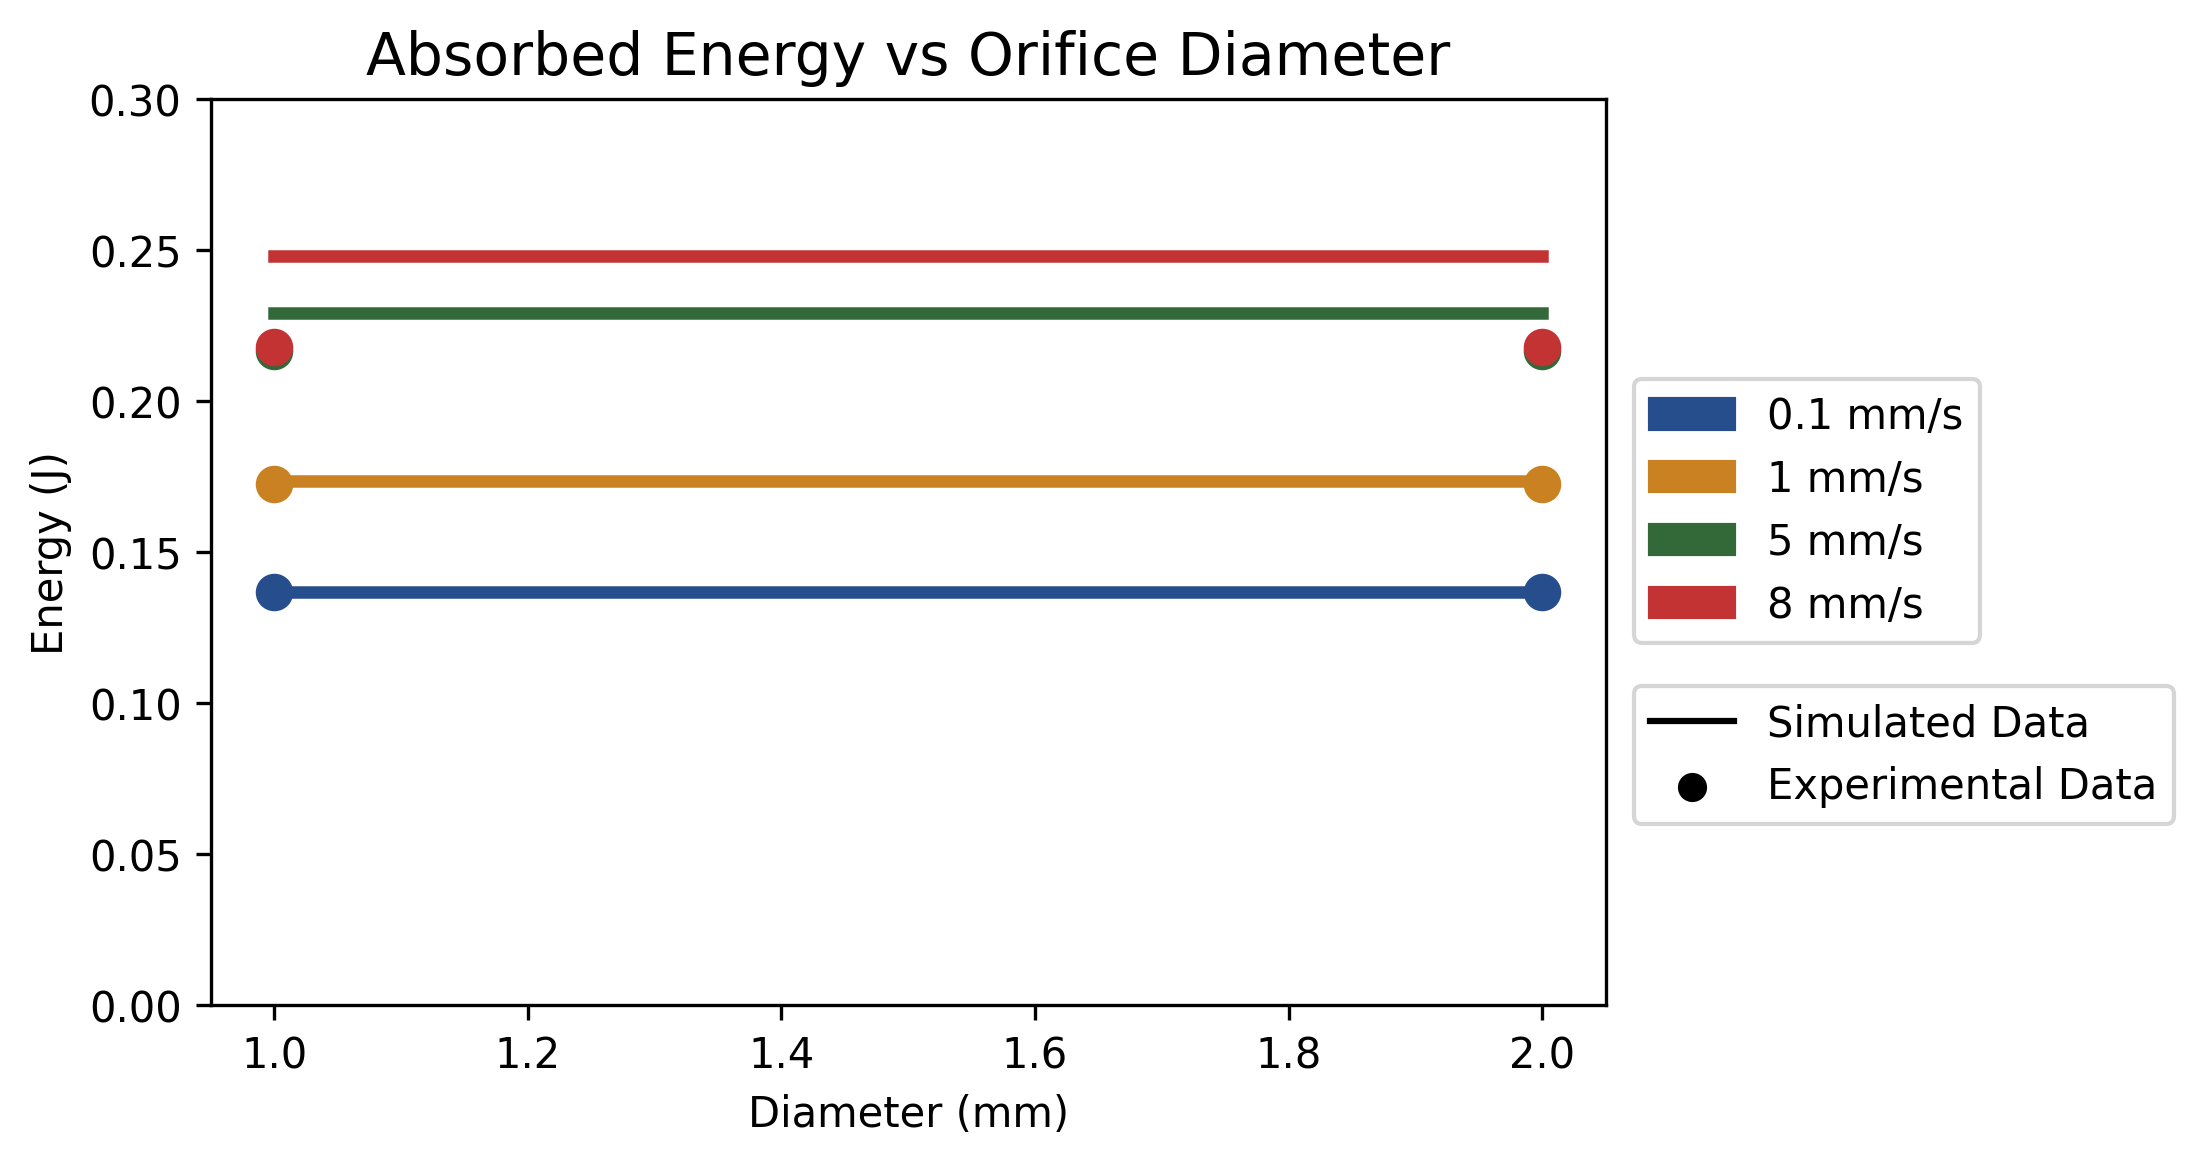

In [101]:
import matplotlib
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

colors = [[.14902, .301961, .54902], [.788235, .505882, .133333], [.2, .411765, .219608], [.768627, .2, .2]]

for i in range(4):
  plt.plot([1, 3], [sim_energies3[i], sim_energies5[i]], linewidth = 3, color = colors[i])
  plt.scatter([1, 3], [exp_energies3[i], exp_energies5[i]], linewidth = 3, color = colors[i])
  plt.title("Absorbed Energy vs Number of Orifices", fontsize = 14)
  plt.xlabel("Number of Orifices")
  plt.ylabel("Energy (J)")
  plt.legend()
  plt.ylim([0,0.3])
line = mlines.Line2D([], [], color='black', marker='', markersize=5, label='Simulated Data')
dot = plt.scatter([], [] ,color='black', label='Experimental Data')
first_legend = plt.legend(handles=[line, dot], bbox_to_anchor=(1.02, .2), loc='lower left', borderaxespad=0.)
ax = plt.gca().add_artist(first_legend)

blue_patch = mpatches.Patch(color=(.14902, .301961, .54902), label='0.1 mm/s')
orange_patch = mpatches.Patch(color=(.788235, .505882, .133333), label='1 mm/s')
green_patch = mpatches.Patch(color=(.2, .411765, .219608), label='5 mm/s')
red_patch = mpatches.Patch(color=(.768627, .2, .2), label='8 mm/s')
plt.legend(handles=[blue_patch, orange_patch, green_patch, red_patch], bbox_to_anchor=(1.02, .4), loc='lower left', borderaxespad=0.)
plt.show()

for i in range(4):
  plt.plot([1, 2], [sim_energies2[i], sim_energies3[i]], linewidth = 3, color = colors[i])
  plt.scatter([1, 2], [exp_energies2[i], exp_energies3[i]], linewidth = 3, color = colors[i])
  plt.title("Absorbed Energy vs Orifice Diameter", fontsize = 14)
  plt.xlabel("Diameter (mm)")
  plt.ylabel("Energy (J)")
  plt.legend()
  plt.ylim([0,0.3])

line = mlines.Line2D([], [], color='black', marker='', markersize=5, label='Simulated Data')
dot = plt.scatter([], [] ,color='black', label='Experimental Data')
first_legend = plt.legend(handles=[line, dot], bbox_to_anchor=(1.02, .2), loc='lower left', borderaxespad=0.)
ax = plt.gca().add_artist(first_legend)

blue_patch = mpatches.Patch(color=(.14902, .301961, .54902), label='0.1 mm/s')
orange_patch = mpatches.Patch(color=(.788235, .505882, .133333), label='1 mm/s')
green_patch = mpatches.Patch(color=(.2, .411765, .219608), label='5 mm/s')
red_patch = mpatches.Patch(color=(.768627, .2, .2), label='8 mm/s')
plt.legend(handles=[blue_patch, orange_patch, green_patch, red_patch], bbox_to_anchor=(1.02, .4), loc='lower left', borderaxespad=0.)
plt.show()

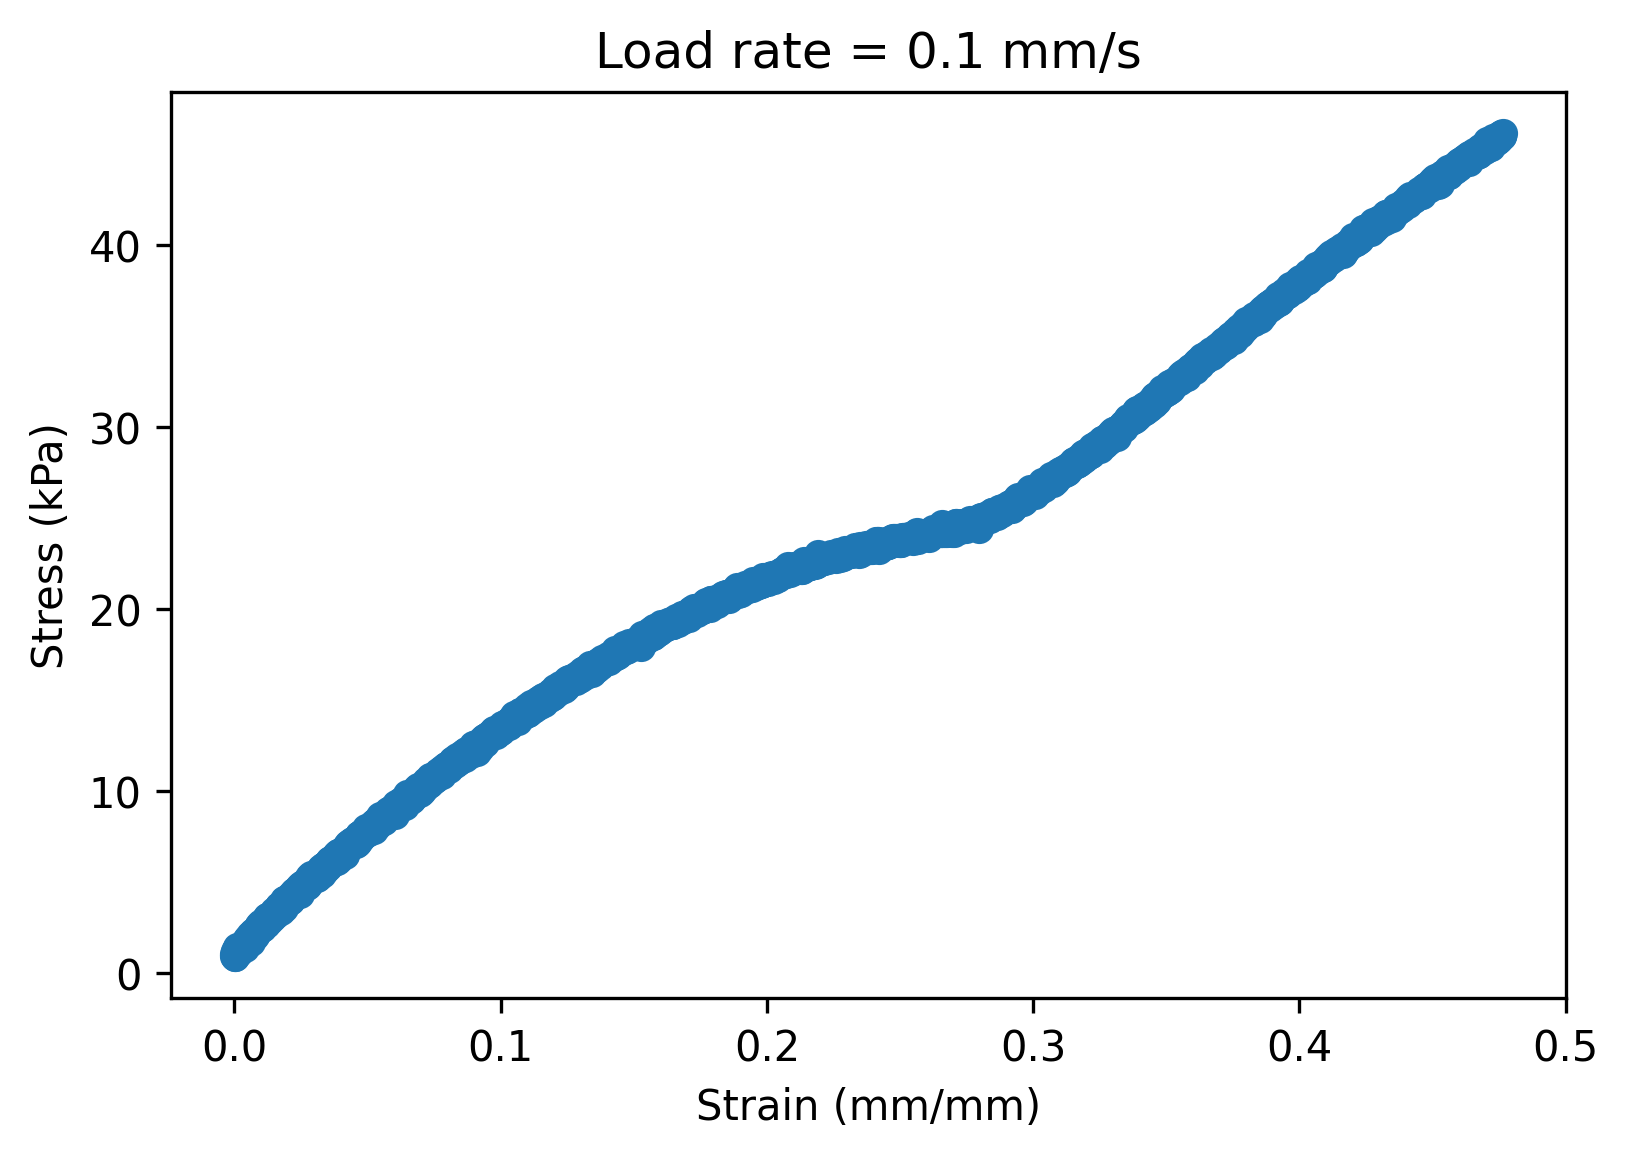

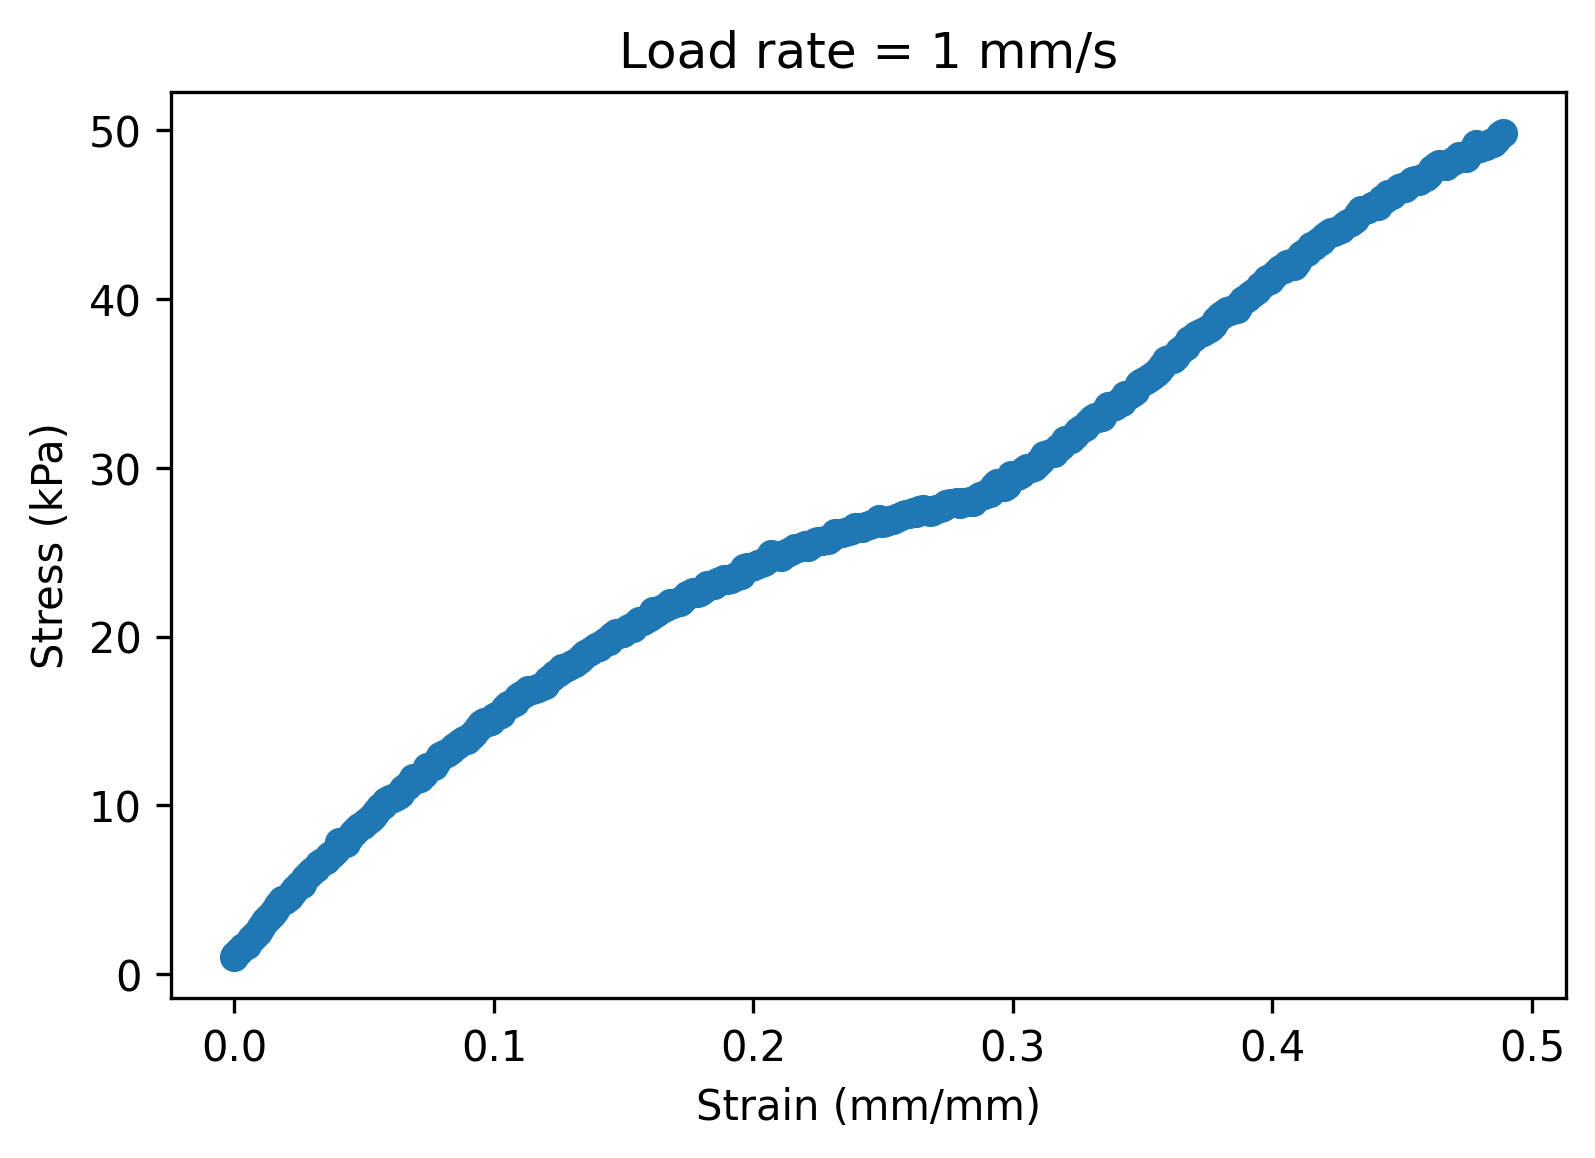

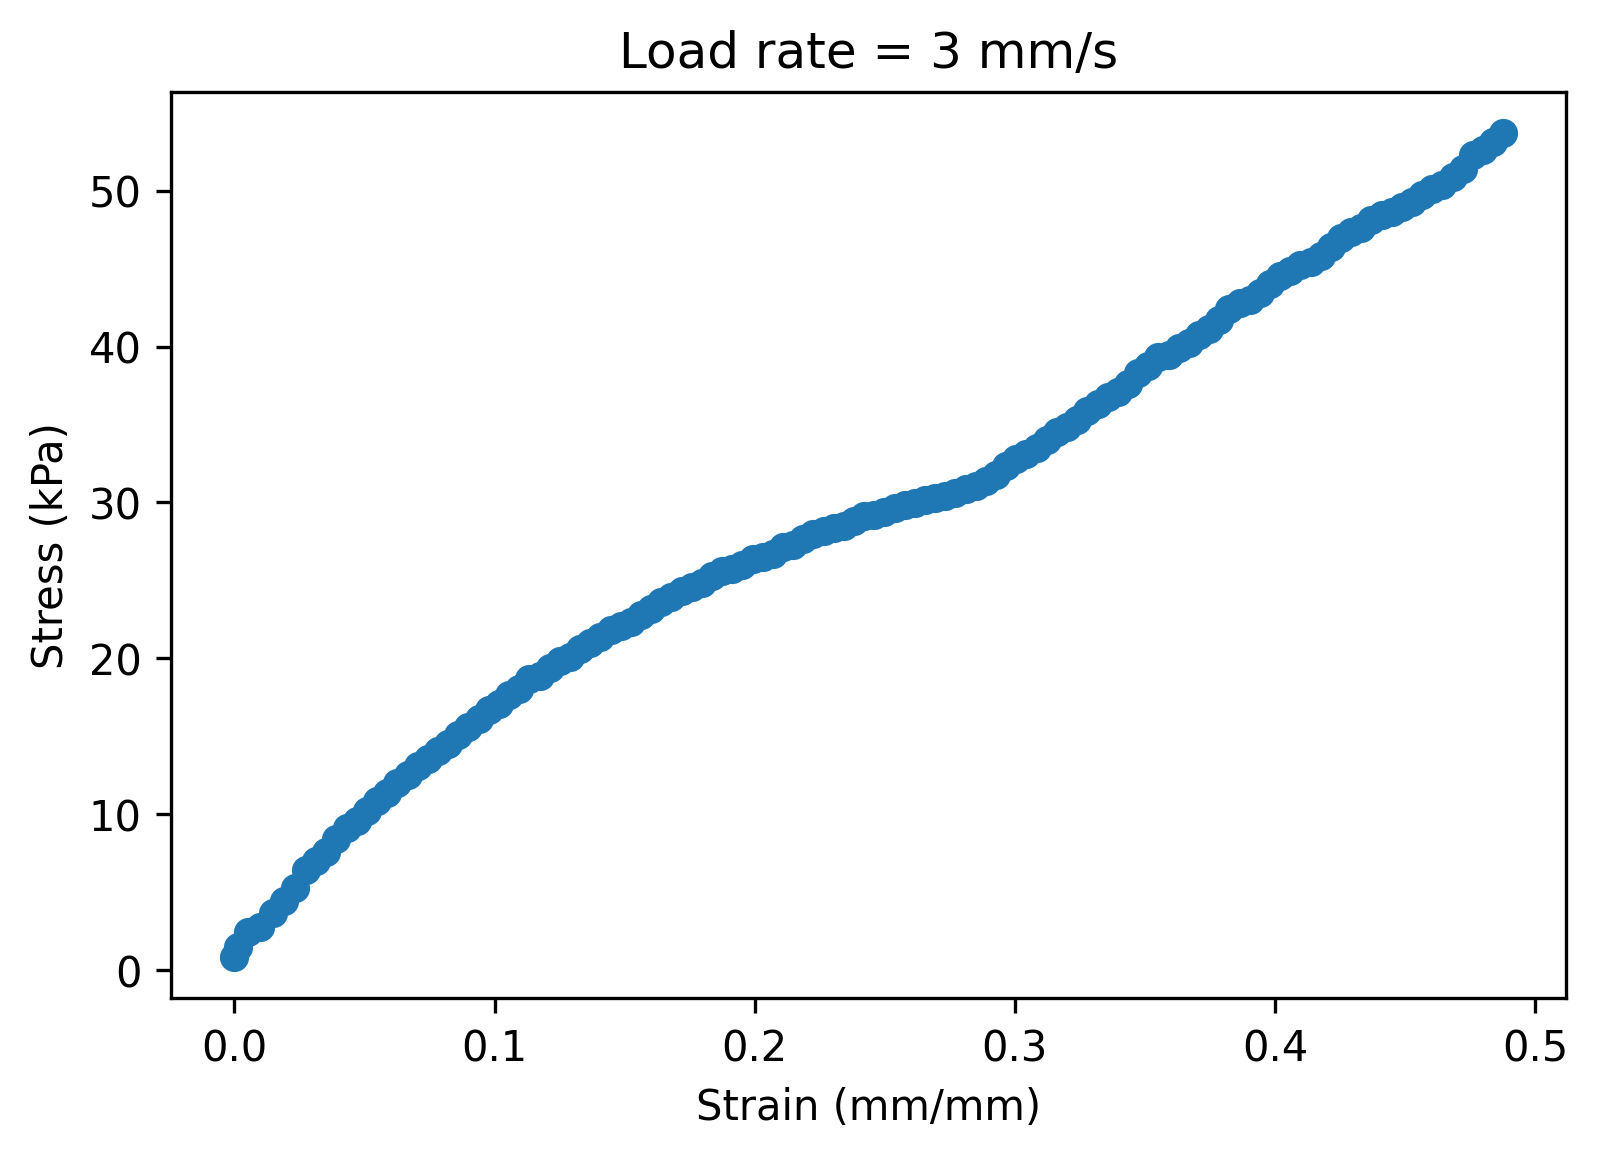

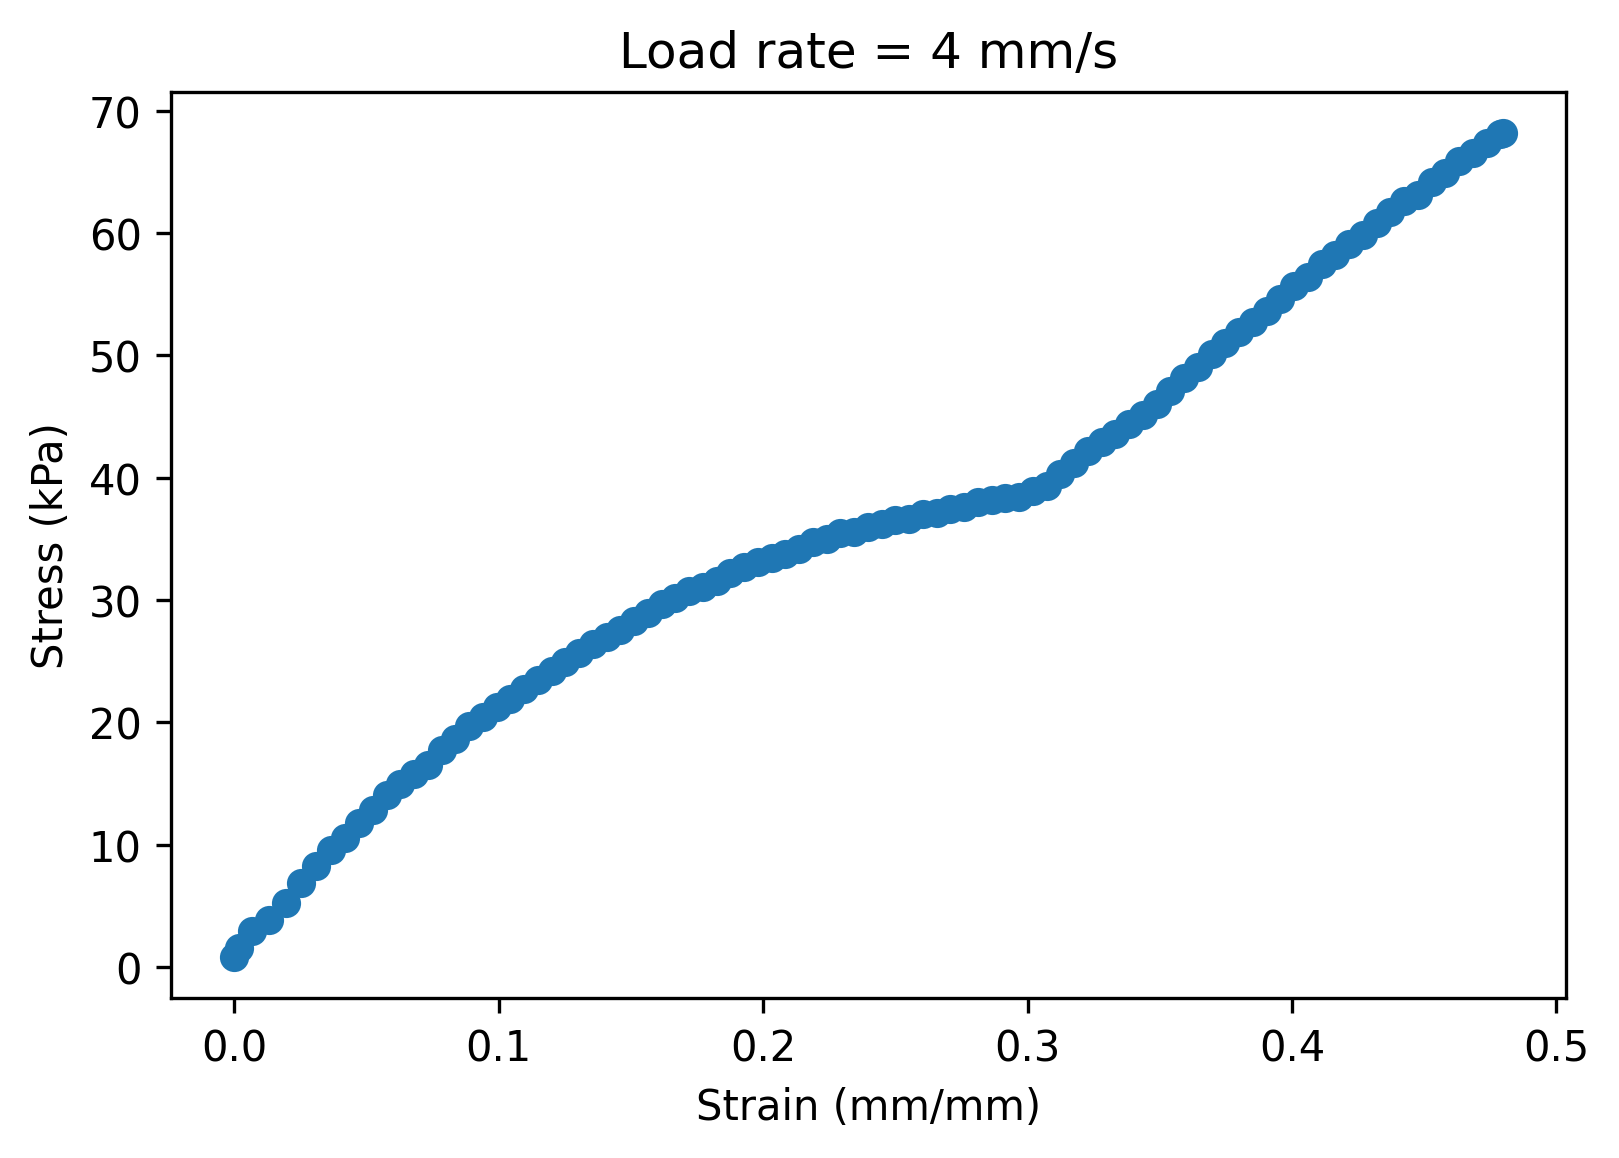

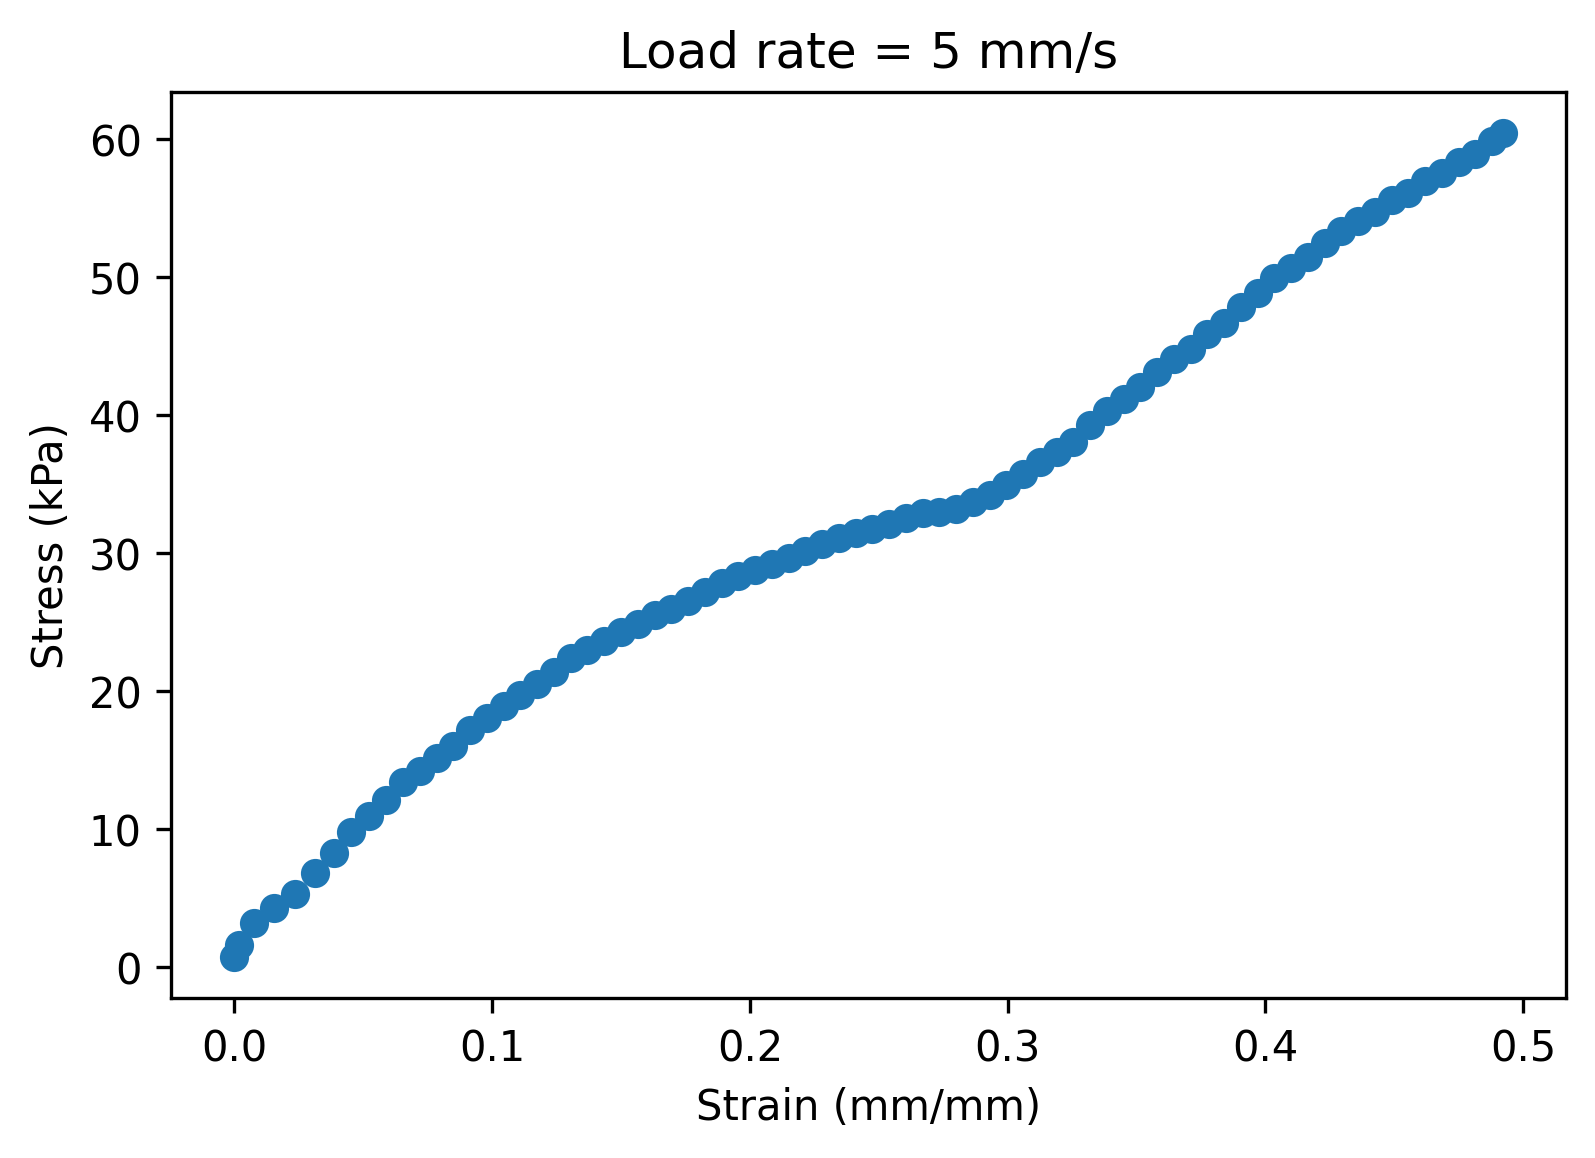

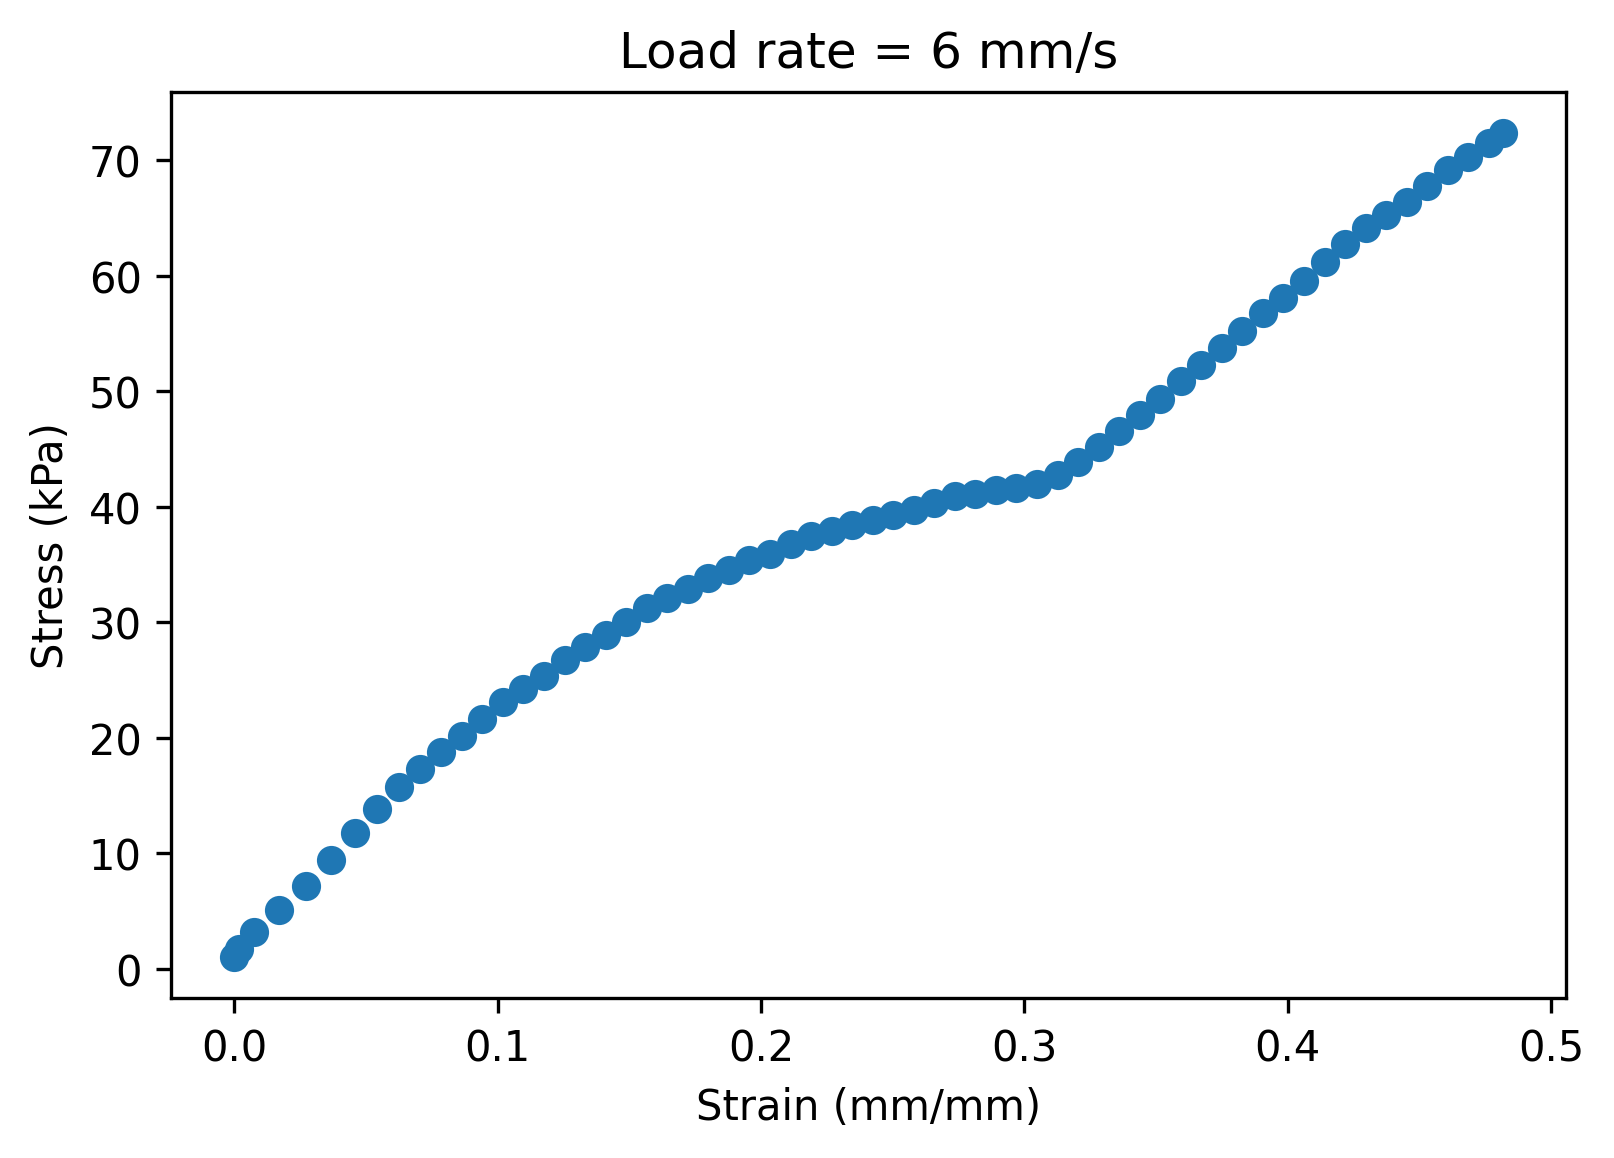

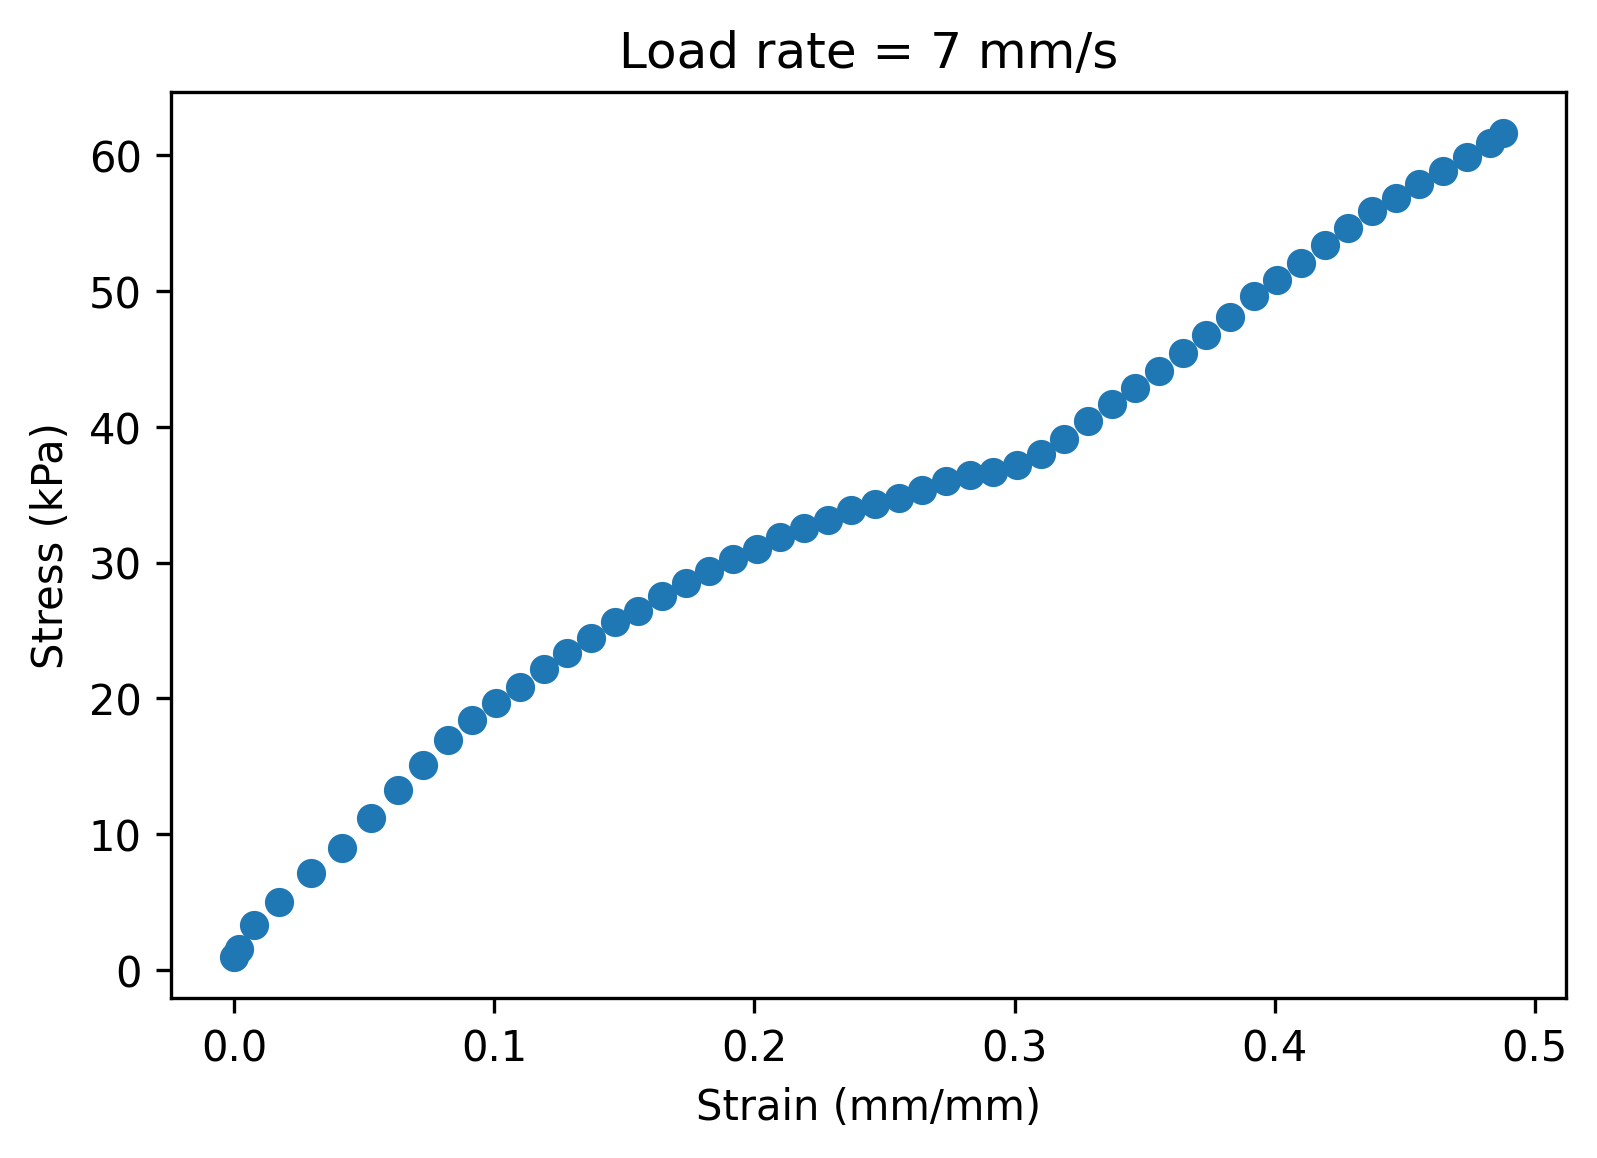

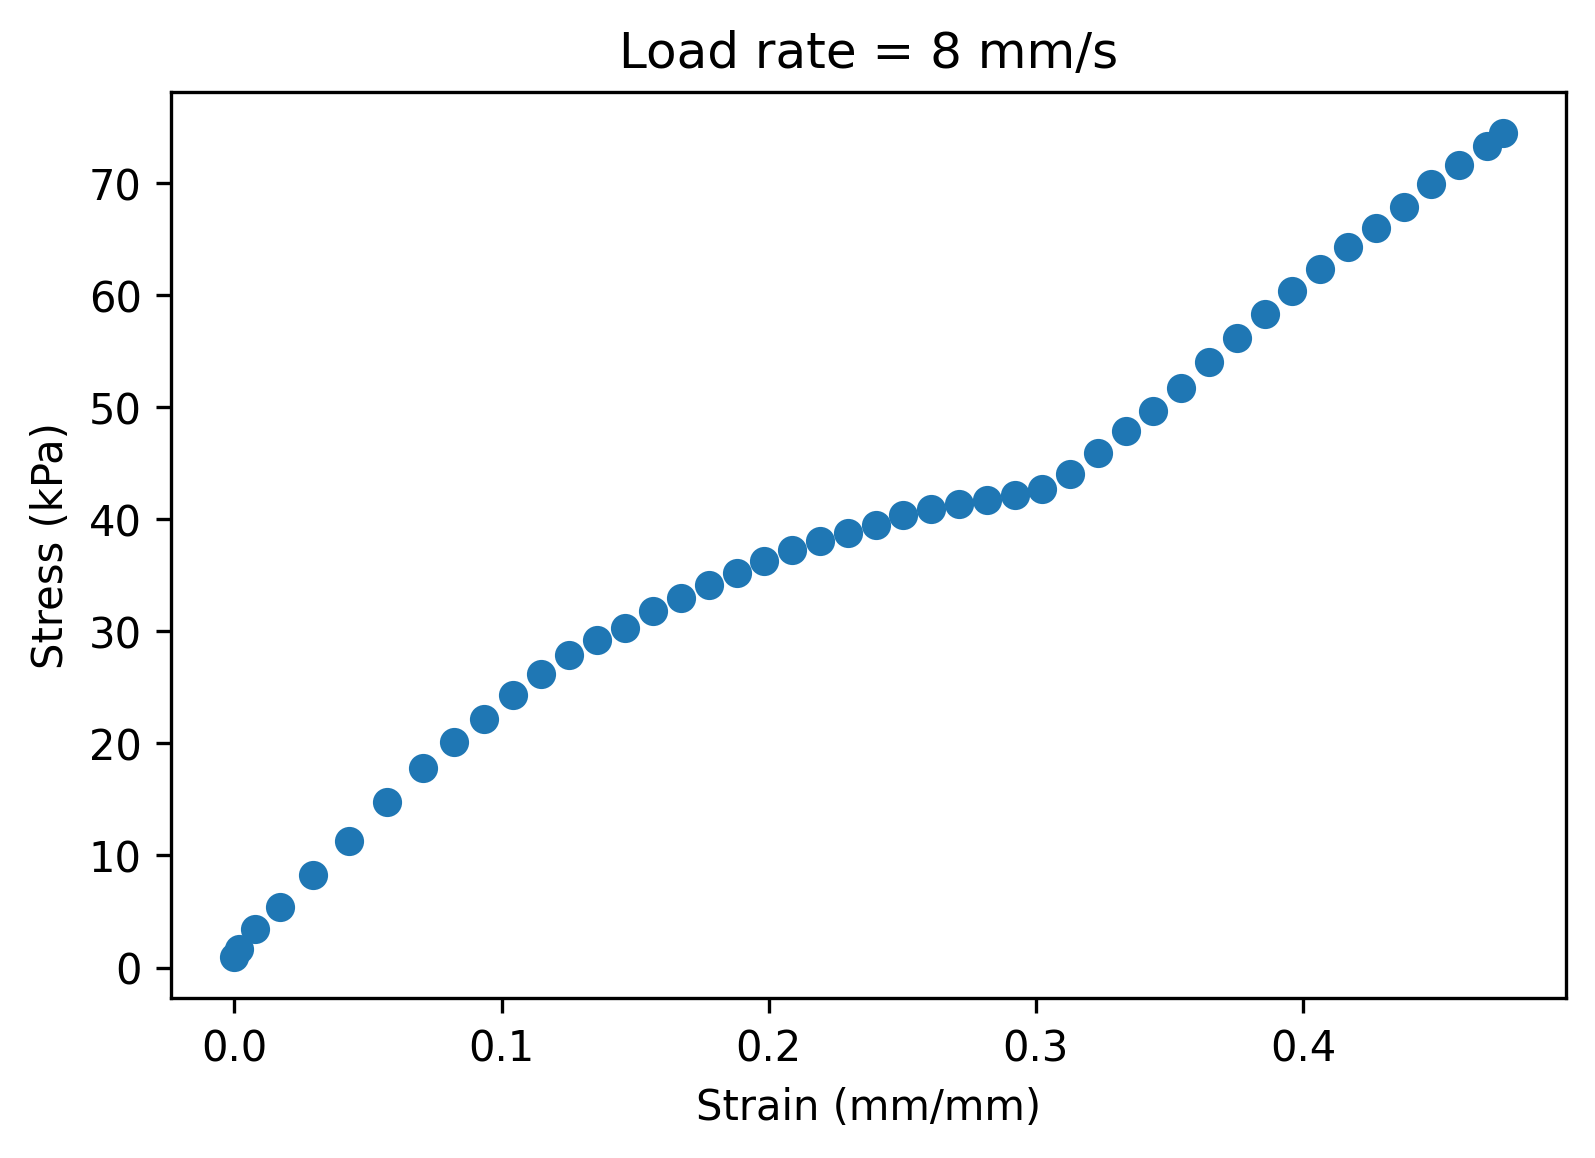

In [102]:
# Plotting Exp 1 test data, parameters are arbitrary since I am not modeling just using class to plot
import matplotlib.pyplot as plt

test_speeds = [0.1, 1, 3, 4, 5, 6, 7, 8]
n = 3
exp_num = 5
d = 2E-3 # m
rho = 1300 # kg/m^3 (toothpaste)
D = (20 + 23.5)/2 * 1E-3 # m
mu = 1 # not relevant, just physical data
E = 1 # not relevant

for speed in test_speeds:
  test_damper = damper(d, D, mu, E, rho, n, exp = 1)
  test_damper.u = speed
  test_damper.process_test()
  plt.scatter(test_damper.test_strain, test_damper.test_stress)
  plt.title('Load rate = {} mm/s'.format(speed))
  plt.xlabel('Strain (mm/mm)')
  plt.ylabel('Stress (kPa)')
  plt.show()

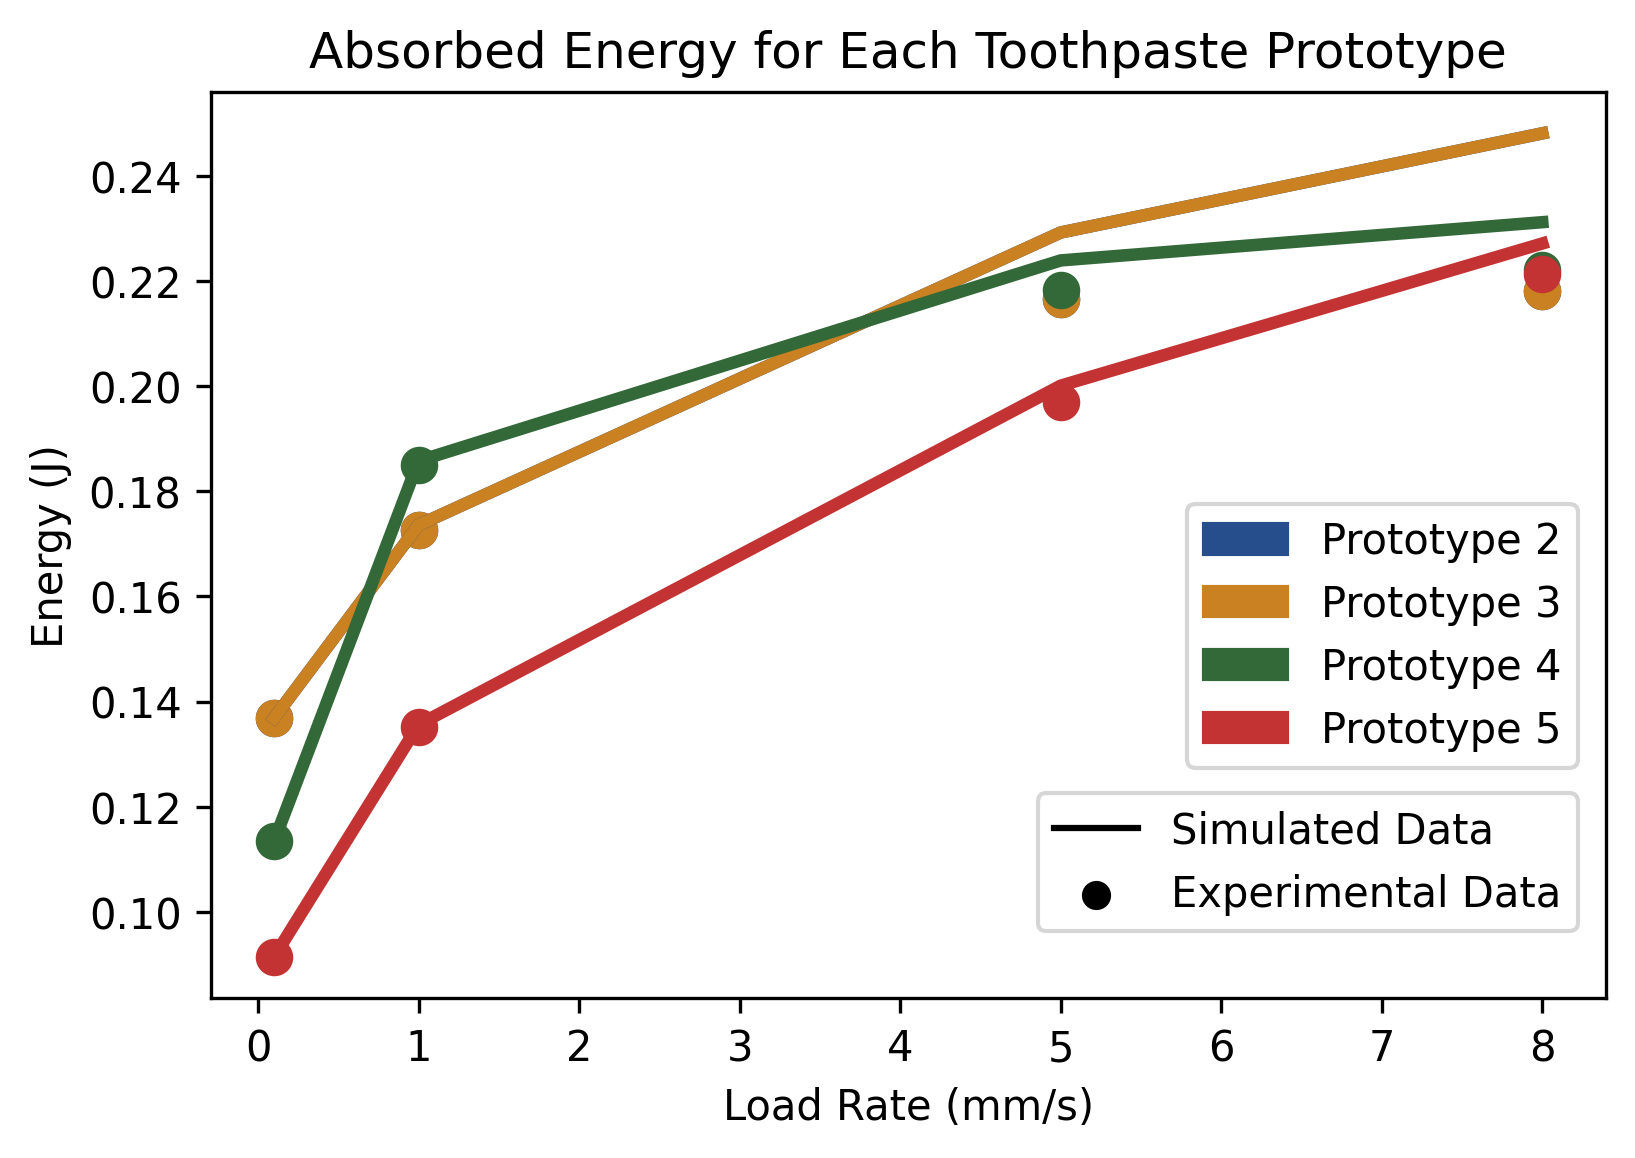

In [103]:
# plot all the energies together
import matplotlib
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

test_speeds = [0.1, 1, 5, 8]
p2 = plt.plot(test_speeds, sim_energies2, linewidth = 3, label = 'Prototype 2', color = (.14902, .301961, .54902))
plt.scatter(test_speeds, exp_energies2, linewidth = 3, color = (.14902, .301961, .54902))
p3 = plt.plot(test_speeds, sim_energies3, linewidth = 3, label = 'Prototype 3', color = (.788235, .505882, .133333))
plt.scatter(test_speeds, exp_energies3, linewidth = 3, color = (.788235, .505882, .133333))
p4 = plt.plot(test_speeds, sim_energies4, linewidth = 3, label = 'Prototype 4', color = (.2, .411765, .219608))
plt.scatter(test_speeds, exp_energies4, linewidth = 3, color = (.2, .411765, .219608))
p5 = plt.plot(test_speeds, sim_energies5, linewidth = 3, label = 'Prototype 5', color = (.768627, .2, .2))
plt.scatter(test_speeds, exp_energies5, linewidth = 3, color = (.768627, .2, .2))
plt.title("Absorbed Energy for Each Toothpaste Prototype")
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("Energy (J)")

line = mlines.Line2D([], [], color='black', marker='', markersize=5, label='Simulated Data')
dot = plt.scatter([], [] ,color='black', label='Experimental Data')
first_legend = plt.legend(handles=[line, dot], bbox_to_anchor=(.98, .15), loc='right', borderaxespad=0.)
ax = plt.gca().add_artist(first_legend)

blue_patch = mpatches.Patch(color=(.14902, .301961, .54902), label='Prototype 2')
orange_patch = mpatches.Patch(color=(.788235, .505882, .133333), label='Prototype 3')
green_patch = mpatches.Patch(color=(.2, .411765, .219608), label='Prototype 4')
red_patch = mpatches.Patch(color=(.768627, .2, .2), label='Prototype 5')
plt.legend(handles=[blue_patch, orange_patch, green_patch, red_patch], bbox_to_anchor=(0.98, .4), loc='right', borderaxespad=0.)
